In [1]:
#Import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
#Do this for the categorical variable warnings I get
#Can be disabled, but you would get an annoying message
import warnings
warnings.filterwarnings('ignore')

In [2]:
###### Preliminary Analysis ######

#Load data set
train_df = pd.read_csv("titanic/train.csv")

In [3]:
#Look at data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#I am interested in seeing the amount of missing values and object types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
#Interestingly, there are multiple missing values in age 
#Another relevant feature to address is that the sex in the dataframe appears as a string, 
#I prefer an indicator variable to find correlations and work with it numerically
#I also want to do the same with embarked
#I first focus on the formatting of the other variables before turning my attention to age
#For embarked there is only two missing values, for simplicity I remove them
train_df = train_df.dropna(subset=['Embarked'])
#Reset index to avoid errors with the transformer
train_df.reset_index(drop=True,inplace=True)

In [6]:
#Get column enconder for certain variables
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        #Define embarkment categories as the column names
        column_names = list(set(X['Embarked']))
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        #Do the same for gender
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = list(set(X['Sex']))
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        #Do the same for Pclass
        matrix = encoder.fit_transform(X[['Pclass']]).toarray()
        column_names = list(set(X['Pclass']))
        #Make explicit it comes from the class
        column_names = ['Class ' + str(x) for x in column_names]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

In [7]:
#Drop irrelevant features
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Ignore errors if there are Nans
        return X.drop(["Embarked", "Sex","male"], axis = 1, errors="ignore")

In [8]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("featureencoder",FeatureEncoder()),
                    ("featuredropper",FeatureDropper())])

In [9]:
#Apply pipeline to the full training data
train_df = pipeline.fit_transform(train_df)

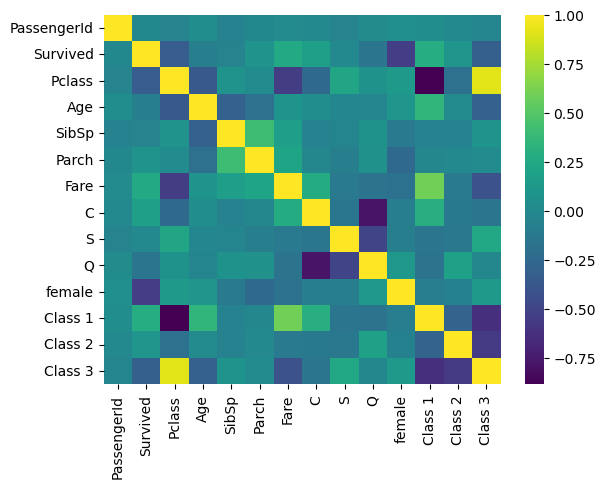

In [10]:
#Understand correlations of variables
#The database seems to have a majority of people who perished
#The PClass (ticket class) seems to be concentrated more on 2nd and third class (cheaper tickets)
 
#I am interested in seeing how the variables are correlated
#Mostly interested in correlation to survived
sns.heatmap(train_df.loc[:, ~train_df.columns.isin(['Name', 'Ticket', 'Cabin'])].corr(),cmap="viridis")
plt.show()

In [11]:
#Because I will be plotting multiple times similar variables, and I like to keep colours consistent among plots
#I will create a dictionary with variable number and the value is the colour I have assigned
rel_vars = ["Survived","Pclass","female","SibSp","Parch","Fare","S","Q","C"]
col_dict = {"Survived":"cyan","Pclass":"blue","female":"green","SibSp":"teal","Parch":"red","Fare":"paleturquoise",
           "S":"darkorange","Q":"fuchsia","C":"sandybrown"}

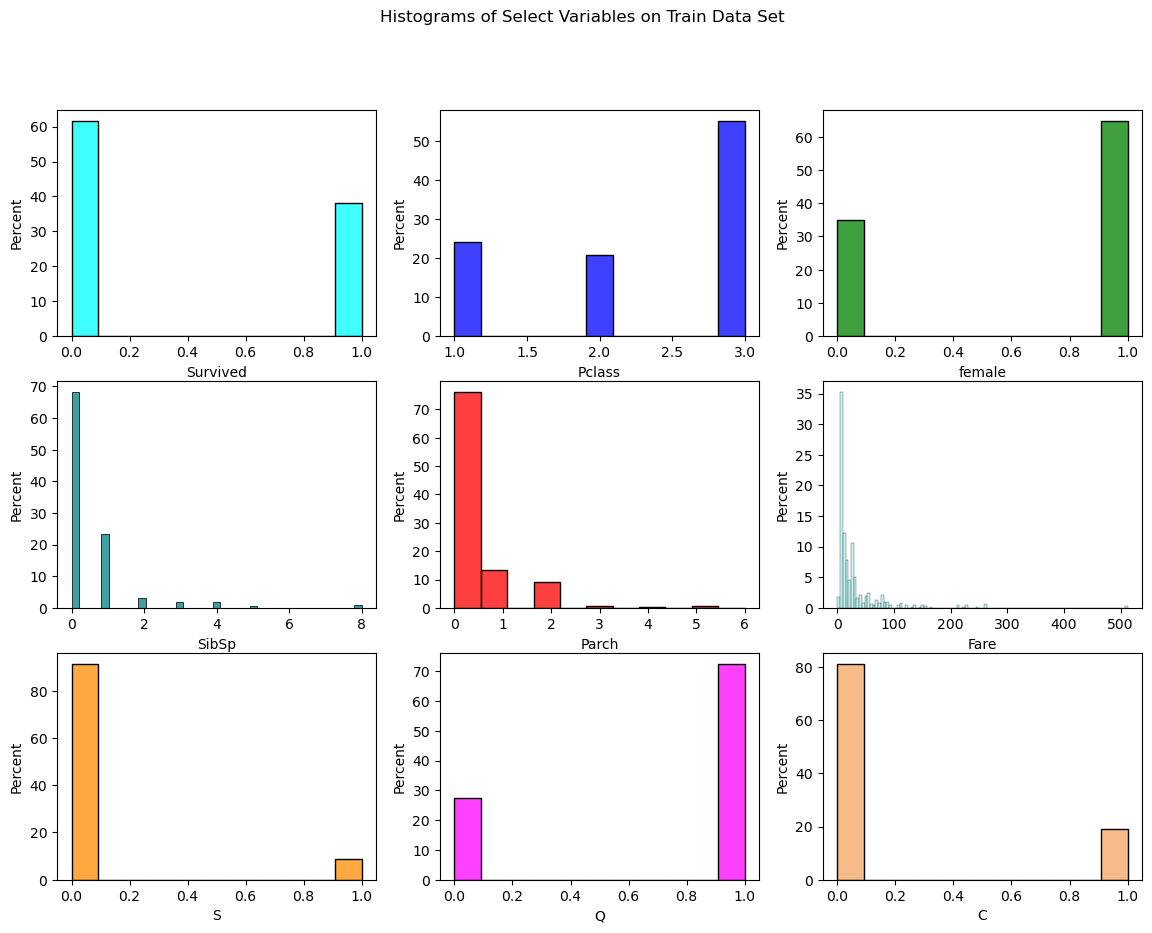

In [12]:
#TODO, poner graficos relevantes lado a lado
#Visualize the distribution of some variables

fig, axs = plt.subplots(3, 3, figsize=(14, 10))

#Create counters for the axs position
cont_row = 0
cont_col = 0
for var in rel_vars:
    sns.histplot(data=train_df, x=var, color=col_dict[var], stat = 'percent', ax=axs[cont_row, cont_col])
    cont_col += 1
    #Once it gets to three, reset
    if cont_col == 3:
        cont_col = 0
        #increment the row
        cont_row += 1
        
fig.suptitle("Histograms of Select Variables on Train Data Set")

plt.show()

In [13]:
#There is a very evident outlier in the fare column
#I want to see it in more depth
train_df['Fare'].describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [14]:
#The jump from 97th to 98th quantile is very evident
#I will remove those observations from consideration later down the road
quant97 = train_df['Fare'].quantile(0.97)

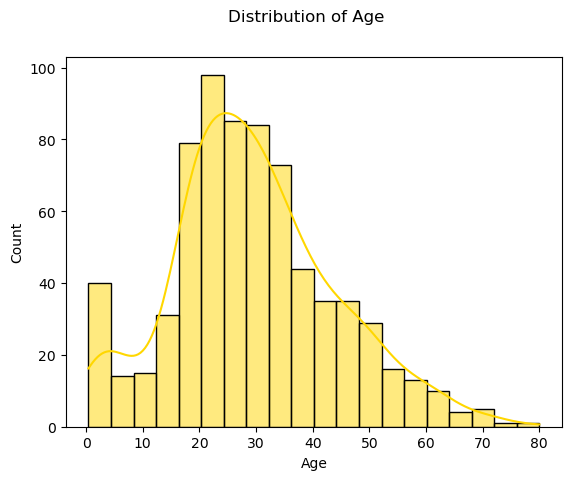

In [15]:
#AI now turn my attention to understanding how to impute age
#A simple way would be by assigning the mean, however that may skew my results
fig = plt.figure()
sns.histplot(data=train_df, x="Age", kde=True, color="gold")
fig.suptitle('Distribution of Age')
plt.show()

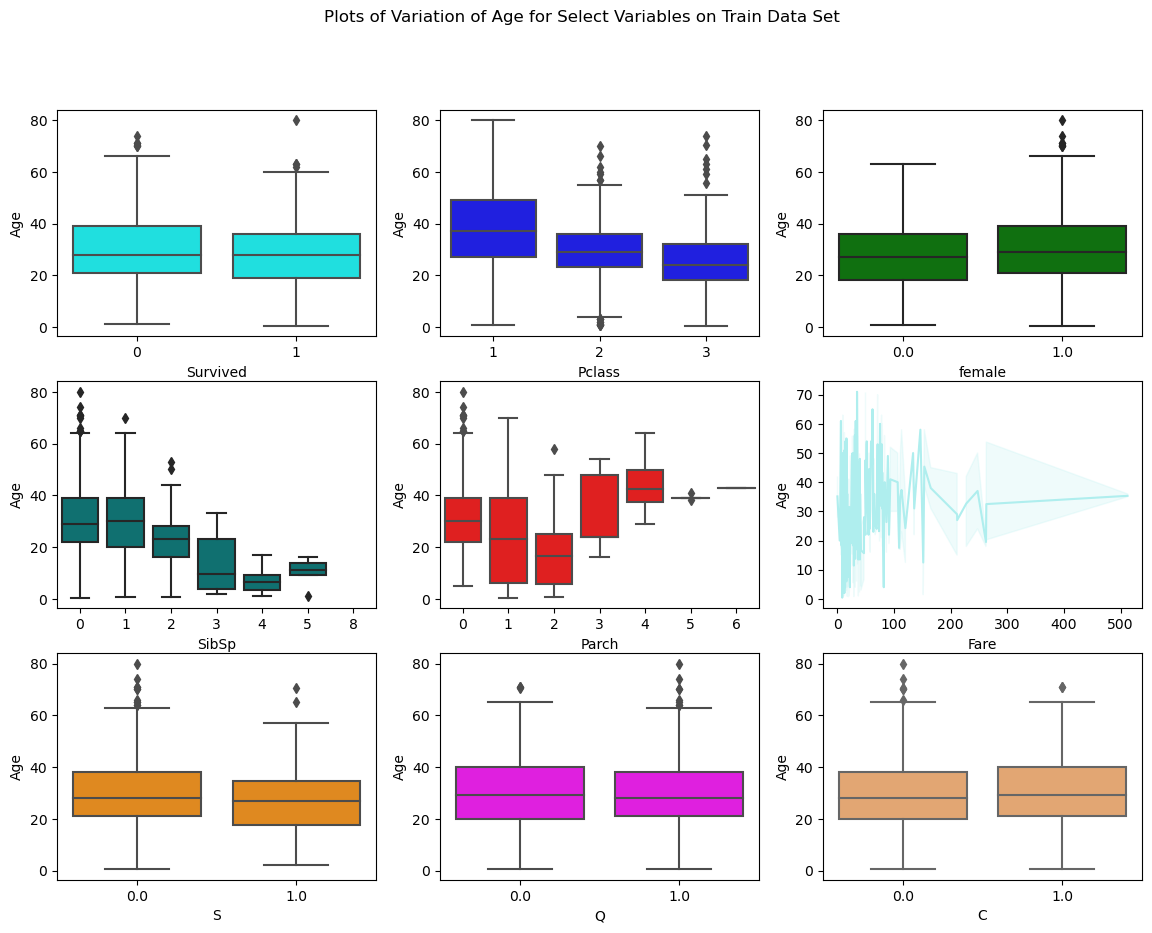

In [16]:
#The distribution seems somewhat Gaussian, with a sizable amount of mass to the left of 10 as well, most likely
#because of infants

#I am interested in understanding how age distributes according to the categories, I have to visualize if it varies
#depending on groups

fig, axs = plt.subplots(3, 3, figsize=(14, 10))

cont_row = 0
cont_col = 0
for var in rel_vars:
    #Do a boxplot for all except for fare because it has too many values
    if var != "Fare":
        sns.boxplot(data=train_df, x=var, y = "Age", color=col_dict[var], ax=axs[cont_row, cont_col])
    else:
        sns.lineplot(data=train_df, x=var, y = "Age", color=col_dict[var], ax=axs[cont_row, cont_col])
    #Update counter
    cont_col += 1
    #Once it gets to three, reset
    if cont_col == 3:
        cont_col = 0
        #increment the row
        cont_row += 1

fig.suptitle("Plots of Variation of Age for Select Variables on Train Data Set")


plt.show()

In [17]:
#The plots show a lot of variation for the top 3 variables
#There is some slight variation in the others, but the distributions do not look too different
#Because fare seems to be too noisy I will not consider it for my variable of fitting age with other variables
#This makes me think that I can estimate age based on other parameters, I will analyze what happens with the data
#as given before trying to estimate a best fit for the age

In [18]:
#To understand the differences between groups with missing age, I segment depending on their variables
#First create indicator for missing age
train_df['NA_Age'] = np.where(train_df['Age'].isnull(),1,0)
#Put it in the relevant variables criteria
rel_vars.append('NA_Age')
#Look at mean distribution
train_df[rel_vars].groupby('NA_Age').mean()

,Survived,Pclass,female,SibSp,Parch,Fare,S,Q,C
NA_Age,,,,,,,,,
0,0.404494,2.240169,0.636236,0.514045,0.432584,34.567251,0.039326,0.778090,0.182584
1,0.293785,2.598870,0.700565,0.564972,0.180791,22.158567,0.276836,0.508475,0.214689


In [19]:
#Look at std dev
train_df[rel_vars].groupby('NA_Age').std()

,Survived,Pclass,female,SibSp,Parch,Fare,S,Q,C
NA_Age,,,,,,,,,
0,0.491139,0.836854,0.48142,0.930692,0.854181,52.938648,0.194506,0.415823,0.386597
1,0.456787,0.763216,0.45931,1.626316,0.534145,31.874608,0.448704,0.501346,0.411771


In [20]:
#Remove NA_Age from the dictionary
rel_vars.remove('NA_Age')

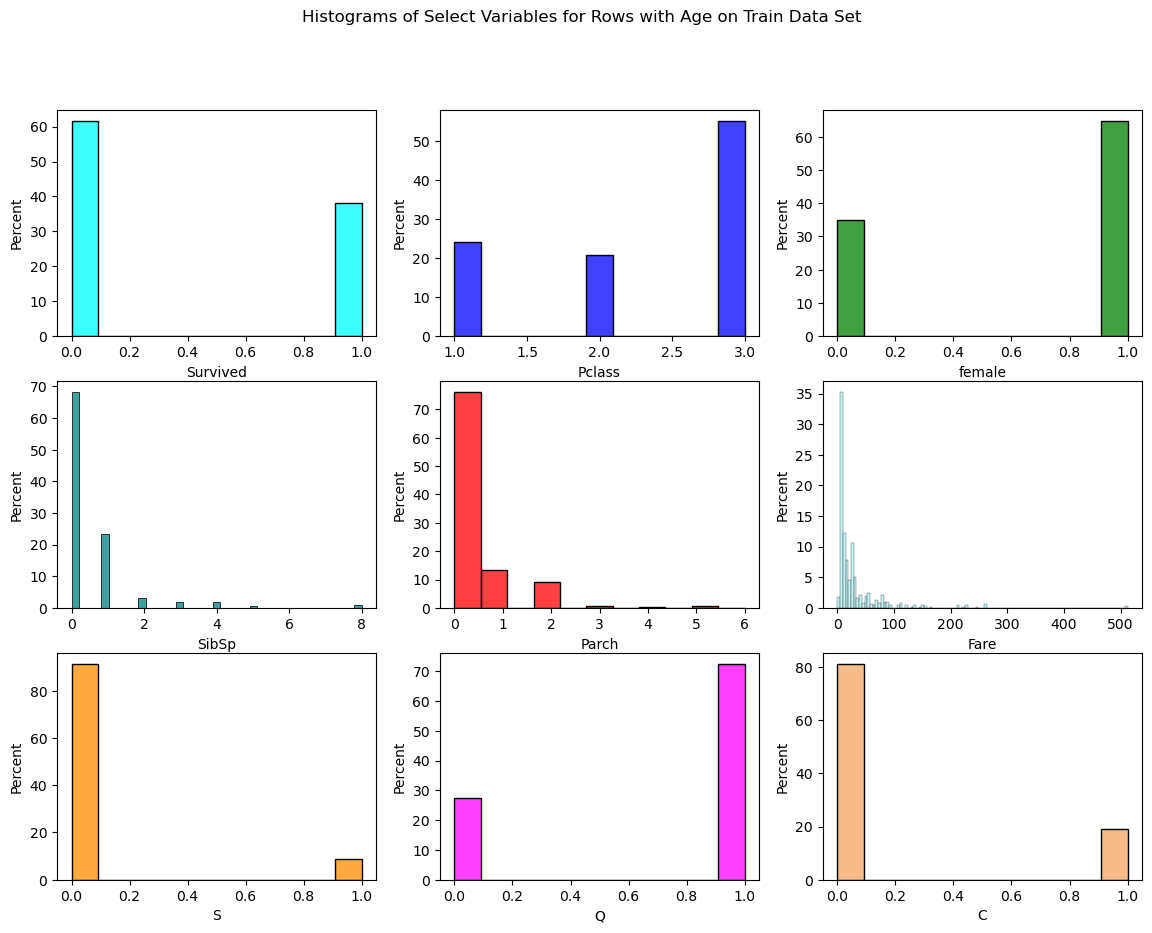

In [21]:
#The results show that there are more people who survived in the non-missing age part of the dataframe than in the
#rows where it is missing
#Pclass seems to be mostly equal
#There is some difference in female, with more of those having the age
#Parch shows a great difference, Fare does too
#The distribution of the embarked entries: S,Q,C is disimilar as well, specially in the S and C columns

#What does the dataframe with missing age look like? Maybe there is a pattern to understand there
#I create a temporary variable with missing age to use as hue in the histograms

fig, axs = plt.subplots(3, 3, figsize=(14, 10))

cont_row = 0
cont_col = 0
for var in rel_vars:
    #Do a boxplot for all except for fare because it has too many values
    sns.histplot(data=train_df, x=var, color=col_dict[var], stat='percent', 
                 ax=axs[cont_row, cont_col])
    #Update counter
    cont_col += 1
    #Once it gets to three, reset
    if cont_col == 3:
        cont_col = 0
        #increment the row
        cont_row += 1

fig.suptitle("Histograms of Select Variables for Rows with Age on Train Data Set")

plt.show()

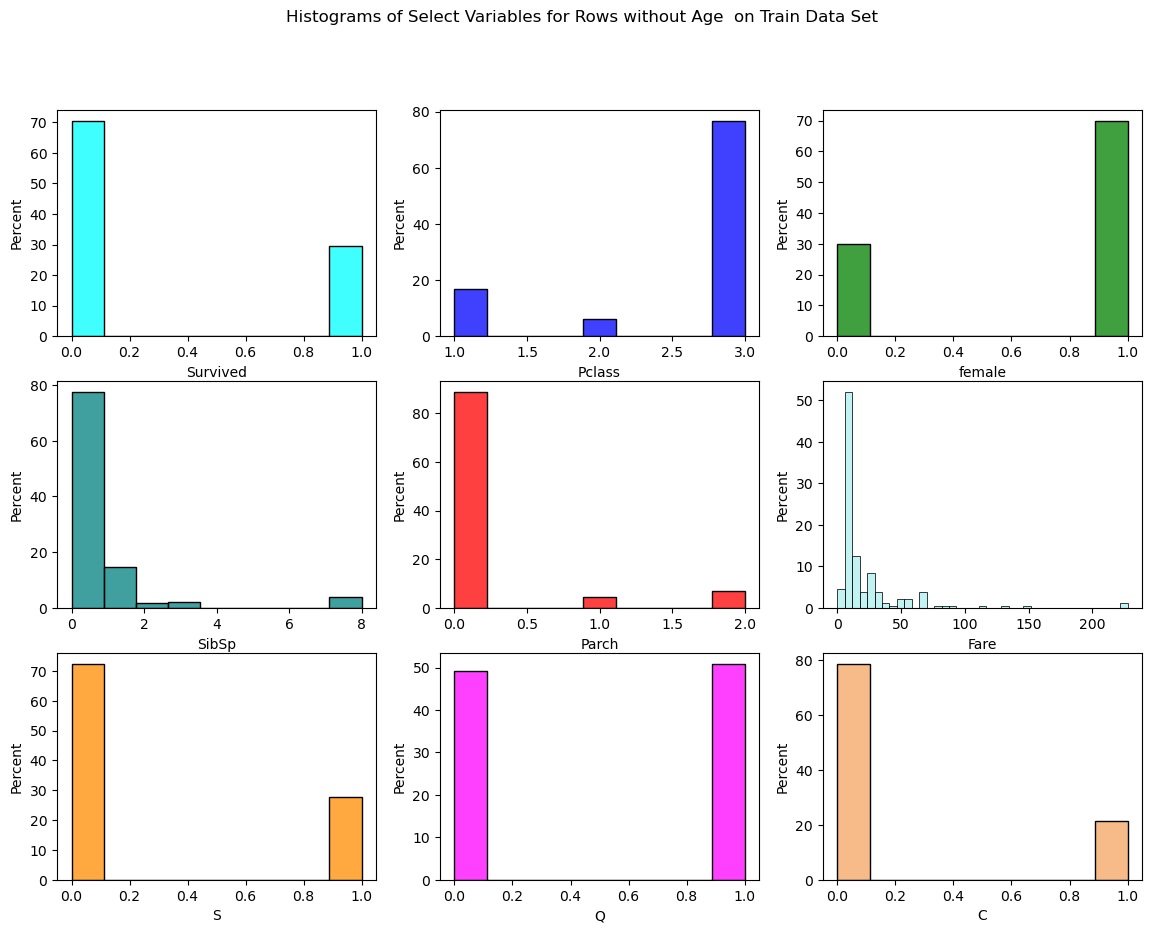

In [22]:
#Visualize for those entries with the age missing

fig, axs = plt.subplots(3, 3, figsize=(14, 10))

cont_row = 0
cont_col = 0
for var in rel_vars:
    #Do a boxplot for all except for fare because it has too many values
    sns.histplot(data=train_df[train_df['NA_Age'] == 1], x=var, color=col_dict[var], stat='percent', 
                 ax=axs[cont_row, cont_col])
    #Update counter
    cont_col += 1
    #Once it gets to three, reset
    if cont_col == 3:
        cont_col = 0
        #increment the row
        cont_row += 1

fig.suptitle("Histograms of Select Variables for Rows without Age  on Train Data Set")

plt.show()

In [23]:
#This provides a visual representation of what I commented on

#Based on the figures and mean data, I will create a match based on the columns with the most variation
#I use cosine dist as my distance metric
from scipy.spatial.distance import cdist

#Initialize columns to compare
comparison_columns = ['female','Parch','Fare','S', 'Q', 'C']

#Define the routine as a function
def AgeImputter(df,columns_to_compare):
    #Save rows from entries with missing age
    missing_age_rows = df[df['Age'].isnull()]

    # Calculate cosine distances between rows with missing 'Age' and all other rows
    distances = cdist(missing_age_rows[columns_to_compare], df[~(df['Age'].isnull())][columns_to_compare], metric='cosine')

    # Find the index of the most similar row for each row with missing 'Age'
    most_similar_indices = distances.argmin(axis=1)

    #Rewrite
    missing_age_rows['Age'] = df.loc[most_similar_indices,'Age'].values

    # Update the original DataFrame with the imputed values
    df.update(missing_age_rows)
    
#From experimentation I found that running this routine twice gets rid of almost every missing value
#The index reset makes it hard to operate in this area right now
AgeImputter(train_df,comparison_columns)
AgeImputter(train_df,comparison_columns)

In [24]:
#Visualize if it worked
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Age          888 non-null    float64
 5   SibSp        889 non-null    int64  
 6   Parch        889 non-null    int64  
 7   Ticket       889 non-null    object 
 8   Fare         889 non-null    float64
 9   Cabin        202 non-null    object 
 10  C            889 non-null    float64
 11  S            889 non-null    float64
 12  Q            889 non-null    float64
 13  female       889 non-null    float64
 14  Class 1      889 non-null    float64
 15  Class 2      889 non-null    float64
 16  Class 3      889 non-null    float64
 17  NA_Age       889 non-null    int64  
dtypes: float64(9), int64(6), object(3)
memory usage: 1

In [25]:
#There is only one NA, I will fill it with the mean since it is only one entry
train_df['Age'].fillna(value=np.mean(train_df['Age']), inplace=True) 
#Transform into int
train_df['Age'] = train_df['Age'].astype(int)

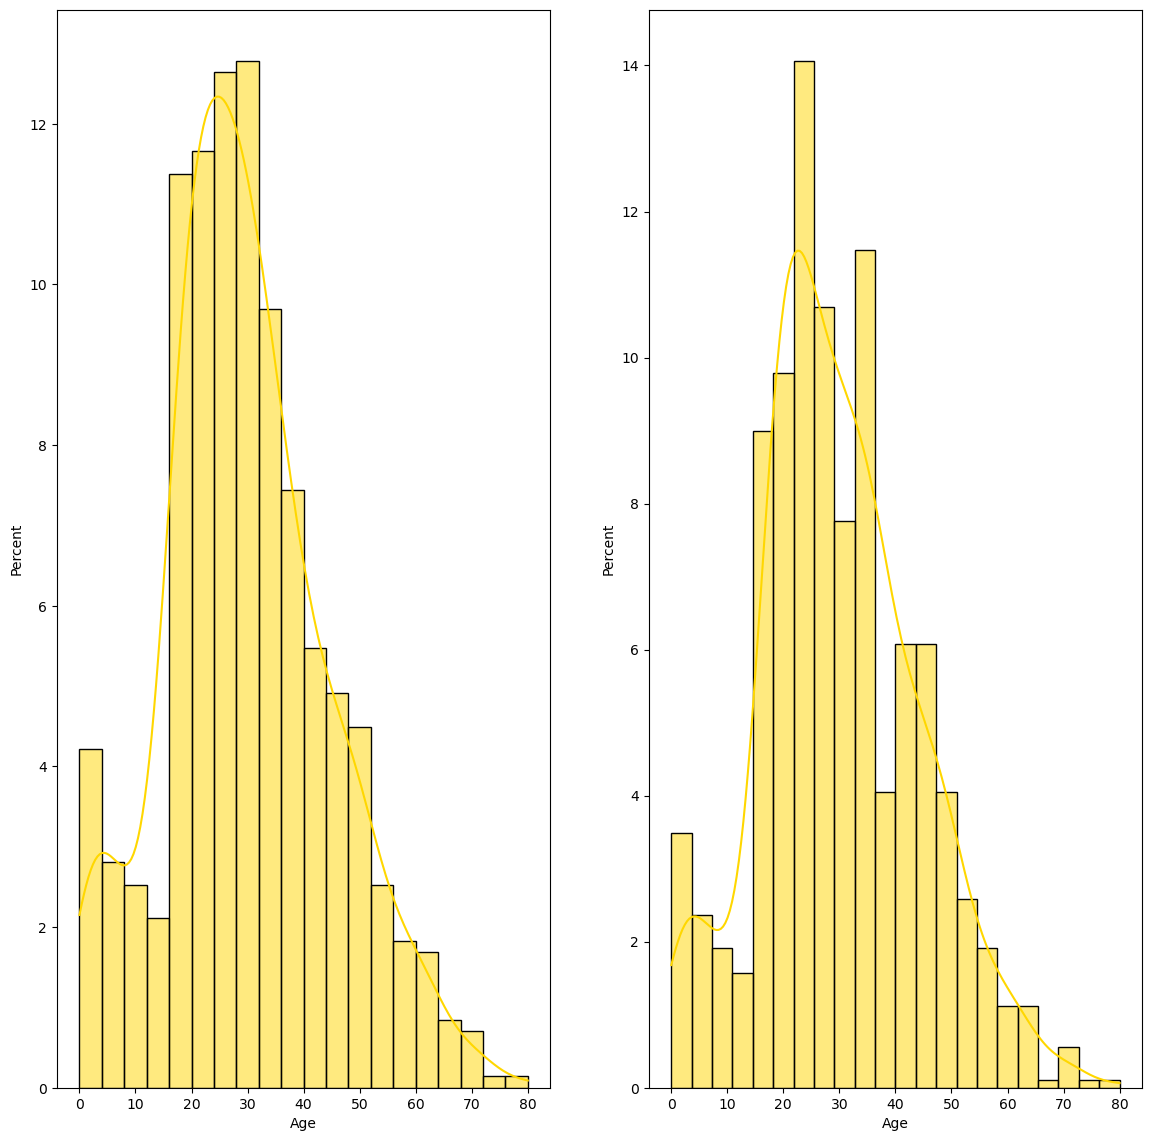

<Figure size 640x480 with 0 Axes>

In [26]:
#See if the distribution changed significantly
fig, axs = plt.subplots(1, 2, figsize=(14, 14))

fig = plt.figure()
sns.histplot(data=train_df[train_df['NA_Age']==0], x="Age", kde=True, color="gold",ax=axs[0],stat="percent")
sns.histplot(data=train_df, x="Age", kde=True, color="gold",ax=axs[1],stat="percent")

fig.suptitle('Distribution of Age After Filing NAs With Regression')
plt.show()

In [27]:
#The results are pretty convincing, the distribution did not change significantly

#Having filled Age, I turn my attention to processing other variables
#Recall that SibSp and Parch refer to familial relationships
#SibSp refers to those that have siblings and spouses
#Parch to those that have parents and children

#From the plots above, there is sizable variation in the number of filial relationships
#It is interesting to know whether the number of relatives matter, or if it only matters whether there is one or the other

#I could make an indicator variable for each possible value of SibSp and Parch, to capture how different the variable behaves
#depending on number. However, that may be too detailed and just serve to bloat the model

#I opt for combining them into a family variable. Regardless of whether it is parents or any other filial
#relationship, if there is a 

In [28]:
#I first define the class, execute it in the train data frame and then create a pipeline to run it in the test dataframe
class FilialEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        #Work with the filial variables
        X['Family'] = np.where(X['SibSp'] + X['Parch'] > 0,1,0)        
        return X

In [29]:
#Adapt the database
train_df = FilialEncoder().fit_transform(train_df)

In [30]:
#I turn my attention to the cabin column
#This indicates the cabin the passenger occupied. It can be related to the class and ticket. However, the actual location
#of their cabin may be relevant
print(set(train_df['Cabin']))

{'B20', 'A26', 'D30', 'B79', 'A10', 'D15', 'C124', 'E31', 'B22', 'D50', 'C82', 'C49', 'D26', 'A16', 'E38', 'C93', 'B78', 'C91', 'B37', 'E121', 'B71', 'D56', 'B30', 'A7', 'B4', 'D28', 'D20', 'D46', 'D37', 'C87', 'A36', 'C47', 'E63', 'E58', 'C78', 'C118', 'E24', 'D19', 'E46', 'C90', 'D49', 'D33', 'D35', 'D21', 'A19', 'E36', 'E10', 'B57 B59 B63 B66', 'C23 C25 C27', 'C30', 'C86', 'C62 C64', 'D11', 'B38', 'C125', 'C85', 'A6', 'C110', 'C22 C26', 'C46', 'B77', 'E101', 'E67', 'C128', 'A20', 'B101', 'C54', 'F38', 'C123', 'C68', 'T', 'E17', 'B69', 'F4', 'C50', 'F E69', 'C45', 'B5', 'D6', 'C148', 'C126', 'C2', 'B86', 'C101', 'B35', 'A34', 'A32', 'B94', 'F2', 'A14', 'B96 B98', 'A23', 'C111', 'B41', 'D36', 'C106', 'E25', 'F G73', 'D17', 'D7', 'E8', 'B19', nan, 'C52', 'D', 'F G63', 'C65', 'B58 B60', 'C95', 'A5', 'B73', 'D48', 'A31', 'C32', 'B49', 'D45', 'B42', 'E12', 'E49', 'E77', 'E68', 'F33', 'D47', 'C83', 'D10 D12', 'E33', 'E50', 'C7', 'C104', 'E44', 'B51 B53 B55', 'B50', 'B3', 'E34', 'D9', 'G6',

In [31]:
#It seems that each cabin has a prefix letter or is nan. I will use a placeholder value for nan
#I assume it means that the cabin was unnumbered
#My function extracts the prefix of the cabin and replaces the nans with a value
class CabinEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        #First encode the nans
        X['Cabin'] = np.where(pd.isnull(X['Cabin']),'N',X['Cabin'])
        #Encode first letter from code
        X['Cabin'] = X['Cabin'].astype(str).str[0]
        #Encode into columns
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Cabin']]).toarray()
        #Define embarkment categories as the column names
        column_names = list(set(X['Cabin']))
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        return X

<Axes: xlabel='Cabin'>

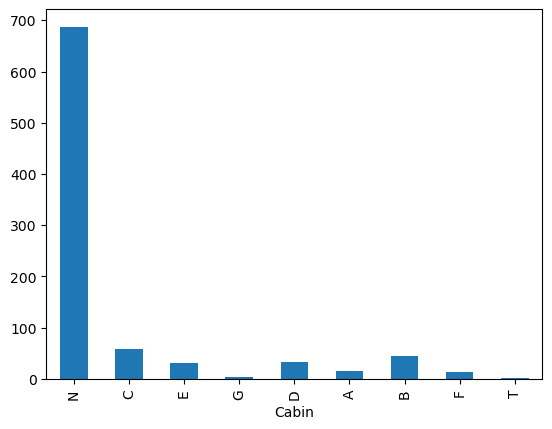

In [32]:
#Encode
train_df = CabinEncoder().fit_transform(train_df)
#Visualize
train_df['Cabin'].value_counts(sort=False).plot(kind='bar')
#Can clearly tell that the NA equivalent column is over represented

In [33]:
#For name
#We may be able to get some nobility titles out of this column
#Visualize some names
train_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
884                                Montvila, Rev. Juozas
885                         Graham, Miss. Margaret Edith
886             Johnston, Miss. Catherine Helen "Carrie"
887                                Behr, Mr. Karl Howell
888                                  Dooley, Mr. Patrick
Name: Name, Length: 889, dtype: object

In [34]:
import re
#The title seems to be after a coma and before a dot
#I will search for the string between both of those characters for each name
class TitleEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        #Define comma and dot variables
        comma = ", "
        dot = "."
        #Find values in between
        X['Title'] = [text[text.index(comma)+len(comma):text.index(dot)] for text in X['Name']]
        #Encode into columns
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Title']]).toarray()
        #Define embarkment categories as the column names
        column_names = list(set(X['Title']))
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        return X

<Axes: xlabel='Title'>

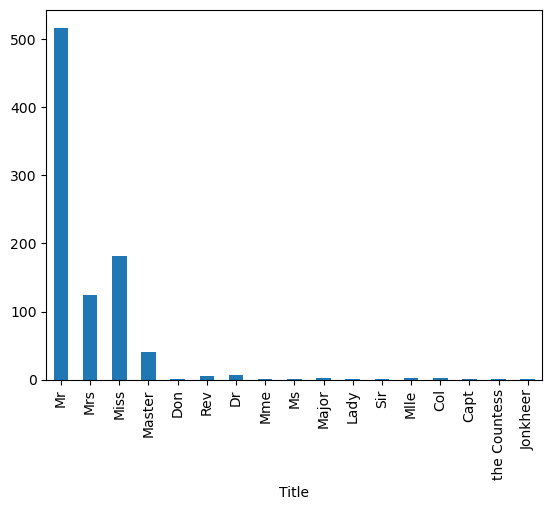

In [35]:
#Encode
train_df = TitleEncoder().fit_transform(train_df)
#Visualize
train_df['Title'].value_counts(sort=False).plot(kind='bar')
#Can clearly tell that the NA equivalent column is over represented

In [36]:
#Some categories are just a different rephrase of the others, for example Mme is just another way of saying Ms or mrs
#I will combine them into one
train_df['Miss'] = train_df[['Mme','Ms','Mrs','Mlle']].sum(axis=1)
#I will make another column for infrequent values
train_df['Infrequent'] = train_df[['Jonkheer', 'the Countess','Capt','Col','Don','Dr','Rev','Sir','Major',
                                  'Lady']].sum(axis=1)

In [37]:
#Check they are indicator variables
train_df[['Miss','Infrequent']].describe()

,Miss,Infrequent
count,889.000000,889.000000
mean,0.005624,0.852643
std,0.074826,0.354661
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [38]:
#All in order, I will drop these columns
train_df.drop(['Mme','Ms','Mrs','Mlle','Jonkheer', 'the Countess','Capt','Col','Don','Dr','Rev','Sir','Major',
                                  'Lady'],axis=1,inplace=True)

In [39]:
#Ticket
#Ticket can be related to cabin and may be indicative of the position of the passenger in the vessel
#Because of how tricky it seems to match, I will ignore it and drop it
train_df.drop('Ticket',axis=1,inplace=True)

In [40]:
###### Clasification Preparation #########

#Having gone through the exploratory data analysis, I turn my attention to preparing the data for the different
#classification algorithms I will use

#Do a stratified shuffle split to have a train and dev set
#This is to ensure that both the train and dev datasets have the same distribution of relevant variables
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_indices, dev_indices in split.split(train_df, train_df[['Survived', 'Pclass','Family']]):
    strat_train_set = train_df.loc[train_indices]
    strat_dev_set = train_df.loc[dev_indices]

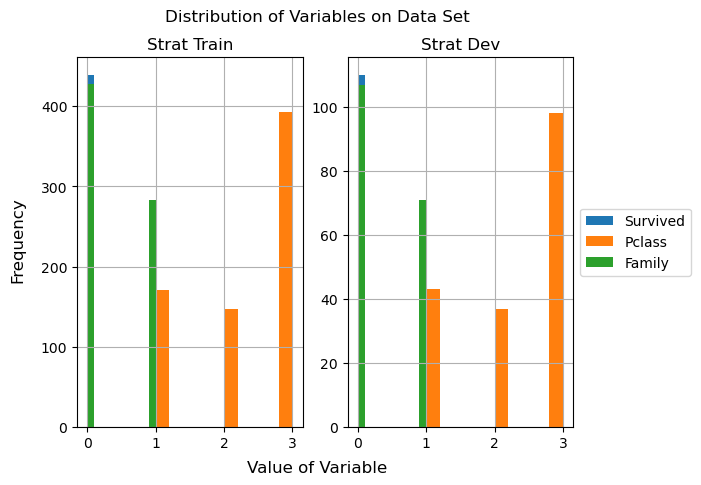

In [41]:
#Visualize distributions
#Create list with variables to plot
DistsVars = ['Survived','Pclass','Family']
#So it is ok!
fig = plt.figure()
#Initialize axis
ax1 = fig.add_subplot(1,2,1)
#Iterate over train set
for v in DistsVars:
    strat_train_set[v].hist(label=v)
#Initialize test axis
ax2 = fig.add_subplot(1,2,2)
#Iterate over test set
for v in DistsVars:
    strat_dev_set[v].hist(label=v)
#Titles
fig.suptitle("Distribution of Variables on Data Set")
ax1.title.set_text('Strat Train')
ax2.title.set_text('Strat Dev')
fig.supylabel("Frequency")
fig.supxlabel("Value of Variable")

box = ax2.get_position()
# Put a legend to the right of the current axis
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [42]:
#The distributions seem ok!
#Because some of the variables seem to be categorical and I will need to do further encoding, I will save the 
#passenger IDs for the train and dev sets so I can process all the data in the full set and then just create
#sub samples based on the passenger IDs
PassengerID_Strat_Train = strat_train_set['PassengerId']
PassengerID_Strat_Dev = strat_dev_set['PassengerId']

In [43]:
#Drop irrelevant features
class SecondFeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Ignore errors if there are Nans
        return X.drop(["Pclass","NA_Age","Cabin","Ticket","Name","Title","SibSp","Parch"], axis = 1, errors="ignore")

In [44]:
#Drop the variables
train_df = SecondFeatureDropper().fit_transform(train_df)
#Drop the outlier of fare
train_df = train_df[train_df['Fare']<= quant97]
#Retrieve the Ids for strat train and strat test datasets
strat_train_set = train_df[train_df['PassengerId'].isin(PassengerID_Strat_Train)]
strat_dev_set = train_df[train_df['PassengerId'].isin(PassengerID_Strat_Dev)]

In [45]:
#Create second pipeline for test set FilialEncoder
Secondpipeline = Pipeline([("filialencoder",FilialEncoder()),
                    ("cabinencoder",CabinEncoder()),
                    ("titleencoder",TitleEncoder()),
                    ("featuredropper",SecondFeatureDropper())])

In [46]:
#Create variables as numerical arrays for training
X_strat_train = strat_train_set.drop(['Survived'],axis=1)
y_strat_train = strat_train_set['Survived']
y_strat_train = y_strat_train.to_numpy()
#Do for dev set
X_dev = strat_dev_set.drop(['Survived'],axis=1)
y_dev = strat_dev_set['Survived']
y_data_dev = y_dev.to_numpy()
#For all of the train data
#Do the same for all of the data
X_full_train = train_df.drop(['Survived'],axis=1)
y_full_train = train_df['Survived']
y_full_train = y_full_train.to_numpy()

In [47]:
#Before working with the predictors, it is useful to pre-process the test data so it is easier to access later on
#Import the test data
test_df = pd.read_csv("titanic/test.csv")
#Check its distribution
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [48]:
#There are NAs for age and one NA for fare
#Fill Fare's na
test_df['Fare'].fillna(value=np.mean(test_df['Fare']), inplace=True) 
#For age, I do the same as before
#Create NA_Age column
test_df['NA_Age'] = np.where(test_df['Age'].isnull(),1,0)
#First, apply the first pipeline
test_df = pipeline.fit_transform(test_df)

In [49]:
#Run it twice and the last value fill with mean
AgeImputter(test_df,comparison_columns)
AgeImputter(test_df,comparison_columns)
test_df['Age'].fillna(value=np.mean(test_df['Age']), inplace=True) 

In [50]:
#Check if it worked
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         418 non-null    float64
 8   Cabin        91 non-null     object 
 9   NA_Age       418 non-null    int64  
 10  S            418 non-null    float64
 11  C            418 non-null    float64
 12  Q            418 non-null    float64
 13  female       418 non-null    float64
 14  Class 1      418 non-null    float64
 15  Class 2      418 non-null    float64
 16  Class 3      418 non-null    float64
dtypes: float64(9), int64(5), object(3)
memory usage: 55.6+ KB


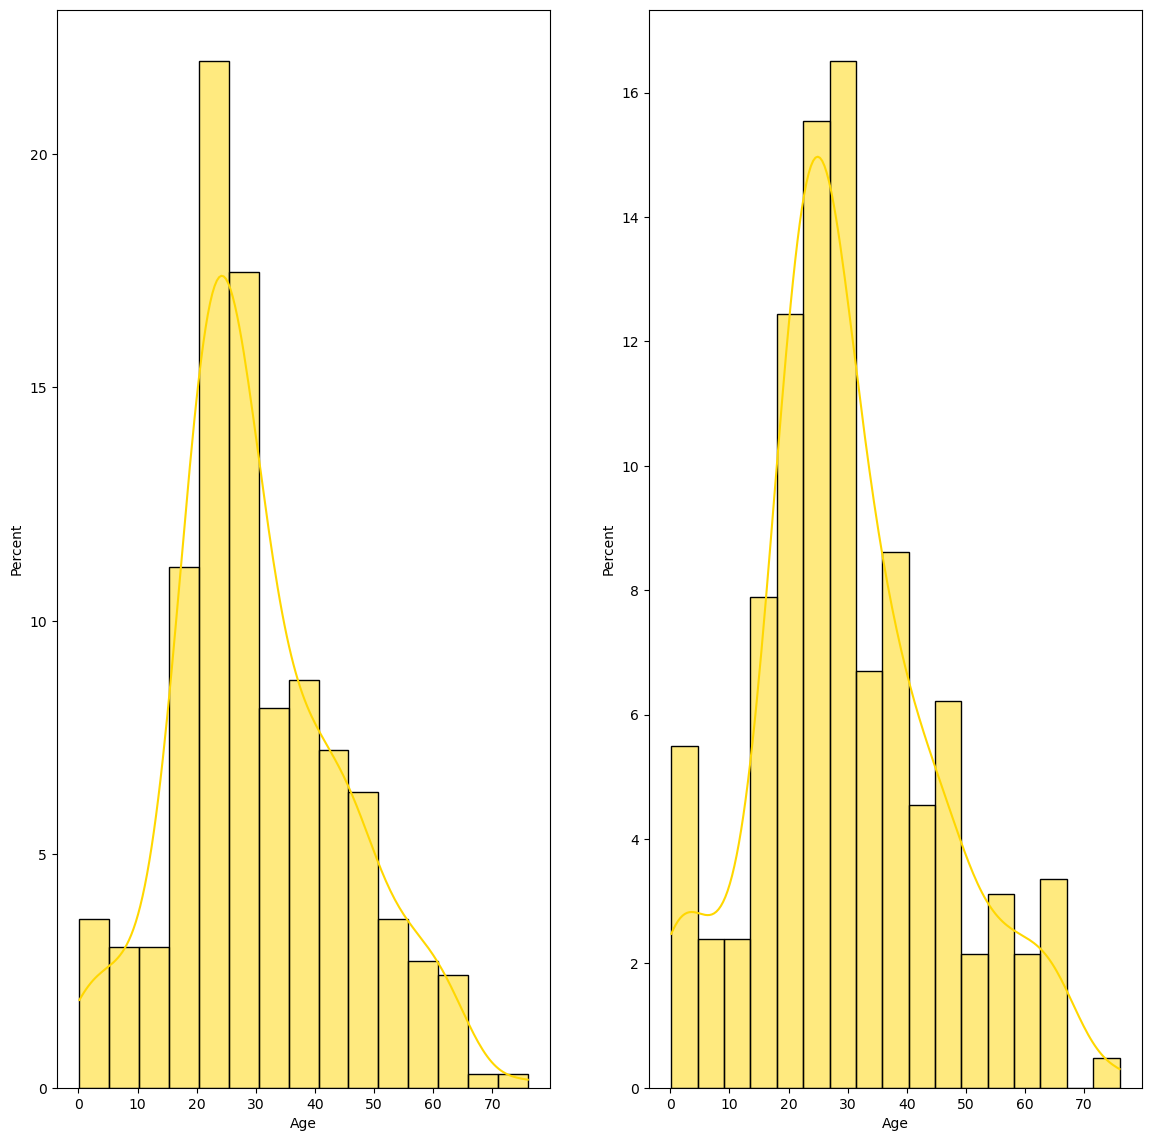

<Figure size 640x480 with 0 Axes>

In [51]:
#See if the distribution changed by a lot
fig, axs = plt.subplots(1, 2, figsize=(14, 14))

fig = plt.figure()
sns.histplot(data=test_df[test_df['NA_Age']==0], x="Age", kde=True, color="gold",ax=axs[0],stat="percent")
sns.histplot(data=test_df, x="Age", kde=True, color="gold",ax=axs[1],stat="percent")

fig.suptitle('Distribution of Age After Filing NAs With Regression')
plt.show()

In [52]:
#Transform the data
test_df = Secondpipeline.fit_transform(test_df)

In [53]:
#Format
X_test = test_df

In [54]:
#Check that the columns are the same
#Do it both ways (this is not commutative)
print(set(X_test.columns) - set(X_full_train.columns))
print(set(X_full_train.columns) - set(X_test.columns))

{'Dona', 'Rev', 'Mrs', 'Col', 'Dr', 'Ms'}
{'T', 'Infrequent'}


In [55]:
#So the missing ones are the columns for the title class
X_test['Infrequent'] = X_test[['Dona','Rev','Dr','Col']].sum(axis=1)
X_test['Miss'] = X_test[['Miss','Ms','Mrs']].sum(axis=1)
#Drop the columns
X_test.drop(['Dona','Rev','Dr','Col','Ms','Mrs'],axis=1,inplace=True)

In [56]:
#Because T is just a placeholder category, I set it to zero
X_test['T'] = 0

In [57]:
#Prepare data
scaler = StandardScaler()
X_strat_train = scaler.fit_transform(X_strat_train)
#Scale
scaler = StandardScaler()
X_dev = scaler.fit_transform(X_dev)
scaler = StandardScaler()
X_full_train = scaler.fit_transform(X_full_train)
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [58]:
####### Random Forest ############

#Start with the default model and then iterate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


clf = RandomForestClassifier()
print(clf)
clf.fit(X_strat_train,y_strat_train)
clf.score(X_dev,y_dev)

RandomForestClassifier()


0.7965116279069767

In [59]:
#To tune my hyperparameters, I first conduct a gridsearch on a wide range of numbers
#Then, I will narrow the section of the grid in which I can find better performance

#Try to do a randomized search approach
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = np.arange(3,351)
# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = list(np.arange(2,101))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = np.arange(2,9)
# Minimum number of samples required at each leaf node
max_leaf_nodes = np.arange(3,47)
#Criterion
criteria = ['gini','entropy']
# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'max_leaf_nodes':max_leaf_nodes,
                'criterion':criteria}

In [60]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_random_grid, n_iter = 350, cv = 4, verbose=2, random_state=9, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_strat_train, y_strat_train)

Fitting 4 folds for each of 350 candidates, totalling 1400 fits
[CV] END criterion=gini, max_depth=69, max_features=None, max_leaf_nodes=38, min_samples_split=4, n_estimators=11; total time=   0.0s
[CV] END criterion=gini, max_depth=27, max_features=sqrt, max_leaf_nodes=8, min_samples_split=2, n_estimators=349; total time=   0.4s
[CV] END criterion=entropy, max_depth=19, max_features=None, max_leaf_nodes=38, min_samples_split=5, n_estimators=302; total time=   0.5s
[CV] END criterion=gini, max_depth=21, max_features=None, max_leaf_nodes=27, min_samples_split=3, n_estimators=52; total time=   0.1s
[CV] END criterion=entropy, max_depth=79, max_features=None, max_leaf_nodes=39, min_samples_split=4, n_estimators=140; total time=   0.2s
[CV] END criterion=entropy, max_depth=65, max_features=None, max_leaf_nodes=11, min_samples_split=6, n_estimators=286; total time=   0.4s
[CV] END criterion=gini, max_depth=81, max_features=sqrt, max_leaf_nodes=38, min_samples_split=5, n_estimators=235; tota

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=350,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, 31, ...],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24...
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
       289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
       302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
       315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327,
       328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340,
       341, 342, 343, 344, 345, 346, 347, 348, 349, 350])},
                   random_state=9, verbose=2)

In [61]:
#Retrieve the best estimator
rf_best_random = rf_random.best_estimator_
#Check parameters
print(rf_best_random)
#Check score
rf_best_random.score(X_dev,y_dev)

RandomForestClassifier(max_depth=37, max_leaf_nodes=44, min_samples_split=3,
                       n_estimators=39)


0.7848837209302325

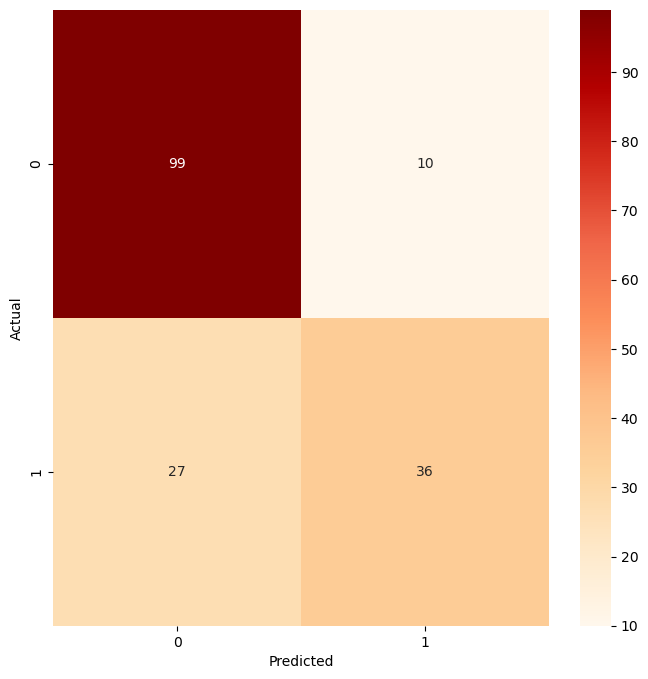

In [62]:
#Visualize the confusion matrix
#I create a function for easy representation and to use in other models
def ConfusionMatrixVisualizer(confusion_matrix):
    #Process the confusion matrix and plot as a heatmap
    df_cm = pd.DataFrame(confusion_matrix)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True,cmap="OrRd")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
#Create the confusion matrix itself
rf_cm = confusion_matrix(y_dev, rf_best_random.predict(X_dev))
ConfusionMatrixVisualizer(rf_cm)

In [63]:
#The model seems to be over-predicting 0s
#Get a classification report to understand the other metrics
print(classification_report(y_dev, rf_best_random.predict(X_dev)))

              precision    recall  f1-score   support

           0       0.79      0.91      0.84       109
           1       0.78      0.57      0.66        63

    accuracy                           0.78       172
   macro avg       0.78      0.74      0.75       172
weighted avg       0.78      0.78      0.78       172



In [64]:
#Recall is somewhat lacking in the survived sample
#Part of it can also be the size of the dev sample
# I know find the best hyperparameters for the whole sample
#I use the random grid results as the basis for my search
clf = RandomForestClassifier()

#prod_rf_param_grid = [
#    {"n_estimators": [50,60,70,80,90,100], 
#     "max_features": ['log2'],
#     "min_samples_split": [5,6,7,8],
#    "max_leaf_nodes": [40,45,50,55,60]}
#]

prod_rf_param_grid = [
    {"n_estimators": [40,45,50,60,100,200,300],
    "max_depth": [35,40,45,50,55,60], 
     "min_samples_split": [6,7,8],
    "max_leaf_nodes": [40,45,50,55,60]}
]

#Do a grid search
prod_rf_grid_search = GridSearchCV(clf, prod_rf_param_grid, cv=4, scoring="accuracy", return_train_score=True,verbose=10)
prod_rf_grid_search.fit(X_full_train,y_full_train)

Fitting 4 folds for each of 630 candidates, totalling 2520 fits
[CV 1/4; 1/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=6, n_estimators=40
[CV 1/4; 1/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=6, n_estimators=40;, score=(train=0.912, test=0.750) total time=   0.1s
[CV 2/4; 1/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=6, n_estimators=40
[CV 2/4; 1/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=6, n_estimators=40;, score=(train=0.900, test=0.815) total time=   0.0s
[CV 3/4; 1/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=6, n_estimators=40
[CV 3/4; 1/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=6, n_estimators=40;, score=(train=0.890, test=0.810) total time=   0.0s
[CV 4/4; 1/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=6, n_estimators=40
[CV 4/4; 1/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=6, n_estimators=40;, score=(train=0.890, test=0.778) total time=   0

[CV 4/4; 9/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=7, n_estimators=45;, score=(train=0.898, test=0.796) total time=   0.0s
[CV 1/4; 10/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=7, n_estimators=50
[CV 1/4; 10/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=7, n_estimators=50;, score=(train=0.909, test=0.750) total time=   0.0s
[CV 2/4; 10/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=7, n_estimators=50
[CV 2/4; 10/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=7, n_estimators=50;, score=(train=0.907, test=0.824) total time=   0.0s
[CV 3/4; 10/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=7, n_estimators=50
[CV 3/4; 10/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=7, n_estimators=50;, score=(train=0.890, test=0.829) total time=   0.0s
[CV 4/4; 10/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=7, n_estimators=50
[CV 4/4; 10/630] END max_depth=35, max_leaf_nodes=40,

[CV 4/4; 18/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=8, n_estimators=60;, score=(train=0.900, test=0.782) total time=   0.0s
[CV 1/4; 19/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=8, n_estimators=100
[CV 1/4; 19/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=8, n_estimators=100;, score=(train=0.906, test=0.755) total time=   0.1s
[CV 2/4; 19/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=8, n_estimators=100
[CV 2/4; 19/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=8, n_estimators=100;, score=(train=0.898, test=0.815) total time=   0.1s
[CV 3/4; 19/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=8, n_estimators=100
[CV 3/4; 19/630] END max_depth=35, max_leaf_nodes=40, min_samples_split=8, n_estimators=100;, score=(train=0.892, test=0.819) total time=   0.1s
[CV 4/4; 19/630] START max_depth=35, max_leaf_nodes=40, min_samples_split=8, n_estimators=100
[CV 4/4; 19/630] END max_depth=35, max_leaf_n

[CV 4/4; 27/630] END max_depth=35, max_leaf_nodes=45, min_samples_split=6, n_estimators=200;, score=(train=0.907, test=0.796) total time=   0.1s
[CV 1/4; 28/630] START max_depth=35, max_leaf_nodes=45, min_samples_split=6, n_estimators=300
[CV 1/4; 28/630] END max_depth=35, max_leaf_nodes=45, min_samples_split=6, n_estimators=300;, score=(train=0.920, test=0.759) total time=   0.2s
[CV 2/4; 28/630] START max_depth=35, max_leaf_nodes=45, min_samples_split=6, n_estimators=300
[CV 2/4; 28/630] END max_depth=35, max_leaf_nodes=45, min_samples_split=6, n_estimators=300;, score=(train=0.918, test=0.829) total time=   0.2s
[CV 3/4; 28/630] START max_depth=35, max_leaf_nodes=45, min_samples_split=6, n_estimators=300
[CV 3/4; 28/630] END max_depth=35, max_leaf_nodes=45, min_samples_split=6, n_estimators=300;, score=(train=0.907, test=0.819) total time=   0.2s
[CV 4/4; 28/630] START max_depth=35, max_leaf_nodes=45, min_samples_split=6, n_estimators=300
[CV 4/4; 28/630] END max_depth=35, max_leaf_

[CV 4/4; 37/630] END max_depth=35, max_leaf_nodes=45, min_samples_split=8, n_estimators=45;, score=(train=0.894, test=0.810) total time=   0.0s
[CV 1/4; 38/630] START max_depth=35, max_leaf_nodes=45, min_samples_split=8, n_estimators=50
[CV 1/4; 38/630] END max_depth=35, max_leaf_nodes=45, min_samples_split=8, n_estimators=50;, score=(train=0.903, test=0.741) total time=   0.0s
[CV 2/4; 38/630] START max_depth=35, max_leaf_nodes=45, min_samples_split=8, n_estimators=50
[CV 2/4; 38/630] END max_depth=35, max_leaf_nodes=45, min_samples_split=8, n_estimators=50;, score=(train=0.900, test=0.852) total time=   0.0s
[CV 3/4; 38/630] START max_depth=35, max_leaf_nodes=45, min_samples_split=8, n_estimators=50
[CV 3/4; 38/630] END max_depth=35, max_leaf_nodes=45, min_samples_split=8, n_estimators=50;, score=(train=0.894, test=0.829) total time=   0.0s
[CV 4/4; 38/630] START max_depth=35, max_leaf_nodes=45, min_samples_split=8, n_estimators=50
[CV 4/4; 38/630] END max_depth=35, max_leaf_nodes=45

[CV 3/4; 46/630] END max_depth=35, max_leaf_nodes=50, min_samples_split=6, n_estimators=60;, score=(train=0.906, test=0.824) total time=   0.0s
[CV 4/4; 46/630] START max_depth=35, max_leaf_nodes=50, min_samples_split=6, n_estimators=60
[CV 4/4; 46/630] END max_depth=35, max_leaf_nodes=50, min_samples_split=6, n_estimators=60;, score=(train=0.904, test=0.782) total time=   0.0s
[CV 1/4; 47/630] START max_depth=35, max_leaf_nodes=50, min_samples_split=6, n_estimators=100
[CV 1/4; 47/630] END max_depth=35, max_leaf_nodes=50, min_samples_split=6, n_estimators=100;, score=(train=0.923, test=0.773) total time=   0.1s
[CV 2/4; 47/630] START max_depth=35, max_leaf_nodes=50, min_samples_split=6, n_estimators=100
[CV 2/4; 47/630] END max_depth=35, max_leaf_nodes=50, min_samples_split=6, n_estimators=100;, score=(train=0.921, test=0.824) total time=   0.1s
[CV 3/4; 47/630] START max_depth=35, max_leaf_nodes=50, min_samples_split=6, n_estimators=100
[CV 3/4; 47/630] END max_depth=35, max_leaf_nod

[CV 2/4; 55/630] END max_depth=35, max_leaf_nodes=50, min_samples_split=7, n_estimators=200;, score=(train=0.917, test=0.824) total time=   0.1s
[CV 3/4; 55/630] START max_depth=35, max_leaf_nodes=50, min_samples_split=7, n_estimators=200
[CV 3/4; 55/630] END max_depth=35, max_leaf_nodes=50, min_samples_split=7, n_estimators=200;, score=(train=0.904, test=0.815) total time=   0.1s
[CV 4/4; 55/630] START max_depth=35, max_leaf_nodes=50, min_samples_split=7, n_estimators=200
[CV 4/4; 55/630] END max_depth=35, max_leaf_nodes=50, min_samples_split=7, n_estimators=200;, score=(train=0.909, test=0.806) total time=   0.1s
[CV 1/4; 56/630] START max_depth=35, max_leaf_nodes=50, min_samples_split=7, n_estimators=300
[CV 1/4; 56/630] END max_depth=35, max_leaf_nodes=50, min_samples_split=7, n_estimators=300;, score=(train=0.921, test=0.782) total time=   0.2s
[CV 2/4; 56/630] START max_depth=35, max_leaf_nodes=50, min_samples_split=7, n_estimators=300
[CV 2/4; 56/630] END max_depth=35, max_leaf_

[CV 4/4; 65/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=6, n_estimators=45;, score=(train=0.909, test=0.787) total time=   0.0s
[CV 1/4; 66/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=6, n_estimators=50
[CV 1/4; 66/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=6, n_estimators=50;, score=(train=0.923, test=0.755) total time=   0.0s
[CV 2/4; 66/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=6, n_estimators=50
[CV 2/4; 66/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=6, n_estimators=50;, score=(train=0.926, test=0.806) total time=   0.0s
[CV 3/4; 66/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=6, n_estimators=50
[CV 3/4; 66/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=6, n_estimators=50;, score=(train=0.904, test=0.829) total time=   0.0s
[CV 4/4; 66/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=6, n_estimators=50
[CV 4/4; 66/630] END max_depth=35, max_leaf_nodes=55

[CV 2/4; 75/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=7, n_estimators=100;, score=(train=0.927, test=0.815) total time=   0.1s
[CV 3/4; 75/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=7, n_estimators=100
[CV 3/4; 75/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=7, n_estimators=100;, score=(train=0.906, test=0.824) total time=   0.1s
[CV 4/4; 75/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=7, n_estimators=100
[CV 4/4; 75/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=7, n_estimators=100;, score=(train=0.914, test=0.810) total time=   0.1s
[CV 1/4; 76/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=7, n_estimators=200
[CV 1/4; 76/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=7, n_estimators=200;, score=(train=0.918, test=0.745) total time=   0.1s
[CV 2/4; 76/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=7, n_estimators=200
[CV 2/4; 76/630] END max_depth=35, max_leaf_

[CV 1/4; 84/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=8, n_estimators=300;, score=(train=0.918, test=0.773) total time=   0.2s
[CV 2/4; 84/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=8, n_estimators=300
[CV 2/4; 84/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=8, n_estimators=300;, score=(train=0.917, test=0.829) total time=   0.2s
[CV 3/4; 84/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=8, n_estimators=300
[CV 3/4; 84/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=8, n_estimators=300;, score=(train=0.904, test=0.824) total time=   0.2s
[CV 4/4; 84/630] START max_depth=35, max_leaf_nodes=55, min_samples_split=8, n_estimators=300
[CV 4/4; 84/630] END max_depth=35, max_leaf_nodes=55, min_samples_split=8, n_estimators=300;, score=(train=0.904, test=0.792) total time=   0.2s
[CV 1/4; 85/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=6, n_estimators=40
[CV 1/4; 85/630] END max_depth=35, max_leaf_n

[CV 4/4; 93/630] END max_depth=35, max_leaf_nodes=60, min_samples_split=7, n_estimators=45;, score=(train=0.912, test=0.782) total time=   0.0s
[CV 1/4; 94/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=7, n_estimators=50
[CV 1/4; 94/630] END max_depth=35, max_leaf_nodes=60, min_samples_split=7, n_estimators=50;, score=(train=0.920, test=0.769) total time=   0.0s
[CV 2/4; 94/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=7, n_estimators=50
[CV 2/4; 94/630] END max_depth=35, max_leaf_nodes=60, min_samples_split=7, n_estimators=50;, score=(train=0.934, test=0.838) total time=   0.0s
[CV 3/4; 94/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=7, n_estimators=50
[CV 3/4; 94/630] END max_depth=35, max_leaf_nodes=60, min_samples_split=7, n_estimators=50;, score=(train=0.909, test=0.815) total time=   0.0s
[CV 4/4; 94/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=7, n_estimators=50
[CV 4/4; 94/630] END max_depth=35, max_leaf_nodes=60

[CV 2/4; 103/630] END max_depth=35, max_leaf_nodes=60, min_samples_split=8, n_estimators=100;, score=(train=0.923, test=0.833) total time=   0.1s
[CV 3/4; 103/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=8, n_estimators=100
[CV 3/4; 103/630] END max_depth=35, max_leaf_nodes=60, min_samples_split=8, n_estimators=100;, score=(train=0.910, test=0.810) total time=   0.1s
[CV 4/4; 103/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=8, n_estimators=100
[CV 4/4; 103/630] END max_depth=35, max_leaf_nodes=60, min_samples_split=8, n_estimators=100;, score=(train=0.903, test=0.801) total time=   0.1s
[CV 1/4; 104/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=8, n_estimators=200
[CV 1/4; 104/630] END max_depth=35, max_leaf_nodes=60, min_samples_split=8, n_estimators=200;, score=(train=0.924, test=0.755) total time=   0.1s
[CV 2/4; 104/630] START max_depth=35, max_leaf_nodes=60, min_samples_split=8, n_estimators=200
[CV 2/4; 104/630] END max_depth=35, 

[CV 2/4; 112/630] END max_depth=40, max_leaf_nodes=40, min_samples_split=6, n_estimators=300;, score=(train=0.909, test=0.833) total time=   0.2s
[CV 3/4; 112/630] START max_depth=40, max_leaf_nodes=40, min_samples_split=6, n_estimators=300
[CV 3/4; 112/630] END max_depth=40, max_leaf_nodes=40, min_samples_split=6, n_estimators=300;, score=(train=0.897, test=0.815) total time=   0.2s
[CV 4/4; 112/630] START max_depth=40, max_leaf_nodes=40, min_samples_split=6, n_estimators=300
[CV 4/4; 112/630] END max_depth=40, max_leaf_nodes=40, min_samples_split=6, n_estimators=300;, score=(train=0.894, test=0.787) total time=   0.2s
[CV 1/4; 113/630] START max_depth=40, max_leaf_nodes=40, min_samples_split=7, n_estimators=40
[CV 1/4; 113/630] END max_depth=40, max_leaf_nodes=40, min_samples_split=7, n_estimators=40;, score=(train=0.906, test=0.755) total time=   0.0s
[CV 2/4; 113/630] START max_depth=40, max_leaf_nodes=40, min_samples_split=7, n_estimators=40
[CV 2/4; 113/630] END max_depth=40, max

[CV 4/4; 121/630] END max_depth=40, max_leaf_nodes=40, min_samples_split=8, n_estimators=45;, score=(train=0.887, test=0.778) total time=   0.0s
[CV 1/4; 122/630] START max_depth=40, max_leaf_nodes=40, min_samples_split=8, n_estimators=50
[CV 1/4; 122/630] END max_depth=40, max_leaf_nodes=40, min_samples_split=8, n_estimators=50;, score=(train=0.906, test=0.773) total time=   0.0s
[CV 2/4; 122/630] START max_depth=40, max_leaf_nodes=40, min_samples_split=8, n_estimators=50
[CV 2/4; 122/630] END max_depth=40, max_leaf_nodes=40, min_samples_split=8, n_estimators=50;, score=(train=0.906, test=0.819) total time=   0.0s
[CV 3/4; 122/630] START max_depth=40, max_leaf_nodes=40, min_samples_split=8, n_estimators=50
[CV 3/4; 122/630] END max_depth=40, max_leaf_nodes=40, min_samples_split=8, n_estimators=50;, score=(train=0.894, test=0.829) total time=   0.0s
[CV 4/4; 122/630] START max_depth=40, max_leaf_nodes=40, min_samples_split=8, n_estimators=50
[CV 4/4; 122/630] END max_depth=40, max_leaf

[CV 3/4; 130/630] END max_depth=40, max_leaf_nodes=45, min_samples_split=6, n_estimators=60;, score=(train=0.897, test=0.824) total time=   0.0s
[CV 4/4; 130/630] START max_depth=40, max_leaf_nodes=45, min_samples_split=6, n_estimators=60
[CV 4/4; 130/630] END max_depth=40, max_leaf_nodes=45, min_samples_split=6, n_estimators=60;, score=(train=0.903, test=0.782) total time=   0.0s
[CV 1/4; 131/630] START max_depth=40, max_leaf_nodes=45, min_samples_split=6, n_estimators=100
[CV 1/4; 131/630] END max_depth=40, max_leaf_nodes=45, min_samples_split=6, n_estimators=100;, score=(train=0.918, test=0.778) total time=   0.1s
[CV 2/4; 131/630] START max_depth=40, max_leaf_nodes=45, min_samples_split=6, n_estimators=100
[CV 2/4; 131/630] END max_depth=40, max_leaf_nodes=45, min_samples_split=6, n_estimators=100;, score=(train=0.915, test=0.819) total time=   0.1s
[CV 3/4; 131/630] START max_depth=40, max_leaf_nodes=45, min_samples_split=6, n_estimators=100
[CV 3/4; 131/630] END max_depth=40, max

[CV 2/4; 139/630] END max_depth=40, max_leaf_nodes=45, min_samples_split=7, n_estimators=200;, score=(train=0.906, test=0.819) total time=   0.1s
[CV 3/4; 139/630] START max_depth=40, max_leaf_nodes=45, min_samples_split=7, n_estimators=200
[CV 3/4; 139/630] END max_depth=40, max_leaf_nodes=45, min_samples_split=7, n_estimators=200;, score=(train=0.898, test=0.819) total time=   0.1s
[CV 4/4; 139/630] START max_depth=40, max_leaf_nodes=45, min_samples_split=7, n_estimators=200
[CV 4/4; 139/630] END max_depth=40, max_leaf_nodes=45, min_samples_split=7, n_estimators=200;, score=(train=0.906, test=0.796) total time=   0.1s
[CV 1/4; 140/630] START max_depth=40, max_leaf_nodes=45, min_samples_split=7, n_estimators=300
[CV 1/4; 140/630] END max_depth=40, max_leaf_nodes=45, min_samples_split=7, n_estimators=300;, score=(train=0.915, test=0.755) total time=   0.2s
[CV 2/4; 140/630] START max_depth=40, max_leaf_nodes=45, min_samples_split=7, n_estimators=300
[CV 2/4; 140/630] END max_depth=40, 

[CV 4/4; 149/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=6, n_estimators=45;, score=(train=0.912, test=0.801) total time=   0.0s
[CV 1/4; 150/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=6, n_estimators=50
[CV 1/4; 150/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=6, n_estimators=50;, score=(train=0.918, test=0.773) total time=   0.0s
[CV 2/4; 150/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=6, n_estimators=50
[CV 2/4; 150/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=6, n_estimators=50;, score=(train=0.910, test=0.819) total time=   0.0s
[CV 3/4; 150/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=6, n_estimators=50
[CV 3/4; 150/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=6, n_estimators=50;, score=(train=0.909, test=0.815) total time=   0.0s
[CV 4/4; 150/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=6, n_estimators=50
[CV 4/4; 150/630] END max_depth=40, max_leaf

[CV 3/4; 159/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=7, n_estimators=100;, score=(train=0.904, test=0.815) total time=   0.1s
[CV 4/4; 159/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=7, n_estimators=100
[CV 4/4; 159/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=7, n_estimators=100;, score=(train=0.901, test=0.810) total time=   0.1s
[CV 1/4; 160/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=7, n_estimators=200
[CV 1/4; 160/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=7, n_estimators=200;, score=(train=0.921, test=0.750) total time=   0.1s
[CV 2/4; 160/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=7, n_estimators=200
[CV 2/4; 160/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=7, n_estimators=200;, score=(train=0.921, test=0.815) total time=   0.1s
[CV 3/4; 160/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=7, n_estimators=200
[CV 3/4; 160/630] END max_depth=40, 

[CV 2/4; 168/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=8, n_estimators=300;, score=(train=0.910, test=0.819) total time=   0.2s
[CV 3/4; 168/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=8, n_estimators=300
[CV 3/4; 168/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=8, n_estimators=300;, score=(train=0.900, test=0.815) total time=   0.2s
[CV 4/4; 168/630] START max_depth=40, max_leaf_nodes=50, min_samples_split=8, n_estimators=300
[CV 4/4; 168/630] END max_depth=40, max_leaf_nodes=50, min_samples_split=8, n_estimators=300;, score=(train=0.904, test=0.801) total time=   0.2s
[CV 1/4; 169/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=6, n_estimators=40
[CV 1/4; 169/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=6, n_estimators=40;, score=(train=0.924, test=0.782) total time=   0.0s
[CV 2/4; 169/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=6, n_estimators=40
[CV 2/4; 169/630] END max_depth=40, max

[CV 4/4; 177/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=7, n_estimators=45;, score=(train=0.904, test=0.787) total time=   0.0s
[CV 1/4; 178/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=7, n_estimators=50
[CV 1/4; 178/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=7, n_estimators=50;, score=(train=0.921, test=0.764) total time=   0.0s
[CV 2/4; 178/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=7, n_estimators=50
[CV 2/4; 178/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=7, n_estimators=50;, score=(train=0.915, test=0.806) total time=   0.0s
[CV 3/4; 178/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=7, n_estimators=50
[CV 3/4; 178/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=7, n_estimators=50;, score=(train=0.907, test=0.824) total time=   0.0s
[CV 4/4; 178/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=7, n_estimators=50
[CV 4/4; 178/630] END max_depth=40, max_leaf

[CV 3/4; 186/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=8, n_estimators=60;, score=(train=0.898, test=0.824) total time=   0.0s
[CV 4/4; 186/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=8, n_estimators=60
[CV 4/4; 186/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=8, n_estimators=60;, score=(train=0.909, test=0.792) total time=   0.0s
[CV 1/4; 187/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=8, n_estimators=100
[CV 1/4; 187/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=8, n_estimators=100;, score=(train=0.915, test=0.782) total time=   0.1s
[CV 2/4; 187/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=8, n_estimators=100
[CV 2/4; 187/630] END max_depth=40, max_leaf_nodes=55, min_samples_split=8, n_estimators=100;, score=(train=0.915, test=0.829) total time=   0.1s
[CV 3/4; 187/630] START max_depth=40, max_leaf_nodes=55, min_samples_split=8, n_estimators=100
[CV 3/4; 187/630] END max_depth=40, max

[CV 2/4; 195/630] END max_depth=40, max_leaf_nodes=60, min_samples_split=6, n_estimators=200;, score=(train=0.934, test=0.829) total time=   0.1s
[CV 3/4; 195/630] START max_depth=40, max_leaf_nodes=60, min_samples_split=6, n_estimators=200
[CV 3/4; 195/630] END max_depth=40, max_leaf_nodes=60, min_samples_split=6, n_estimators=200;, score=(train=0.918, test=0.810) total time=   0.1s
[CV 4/4; 195/630] START max_depth=40, max_leaf_nodes=60, min_samples_split=6, n_estimators=200
[CV 4/4; 195/630] END max_depth=40, max_leaf_nodes=60, min_samples_split=6, n_estimators=200;, score=(train=0.914, test=0.787) total time=   0.1s
[CV 1/4; 196/630] START max_depth=40, max_leaf_nodes=60, min_samples_split=6, n_estimators=300
[CV 1/4; 196/630] END max_depth=40, max_leaf_nodes=60, min_samples_split=6, n_estimators=300;, score=(train=0.934, test=0.764) total time=   0.2s
[CV 2/4; 196/630] START max_depth=40, max_leaf_nodes=60, min_samples_split=6, n_estimators=300
[CV 2/4; 196/630] END max_depth=40, 

[CV 1/4; 204/630] END max_depth=40, max_leaf_nodes=60, min_samples_split=8, n_estimators=40;, score=(train=0.921, test=0.773) total time=   0.0s
[CV 2/4; 204/630] START max_depth=40, max_leaf_nodes=60, min_samples_split=8, n_estimators=40
[CV 2/4; 204/630] END max_depth=40, max_leaf_nodes=60, min_samples_split=8, n_estimators=40;, score=(train=0.914, test=0.815) total time=   0.0s
[CV 3/4; 204/630] START max_depth=40, max_leaf_nodes=60, min_samples_split=8, n_estimators=40
[CV 3/4; 204/630] END max_depth=40, max_leaf_nodes=60, min_samples_split=8, n_estimators=40;, score=(train=0.904, test=0.829) total time=   0.0s
[CV 4/4; 204/630] START max_depth=40, max_leaf_nodes=60, min_samples_split=8, n_estimators=40
[CV 4/4; 204/630] END max_depth=40, max_leaf_nodes=60, min_samples_split=8, n_estimators=40;, score=(train=0.901, test=0.810) total time=   0.0s
[CV 1/4; 205/630] START max_depth=40, max_leaf_nodes=60, min_samples_split=8, n_estimators=45
[CV 1/4; 205/630] END max_depth=40, max_leaf

[CV 4/4; 212/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=6, n_estimators=45;, score=(train=0.892, test=0.796) total time=   0.0s
[CV 1/4; 213/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=6, n_estimators=50
[CV 1/4; 213/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=6, n_estimators=50;, score=(train=0.907, test=0.773) total time=   0.0s
[CV 2/4; 213/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=6, n_estimators=50
[CV 2/4; 213/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=6, n_estimators=50;, score=(train=0.901, test=0.833) total time=   0.0s
[CV 3/4; 213/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=6, n_estimators=50
[CV 3/4; 213/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=6, n_estimators=50;, score=(train=0.887, test=0.824) total time=   0.0s
[CV 4/4; 213/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=6, n_estimators=50
[CV 4/4; 213/630] END max_depth=45, max_leaf

[CV 2/4; 222/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=7, n_estimators=100;, score=(train=0.904, test=0.852) total time=   0.1s
[CV 3/4; 222/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=7, n_estimators=100
[CV 3/4; 222/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=7, n_estimators=100;, score=(train=0.889, test=0.824) total time=   0.1s
[CV 4/4; 222/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=7, n_estimators=100
[CV 4/4; 222/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=7, n_estimators=100;, score=(train=0.903, test=0.787) total time=   0.1s
[CV 1/4; 223/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=7, n_estimators=200
[CV 1/4; 223/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=7, n_estimators=200;, score=(train=0.912, test=0.778) total time=   0.1s
[CV 2/4; 223/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=7, n_estimators=200
[CV 2/4; 223/630] END max_depth=45, 

[CV 2/4; 231/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=8, n_estimators=300;, score=(train=0.904, test=0.829) total time=   0.2s
[CV 3/4; 231/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=8, n_estimators=300
[CV 3/4; 231/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=8, n_estimators=300;, score=(train=0.894, test=0.819) total time=   0.2s
[CV 4/4; 231/630] START max_depth=45, max_leaf_nodes=40, min_samples_split=8, n_estimators=300
[CV 4/4; 231/630] END max_depth=45, max_leaf_nodes=40, min_samples_split=8, n_estimators=300;, score=(train=0.897, test=0.778) total time=   0.2s
[CV 1/4; 232/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=6, n_estimators=40
[CV 1/4; 232/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=6, n_estimators=40;, score=(train=0.917, test=0.750) total time=   0.0s
[CV 2/4; 232/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=6, n_estimators=40
[CV 2/4; 232/630] END max_depth=45, max

[CV 4/4; 240/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=7, n_estimators=45;, score=(train=0.900, test=0.796) total time=   0.0s
[CV 1/4; 241/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=7, n_estimators=50
[CV 1/4; 241/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=7, n_estimators=50;, score=(train=0.923, test=0.759) total time=   0.0s
[CV 2/4; 241/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=7, n_estimators=50
[CV 2/4; 241/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=7, n_estimators=50;, score=(train=0.904, test=0.819) total time=   0.0s
[CV 3/4; 241/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=7, n_estimators=50
[CV 3/4; 241/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=7, n_estimators=50;, score=(train=0.906, test=0.829) total time=   0.0s
[CV 4/4; 241/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=7, n_estimators=50
[CV 4/4; 241/630] END max_depth=45, max_leaf

[CV 4/4; 249/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=8, n_estimators=60;, score=(train=0.897, test=0.782) total time=   0.0s
[CV 1/4; 250/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=8, n_estimators=100
[CV 1/4; 250/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=8, n_estimators=100;, score=(train=0.915, test=0.778) total time=   0.1s
[CV 2/4; 250/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=8, n_estimators=100
[CV 2/4; 250/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=8, n_estimators=100;, score=(train=0.906, test=0.815) total time=   0.1s
[CV 3/4; 250/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=8, n_estimators=100
[CV 3/4; 250/630] END max_depth=45, max_leaf_nodes=45, min_samples_split=8, n_estimators=100;, score=(train=0.897, test=0.815) total time=   0.1s
[CV 4/4; 250/630] START max_depth=45, max_leaf_nodes=45, min_samples_split=8, n_estimators=100
[CV 4/4; 250/630] END max_depth=45, m

[CV 4/4; 258/630] END max_depth=45, max_leaf_nodes=50, min_samples_split=6, n_estimators=200;, score=(train=0.909, test=0.801) total time=   0.1s
[CV 1/4; 259/630] START max_depth=45, max_leaf_nodes=50, min_samples_split=6, n_estimators=300
[CV 1/4; 259/630] END max_depth=45, max_leaf_nodes=50, min_samples_split=6, n_estimators=300;, score=(train=0.926, test=0.769) total time=   0.2s
[CV 2/4; 259/630] START max_depth=45, max_leaf_nodes=50, min_samples_split=6, n_estimators=300
[CV 2/4; 259/630] END max_depth=45, max_leaf_nodes=50, min_samples_split=6, n_estimators=300;, score=(train=0.920, test=0.819) total time=   0.2s
[CV 3/4; 259/630] START max_depth=45, max_leaf_nodes=50, min_samples_split=6, n_estimators=300
[CV 3/4; 259/630] END max_depth=45, max_leaf_nodes=50, min_samples_split=6, n_estimators=300;, score=(train=0.907, test=0.819) total time=   0.2s
[CV 4/4; 259/630] START max_depth=45, max_leaf_nodes=50, min_samples_split=6, n_estimators=300
[CV 4/4; 259/630] END max_depth=45, 

[CV 4/4; 268/630] END max_depth=45, max_leaf_nodes=50, min_samples_split=8, n_estimators=45;, score=(train=0.907, test=0.801) total time=   0.0s
[CV 1/4; 269/630] START max_depth=45, max_leaf_nodes=50, min_samples_split=8, n_estimators=50
[CV 1/4; 269/630] END max_depth=45, max_leaf_nodes=50, min_samples_split=8, n_estimators=50;, score=(train=0.912, test=0.782) total time=   0.0s
[CV 2/4; 269/630] START max_depth=45, max_leaf_nodes=50, min_samples_split=8, n_estimators=50
[CV 2/4; 269/630] END max_depth=45, max_leaf_nodes=50, min_samples_split=8, n_estimators=50;, score=(train=0.907, test=0.810) total time=   0.0s
[CV 3/4; 269/630] START max_depth=45, max_leaf_nodes=50, min_samples_split=8, n_estimators=50
[CV 3/4; 269/630] END max_depth=45, max_leaf_nodes=50, min_samples_split=8, n_estimators=50;, score=(train=0.897, test=0.815) total time=   0.0s
[CV 4/4; 269/630] START max_depth=45, max_leaf_nodes=50, min_samples_split=8, n_estimators=50
[CV 4/4; 269/630] END max_depth=45, max_leaf

[CV 3/4; 277/630] END max_depth=45, max_leaf_nodes=55, min_samples_split=6, n_estimators=60;, score=(train=0.907, test=0.819) total time=   0.0s
[CV 4/4; 277/630] START max_depth=45, max_leaf_nodes=55, min_samples_split=6, n_estimators=60
[CV 4/4; 277/630] END max_depth=45, max_leaf_nodes=55, min_samples_split=6, n_estimators=60;, score=(train=0.912, test=0.796) total time=   0.0s
[CV 1/4; 278/630] START max_depth=45, max_leaf_nodes=55, min_samples_split=6, n_estimators=100
[CV 1/4; 278/630] END max_depth=45, max_leaf_nodes=55, min_samples_split=6, n_estimators=100;, score=(train=0.934, test=0.750) total time=   0.1s
[CV 2/4; 278/630] START max_depth=45, max_leaf_nodes=55, min_samples_split=6, n_estimators=100
[CV 2/4; 278/630] END max_depth=45, max_leaf_nodes=55, min_samples_split=6, n_estimators=100;, score=(train=0.924, test=0.824) total time=   0.1s
[CV 3/4; 278/630] START max_depth=45, max_leaf_nodes=55, min_samples_split=6, n_estimators=100
[CV 3/4; 278/630] END max_depth=45, max

[CV 2/4; 286/630] END max_depth=45, max_leaf_nodes=55, min_samples_split=7, n_estimators=200;, score=(train=0.921, test=0.824) total time=   0.1s
[CV 3/4; 286/630] START max_depth=45, max_leaf_nodes=55, min_samples_split=7, n_estimators=200
[CV 3/4; 286/630] END max_depth=45, max_leaf_nodes=55, min_samples_split=7, n_estimators=200;, score=(train=0.909, test=0.819) total time=   0.1s
[CV 4/4; 286/630] START max_depth=45, max_leaf_nodes=55, min_samples_split=7, n_estimators=200
[CV 4/4; 286/630] END max_depth=45, max_leaf_nodes=55, min_samples_split=7, n_estimators=200;, score=(train=0.910, test=0.801) total time=   0.1s
[CV 1/4; 287/630] START max_depth=45, max_leaf_nodes=55, min_samples_split=7, n_estimators=300
[CV 1/4; 287/630] END max_depth=45, max_leaf_nodes=55, min_samples_split=7, n_estimators=300;, score=(train=0.921, test=0.759) total time=   0.2s
[CV 2/4; 287/630] START max_depth=45, max_leaf_nodes=55, min_samples_split=7, n_estimators=300
[CV 2/4; 287/630] END max_depth=45, 

[CV 4/4; 296/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=6, n_estimators=45;, score=(train=0.909, test=0.796) total time=   0.0s
[CV 1/4; 297/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=6, n_estimators=50
[CV 1/4; 297/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=6, n_estimators=50;, score=(train=0.923, test=0.759) total time=   0.0s
[CV 2/4; 297/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=6, n_estimators=50
[CV 2/4; 297/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=6, n_estimators=50;, score=(train=0.926, test=0.819) total time=   0.0s
[CV 3/4; 297/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=6, n_estimators=50
[CV 3/4; 297/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=6, n_estimators=50;, score=(train=0.912, test=0.810) total time=   0.0s
[CV 4/4; 297/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=6, n_estimators=50
[CV 4/4; 297/630] END max_depth=45, max_leaf

[CV 3/4; 305/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=7, n_estimators=60;, score=(train=0.912, test=0.819) total time=   0.0s
[CV 4/4; 305/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=7, n_estimators=60
[CV 4/4; 305/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=7, n_estimators=60;, score=(train=0.909, test=0.801) total time=   0.0s
[CV 1/4; 306/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=7, n_estimators=100
[CV 1/4; 306/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=7, n_estimators=100;, score=(train=0.923, test=0.759) total time=   0.1s
[CV 2/4; 306/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=7, n_estimators=100
[CV 2/4; 306/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=7, n_estimators=100;, score=(train=0.929, test=0.819) total time=   0.1s
[CV 3/4; 306/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=7, n_estimators=100
[CV 3/4; 306/630] END max_depth=45, max

[CV 3/4; 314/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=8, n_estimators=200;, score=(train=0.909, test=0.824) total time=   0.1s
[CV 4/4; 314/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=8, n_estimators=200
[CV 4/4; 314/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=8, n_estimators=200;, score=(train=0.907, test=0.796) total time=   0.1s
[CV 1/4; 315/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=8, n_estimators=300
[CV 1/4; 315/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=8, n_estimators=300;, score=(train=0.926, test=0.778) total time=   0.2s
[CV 2/4; 315/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=8, n_estimators=300
[CV 2/4; 315/630] END max_depth=45, max_leaf_nodes=60, min_samples_split=8, n_estimators=300;, score=(train=0.921, test=0.806) total time=   0.2s
[CV 3/4; 315/630] START max_depth=45, max_leaf_nodes=60, min_samples_split=8, n_estimators=300
[CV 3/4; 315/630] END max_depth=45, 

[CV 4/4; 324/630] END max_depth=50, max_leaf_nodes=40, min_samples_split=7, n_estimators=45;, score=(train=0.897, test=0.796) total time=   0.0s
[CV 1/4; 325/630] START max_depth=50, max_leaf_nodes=40, min_samples_split=7, n_estimators=50
[CV 1/4; 325/630] END max_depth=50, max_leaf_nodes=40, min_samples_split=7, n_estimators=50;, score=(train=0.904, test=0.773) total time=   0.0s
[CV 2/4; 325/630] START max_depth=50, max_leaf_nodes=40, min_samples_split=7, n_estimators=50
[CV 2/4; 325/630] END max_depth=50, max_leaf_nodes=40, min_samples_split=7, n_estimators=50;, score=(train=0.894, test=0.833) total time=   0.0s
[CV 3/4; 325/630] START max_depth=50, max_leaf_nodes=40, min_samples_split=7, n_estimators=50
[CV 3/4; 325/630] END max_depth=50, max_leaf_nodes=40, min_samples_split=7, n_estimators=50;, score=(train=0.895, test=0.819) total time=   0.0s
[CV 4/4; 325/630] START max_depth=50, max_leaf_nodes=40, min_samples_split=7, n_estimators=50
[CV 4/4; 325/630] END max_depth=50, max_leaf

[CV 3/4; 333/630] END max_depth=50, max_leaf_nodes=40, min_samples_split=8, n_estimators=60;, score=(train=0.897, test=0.815) total time=   0.0s
[CV 4/4; 333/630] START max_depth=50, max_leaf_nodes=40, min_samples_split=8, n_estimators=60
[CV 4/4; 333/630] END max_depth=50, max_leaf_nodes=40, min_samples_split=8, n_estimators=60;, score=(train=0.903, test=0.796) total time=   0.0s
[CV 1/4; 334/630] START max_depth=50, max_leaf_nodes=40, min_samples_split=8, n_estimators=100
[CV 1/4; 334/630] END max_depth=50, max_leaf_nodes=40, min_samples_split=8, n_estimators=100;, score=(train=0.915, test=0.769) total time=   0.1s
[CV 2/4; 334/630] START max_depth=50, max_leaf_nodes=40, min_samples_split=8, n_estimators=100
[CV 2/4; 334/630] END max_depth=50, max_leaf_nodes=40, min_samples_split=8, n_estimators=100;, score=(train=0.900, test=0.824) total time=   0.1s
[CV 3/4; 334/630] START max_depth=50, max_leaf_nodes=40, min_samples_split=8, n_estimators=100
[CV 3/4; 334/630] END max_depth=50, max

[CV 2/4; 342/630] END max_depth=50, max_leaf_nodes=45, min_samples_split=6, n_estimators=200;, score=(train=0.917, test=0.815) total time=   0.1s
[CV 3/4; 342/630] START max_depth=50, max_leaf_nodes=45, min_samples_split=6, n_estimators=200
[CV 3/4; 342/630] END max_depth=50, max_leaf_nodes=45, min_samples_split=6, n_estimators=200;, score=(train=0.906, test=0.819) total time=   0.1s
[CV 4/4; 342/630] START max_depth=50, max_leaf_nodes=45, min_samples_split=6, n_estimators=200
[CV 4/4; 342/630] END max_depth=50, max_leaf_nodes=45, min_samples_split=6, n_estimators=200;, score=(train=0.906, test=0.787) total time=   0.1s
[CV 1/4; 343/630] START max_depth=50, max_leaf_nodes=45, min_samples_split=6, n_estimators=300
[CV 1/4; 343/630] END max_depth=50, max_leaf_nodes=45, min_samples_split=6, n_estimators=300;, score=(train=0.918, test=0.759) total time=   0.2s
[CV 2/4; 343/630] START max_depth=50, max_leaf_nodes=45, min_samples_split=6, n_estimators=300
[CV 2/4; 343/630] END max_depth=50, 

[CV 4/4; 352/630] END max_depth=50, max_leaf_nodes=45, min_samples_split=8, n_estimators=45;, score=(train=0.918, test=0.801) total time=   0.0s
[CV 1/4; 353/630] START max_depth=50, max_leaf_nodes=45, min_samples_split=8, n_estimators=50
[CV 1/4; 353/630] END max_depth=50, max_leaf_nodes=45, min_samples_split=8, n_estimators=50;, score=(train=0.912, test=0.787) total time=   0.0s
[CV 2/4; 353/630] START max_depth=50, max_leaf_nodes=45, min_samples_split=8, n_estimators=50
[CV 2/4; 353/630] END max_depth=50, max_leaf_nodes=45, min_samples_split=8, n_estimators=50;, score=(train=0.890, test=0.833) total time=   0.0s
[CV 3/4; 353/630] START max_depth=50, max_leaf_nodes=45, min_samples_split=8, n_estimators=50
[CV 3/4; 353/630] END max_depth=50, max_leaf_nodes=45, min_samples_split=8, n_estimators=50;, score=(train=0.897, test=0.819) total time=   0.0s
[CV 4/4; 353/630] START max_depth=50, max_leaf_nodes=45, min_samples_split=8, n_estimators=50
[CV 4/4; 353/630] END max_depth=50, max_leaf

[CV 4/4; 361/630] END max_depth=50, max_leaf_nodes=50, min_samples_split=6, n_estimators=60;, score=(train=0.915, test=0.810) total time=   0.0s
[CV 1/4; 362/630] START max_depth=50, max_leaf_nodes=50, min_samples_split=6, n_estimators=100
[CV 1/4; 362/630] END max_depth=50, max_leaf_nodes=50, min_samples_split=6, n_estimators=100;, score=(train=0.918, test=0.750) total time=   0.1s
[CV 2/4; 362/630] START max_depth=50, max_leaf_nodes=50, min_samples_split=6, n_estimators=100
[CV 2/4; 362/630] END max_depth=50, max_leaf_nodes=50, min_samples_split=6, n_estimators=100;, score=(train=0.918, test=0.819) total time=   0.1s
[CV 3/4; 362/630] START max_depth=50, max_leaf_nodes=50, min_samples_split=6, n_estimators=100
[CV 3/4; 362/630] END max_depth=50, max_leaf_nodes=50, min_samples_split=6, n_estimators=100;, score=(train=0.909, test=0.824) total time=   0.1s
[CV 4/4; 362/630] START max_depth=50, max_leaf_nodes=50, min_samples_split=6, n_estimators=100
[CV 4/4; 362/630] END max_depth=50, m

[CV 3/4; 370/630] END max_depth=50, max_leaf_nodes=50, min_samples_split=7, n_estimators=200;, score=(train=0.906, test=0.824) total time=   0.1s
[CV 4/4; 370/630] START max_depth=50, max_leaf_nodes=50, min_samples_split=7, n_estimators=200
[CV 4/4; 370/630] END max_depth=50, max_leaf_nodes=50, min_samples_split=7, n_estimators=200;, score=(train=0.909, test=0.801) total time=   0.1s
[CV 1/4; 371/630] START max_depth=50, max_leaf_nodes=50, min_samples_split=7, n_estimators=300
[CV 1/4; 371/630] END max_depth=50, max_leaf_nodes=50, min_samples_split=7, n_estimators=300;, score=(train=0.917, test=0.745) total time=   0.2s
[CV 2/4; 371/630] START max_depth=50, max_leaf_nodes=50, min_samples_split=7, n_estimators=300
[CV 2/4; 371/630] END max_depth=50, max_leaf_nodes=50, min_samples_split=7, n_estimators=300;, score=(train=0.914, test=0.824) total time=   0.2s
[CV 3/4; 371/630] START max_depth=50, max_leaf_nodes=50, min_samples_split=7, n_estimators=300
[CV 3/4; 371/630] END max_depth=50, 

[CV 4/4; 380/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=6, n_estimators=45;, score=(train=0.900, test=0.796) total time=   0.0s
[CV 1/4; 381/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=6, n_estimators=50
[CV 1/4; 381/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=6, n_estimators=50;, score=(train=0.927, test=0.755) total time=   0.0s
[CV 2/4; 381/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=6, n_estimators=50
[CV 2/4; 381/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=6, n_estimators=50;, score=(train=0.914, test=0.815) total time=   0.0s
[CV 3/4; 381/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=6, n_estimators=50
[CV 3/4; 381/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=6, n_estimators=50;, score=(train=0.909, test=0.819) total time=   0.0s
[CV 4/4; 381/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=6, n_estimators=50
[CV 4/4; 381/630] END max_depth=50, max_leaf

[CV 3/4; 389/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=7, n_estimators=60;, score=(train=0.907, test=0.819) total time=   0.0s
[CV 4/4; 389/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=7, n_estimators=60
[CV 4/4; 389/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=7, n_estimators=60;, score=(train=0.906, test=0.787) total time=   0.0s
[CV 1/4; 390/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=7, n_estimators=100
[CV 1/4; 390/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=7, n_estimators=100;, score=(train=0.923, test=0.741) total time=   0.1s
[CV 2/4; 390/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=7, n_estimators=100
[CV 2/4; 390/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=7, n_estimators=100;, score=(train=0.915, test=0.833) total time=   0.1s
[CV 3/4; 390/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=7, n_estimators=100
[CV 3/4; 390/630] END max_depth=50, max

[CV 2/4; 398/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=8, n_estimators=200;, score=(train=0.909, test=0.819) total time=   0.1s
[CV 3/4; 398/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=8, n_estimators=200
[CV 3/4; 398/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=8, n_estimators=200;, score=(train=0.903, test=0.815) total time=   0.1s
[CV 4/4; 398/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=8, n_estimators=200
[CV 4/4; 398/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=8, n_estimators=200;, score=(train=0.909, test=0.801) total time=   0.1s
[CV 1/4; 399/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=8, n_estimators=300
[CV 1/4; 399/630] END max_depth=50, max_leaf_nodes=55, min_samples_split=8, n_estimators=300;, score=(train=0.923, test=0.769) total time=   0.2s
[CV 2/4; 399/630] START max_depth=50, max_leaf_nodes=55, min_samples_split=8, n_estimators=300
[CV 2/4; 399/630] END max_depth=50, 

[CV 4/4; 408/630] END max_depth=50, max_leaf_nodes=60, min_samples_split=7, n_estimators=45;, score=(train=0.910, test=0.819) total time=   0.0s
[CV 1/4; 409/630] START max_depth=50, max_leaf_nodes=60, min_samples_split=7, n_estimators=50
[CV 1/4; 409/630] END max_depth=50, max_leaf_nodes=60, min_samples_split=7, n_estimators=50;, score=(train=0.923, test=0.764) total time=   0.0s
[CV 2/4; 409/630] START max_depth=50, max_leaf_nodes=60, min_samples_split=7, n_estimators=50
[CV 2/4; 409/630] END max_depth=50, max_leaf_nodes=60, min_samples_split=7, n_estimators=50;, score=(train=0.915, test=0.838) total time=   0.0s
[CV 3/4; 409/630] START max_depth=50, max_leaf_nodes=60, min_samples_split=7, n_estimators=50
[CV 3/4; 409/630] END max_depth=50, max_leaf_nodes=60, min_samples_split=7, n_estimators=50;, score=(train=0.907, test=0.815) total time=   0.0s
[CV 4/4; 409/630] START max_depth=50, max_leaf_nodes=60, min_samples_split=7, n_estimators=50
[CV 4/4; 409/630] END max_depth=50, max_leaf

[CV 3/4; 417/630] END max_depth=50, max_leaf_nodes=60, min_samples_split=8, n_estimators=60;, score=(train=0.906, test=0.824) total time=   0.0s
[CV 4/4; 417/630] START max_depth=50, max_leaf_nodes=60, min_samples_split=8, n_estimators=60
[CV 4/4; 417/630] END max_depth=50, max_leaf_nodes=60, min_samples_split=8, n_estimators=60;, score=(train=0.912, test=0.806) total time=   0.0s
[CV 1/4; 418/630] START max_depth=50, max_leaf_nodes=60, min_samples_split=8, n_estimators=100
[CV 1/4; 418/630] END max_depth=50, max_leaf_nodes=60, min_samples_split=8, n_estimators=100;, score=(train=0.921, test=0.778) total time=   0.1s
[CV 2/4; 418/630] START max_depth=50, max_leaf_nodes=60, min_samples_split=8, n_estimators=100
[CV 2/4; 418/630] END max_depth=50, max_leaf_nodes=60, min_samples_split=8, n_estimators=100;, score=(train=0.926, test=0.815) total time=   0.1s
[CV 3/4; 418/630] START max_depth=50, max_leaf_nodes=60, min_samples_split=8, n_estimators=100
[CV 3/4; 418/630] END max_depth=50, max

[CV 2/4; 426/630] END max_depth=55, max_leaf_nodes=40, min_samples_split=6, n_estimators=200;, score=(train=0.901, test=0.819) total time=   0.1s
[CV 3/4; 426/630] START max_depth=55, max_leaf_nodes=40, min_samples_split=6, n_estimators=200
[CV 3/4; 426/630] END max_depth=55, max_leaf_nodes=40, min_samples_split=6, n_estimators=200;, score=(train=0.898, test=0.824) total time=   0.1s
[CV 4/4; 426/630] START max_depth=55, max_leaf_nodes=40, min_samples_split=6, n_estimators=200
[CV 4/4; 426/630] END max_depth=55, max_leaf_nodes=40, min_samples_split=6, n_estimators=200;, score=(train=0.907, test=0.796) total time=   0.1s
[CV 1/4; 427/630] START max_depth=55, max_leaf_nodes=40, min_samples_split=6, n_estimators=300
[CV 1/4; 427/630] END max_depth=55, max_leaf_nodes=40, min_samples_split=6, n_estimators=300;, score=(train=0.917, test=0.750) total time=   0.2s
[CV 2/4; 427/630] START max_depth=55, max_leaf_nodes=40, min_samples_split=6, n_estimators=300
[CV 2/4; 427/630] END max_depth=55, 

[CV 2/4; 436/630] END max_depth=55, max_leaf_nodes=40, min_samples_split=8, n_estimators=45;, score=(train=0.898, test=0.833) total time=   0.0s
[CV 3/4; 436/630] START max_depth=55, max_leaf_nodes=40, min_samples_split=8, n_estimators=45
[CV 3/4; 436/630] END max_depth=55, max_leaf_nodes=40, min_samples_split=8, n_estimators=45;, score=(train=0.889, test=0.829) total time=   0.0s
[CV 4/4; 436/630] START max_depth=55, max_leaf_nodes=40, min_samples_split=8, n_estimators=45
[CV 4/4; 436/630] END max_depth=55, max_leaf_nodes=40, min_samples_split=8, n_estimators=45;, score=(train=0.890, test=0.792) total time=   0.0s
[CV 1/4; 437/630] START max_depth=55, max_leaf_nodes=40, min_samples_split=8, n_estimators=50
[CV 1/4; 437/630] END max_depth=55, max_leaf_nodes=40, min_samples_split=8, n_estimators=50;, score=(train=0.904, test=0.745) total time=   0.0s
[CV 2/4; 437/630] START max_depth=55, max_leaf_nodes=40, min_samples_split=8, n_estimators=50
[CV 2/4; 437/630] END max_depth=55, max_leaf

[CV 1/4; 445/630] END max_depth=55, max_leaf_nodes=45, min_samples_split=6, n_estimators=60;, score=(train=0.914, test=0.773) total time=   0.0s
[CV 2/4; 445/630] START max_depth=55, max_leaf_nodes=45, min_samples_split=6, n_estimators=60
[CV 2/4; 445/630] END max_depth=55, max_leaf_nodes=45, min_samples_split=6, n_estimators=60;, score=(train=0.912, test=0.819) total time=   0.0s
[CV 3/4; 445/630] START max_depth=55, max_leaf_nodes=45, min_samples_split=6, n_estimators=60
[CV 3/4; 445/630] END max_depth=55, max_leaf_nodes=45, min_samples_split=6, n_estimators=60;, score=(train=0.906, test=0.815) total time=   0.0s
[CV 4/4; 445/630] START max_depth=55, max_leaf_nodes=45, min_samples_split=6, n_estimators=60
[CV 4/4; 445/630] END max_depth=55, max_leaf_nodes=45, min_samples_split=6, n_estimators=60;, score=(train=0.906, test=0.801) total time=   0.0s
[CV 1/4; 446/630] START max_depth=55, max_leaf_nodes=45, min_samples_split=6, n_estimators=100
[CV 1/4; 446/630] END max_depth=55, max_lea

[CV 2/4; 454/630] END max_depth=55, max_leaf_nodes=45, min_samples_split=7, n_estimators=200;, score=(train=0.912, test=0.824) total time=   0.1s
[CV 3/4; 454/630] START max_depth=55, max_leaf_nodes=45, min_samples_split=7, n_estimators=200
[CV 3/4; 454/630] END max_depth=55, max_leaf_nodes=45, min_samples_split=7, n_estimators=200;, score=(train=0.900, test=0.819) total time=   0.1s
[CV 4/4; 454/630] START max_depth=55, max_leaf_nodes=45, min_samples_split=7, n_estimators=200
[CV 4/4; 454/630] END max_depth=55, max_leaf_nodes=45, min_samples_split=7, n_estimators=200;, score=(train=0.901, test=0.787) total time=   0.1s
[CV 1/4; 455/630] START max_depth=55, max_leaf_nodes=45, min_samples_split=7, n_estimators=300
[CV 1/4; 455/630] END max_depth=55, max_leaf_nodes=45, min_samples_split=7, n_estimators=300;, score=(train=0.915, test=0.787) total time=   0.2s
[CV 2/4; 455/630] START max_depth=55, max_leaf_nodes=45, min_samples_split=7, n_estimators=300
[CV 2/4; 455/630] END max_depth=55, 

[CV 1/4; 463/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=6, n_estimators=40;, score=(train=0.917, test=0.764) total time=   0.0s
[CV 2/4; 463/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=6, n_estimators=40
[CV 2/4; 463/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=6, n_estimators=40;, score=(train=0.914, test=0.819) total time=   0.0s
[CV 3/4; 463/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=6, n_estimators=40
[CV 3/4; 463/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=6, n_estimators=40;, score=(train=0.907, test=0.806) total time=   0.0s
[CV 4/4; 463/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=6, n_estimators=40
[CV 4/4; 463/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=6, n_estimators=40;, score=(train=0.904, test=0.806) total time=   0.0s
[CV 1/4; 464/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=6, n_estimators=45
[CV 1/4; 464/630] END max_depth=55, max_leaf

[CV 1/4; 473/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=7, n_estimators=60;, score=(train=0.920, test=0.778) total time=   0.0s
[CV 2/4; 473/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=7, n_estimators=60
[CV 2/4; 473/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=7, n_estimators=60;, score=(train=0.917, test=0.833) total time=   0.0s
[CV 3/4; 473/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=7, n_estimators=60
[CV 3/4; 473/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=7, n_estimators=60;, score=(train=0.901, test=0.819) total time=   0.0s
[CV 4/4; 473/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=7, n_estimators=60
[CV 4/4; 473/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=7, n_estimators=60;, score=(train=0.906, test=0.810) total time=   0.0s
[CV 1/4; 474/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=7, n_estimators=100
[CV 1/4; 474/630] END max_depth=55, max_lea

[CV 2/4; 482/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=8, n_estimators=200;, score=(train=0.915, test=0.815) total time=   0.1s
[CV 3/4; 482/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=8, n_estimators=200
[CV 3/4; 482/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=8, n_estimators=200;, score=(train=0.900, test=0.824) total time=   0.1s
[CV 4/4; 482/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=8, n_estimators=200
[CV 4/4; 482/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=8, n_estimators=200;, score=(train=0.906, test=0.806) total time=   0.1s
[CV 1/4; 483/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=8, n_estimators=300
[CV 1/4; 483/630] END max_depth=55, max_leaf_nodes=50, min_samples_split=8, n_estimators=300;, score=(train=0.918, test=0.755) total time=   0.2s
[CV 2/4; 483/630] START max_depth=55, max_leaf_nodes=50, min_samples_split=8, n_estimators=300
[CV 2/4; 483/630] END max_depth=55, 

[CV 4/4; 492/630] END max_depth=55, max_leaf_nodes=55, min_samples_split=7, n_estimators=45;, score=(train=0.900, test=0.801) total time=   0.0s
[CV 1/4; 493/630] START max_depth=55, max_leaf_nodes=55, min_samples_split=7, n_estimators=50
[CV 1/4; 493/630] END max_depth=55, max_leaf_nodes=55, min_samples_split=7, n_estimators=50;, score=(train=0.920, test=0.750) total time=   0.0s
[CV 2/4; 493/630] START max_depth=55, max_leaf_nodes=55, min_samples_split=7, n_estimators=50
[CV 2/4; 493/630] END max_depth=55, max_leaf_nodes=55, min_samples_split=7, n_estimators=50;, score=(train=0.914, test=0.815) total time=   0.0s
[CV 3/4; 493/630] START max_depth=55, max_leaf_nodes=55, min_samples_split=7, n_estimators=50
[CV 3/4; 493/630] END max_depth=55, max_leaf_nodes=55, min_samples_split=7, n_estimators=50;, score=(train=0.914, test=0.824) total time=   0.0s
[CV 4/4; 493/630] START max_depth=55, max_leaf_nodes=55, min_samples_split=7, n_estimators=50
[CV 4/4; 493/630] END max_depth=55, max_leaf

[CV 3/4; 501/630] END max_depth=55, max_leaf_nodes=55, min_samples_split=8, n_estimators=60;, score=(train=0.904, test=0.819) total time=   0.0s
[CV 4/4; 501/630] START max_depth=55, max_leaf_nodes=55, min_samples_split=8, n_estimators=60
[CV 4/4; 501/630] END max_depth=55, max_leaf_nodes=55, min_samples_split=8, n_estimators=60;, score=(train=0.903, test=0.810) total time=   0.0s
[CV 1/4; 502/630] START max_depth=55, max_leaf_nodes=55, min_samples_split=8, n_estimators=100
[CV 1/4; 502/630] END max_depth=55, max_leaf_nodes=55, min_samples_split=8, n_estimators=100;, score=(train=0.918, test=0.755) total time=   0.1s
[CV 2/4; 502/630] START max_depth=55, max_leaf_nodes=55, min_samples_split=8, n_estimators=100
[CV 2/4; 502/630] END max_depth=55, max_leaf_nodes=55, min_samples_split=8, n_estimators=100;, score=(train=0.917, test=0.829) total time=   0.1s
[CV 3/4; 502/630] START max_depth=55, max_leaf_nodes=55, min_samples_split=8, n_estimators=100
[CV 3/4; 502/630] END max_depth=55, max

[CV 2/4; 510/630] END max_depth=55, max_leaf_nodes=60, min_samples_split=6, n_estimators=200;, score=(train=0.932, test=0.819) total time=   0.1s
[CV 3/4; 510/630] START max_depth=55, max_leaf_nodes=60, min_samples_split=6, n_estimators=200
[CV 3/4; 510/630] END max_depth=55, max_leaf_nodes=60, min_samples_split=6, n_estimators=200;, score=(train=0.909, test=0.824) total time=   0.1s
[CV 4/4; 510/630] START max_depth=55, max_leaf_nodes=60, min_samples_split=6, n_estimators=200
[CV 4/4; 510/630] END max_depth=55, max_leaf_nodes=60, min_samples_split=6, n_estimators=200;, score=(train=0.920, test=0.792) total time=   0.1s
[CV 1/4; 511/630] START max_depth=55, max_leaf_nodes=60, min_samples_split=6, n_estimators=300
[CV 1/4; 511/630] END max_depth=55, max_leaf_nodes=60, min_samples_split=6, n_estimators=300;, score=(train=0.931, test=0.773) total time=   0.2s
[CV 2/4; 511/630] START max_depth=55, max_leaf_nodes=60, min_samples_split=6, n_estimators=300
[CV 2/4; 511/630] END max_depth=55, 

[CV 4/4; 520/630] END max_depth=55, max_leaf_nodes=60, min_samples_split=8, n_estimators=45;, score=(train=0.909, test=0.787) total time=   0.0s
[CV 1/4; 521/630] START max_depth=55, max_leaf_nodes=60, min_samples_split=8, n_estimators=50
[CV 1/4; 521/630] END max_depth=55, max_leaf_nodes=60, min_samples_split=8, n_estimators=50;, score=(train=0.929, test=0.764) total time=   0.0s
[CV 2/4; 521/630] START max_depth=55, max_leaf_nodes=60, min_samples_split=8, n_estimators=50
[CV 2/4; 521/630] END max_depth=55, max_leaf_nodes=60, min_samples_split=8, n_estimators=50;, score=(train=0.920, test=0.824) total time=   0.0s
[CV 3/4; 521/630] START max_depth=55, max_leaf_nodes=60, min_samples_split=8, n_estimators=50
[CV 3/4; 521/630] END max_depth=55, max_leaf_nodes=60, min_samples_split=8, n_estimators=50;, score=(train=0.894, test=0.810) total time=   0.0s
[CV 4/4; 521/630] START max_depth=55, max_leaf_nodes=60, min_samples_split=8, n_estimators=50
[CV 4/4; 521/630] END max_depth=55, max_leaf

[CV 3/4; 529/630] END max_depth=60, max_leaf_nodes=40, min_samples_split=6, n_estimators=60;, score=(train=0.894, test=0.810) total time=   0.0s
[CV 4/4; 529/630] START max_depth=60, max_leaf_nodes=40, min_samples_split=6, n_estimators=60
[CV 4/4; 529/630] END max_depth=60, max_leaf_nodes=40, min_samples_split=6, n_estimators=60;, score=(train=0.894, test=0.792) total time=   0.0s
[CV 1/4; 530/630] START max_depth=60, max_leaf_nodes=40, min_samples_split=6, n_estimators=100
[CV 1/4; 530/630] END max_depth=60, max_leaf_nodes=40, min_samples_split=6, n_estimators=100;, score=(train=0.912, test=0.782) total time=   0.1s
[CV 2/4; 530/630] START max_depth=60, max_leaf_nodes=40, min_samples_split=6, n_estimators=100
[CV 2/4; 530/630] END max_depth=60, max_leaf_nodes=40, min_samples_split=6, n_estimators=100;, score=(train=0.914, test=0.829) total time=   0.1s
[CV 3/4; 530/630] START max_depth=60, max_leaf_nodes=40, min_samples_split=6, n_estimators=100
[CV 3/4; 530/630] END max_depth=60, max

[CV 2/4; 538/630] END max_depth=60, max_leaf_nodes=40, min_samples_split=7, n_estimators=200;, score=(train=0.909, test=0.829) total time=   0.1s
[CV 3/4; 538/630] START max_depth=60, max_leaf_nodes=40, min_samples_split=7, n_estimators=200
[CV 3/4; 538/630] END max_depth=60, max_leaf_nodes=40, min_samples_split=7, n_estimators=200;, score=(train=0.895, test=0.819) total time=   0.1s
[CV 4/4; 538/630] START max_depth=60, max_leaf_nodes=40, min_samples_split=7, n_estimators=200
[CV 4/4; 538/630] END max_depth=60, max_leaf_nodes=40, min_samples_split=7, n_estimators=200;, score=(train=0.898, test=0.782) total time=   0.1s
[CV 1/4; 539/630] START max_depth=60, max_leaf_nodes=40, min_samples_split=7, n_estimators=300
[CV 1/4; 539/630] END max_depth=60, max_leaf_nodes=40, min_samples_split=7, n_estimators=300;, score=(train=0.912, test=0.750) total time=   0.2s
[CV 2/4; 539/630] START max_depth=60, max_leaf_nodes=40, min_samples_split=7, n_estimators=300
[CV 2/4; 539/630] END max_depth=60, 

[CV 2/4; 547/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=6, n_estimators=40;, score=(train=0.904, test=0.806) total time=   0.0s
[CV 3/4; 547/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=6, n_estimators=40
[CV 3/4; 547/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=6, n_estimators=40;, score=(train=0.900, test=0.815) total time=   0.0s
[CV 4/4; 547/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=6, n_estimators=40
[CV 4/4; 547/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=6, n_estimators=40;, score=(train=0.898, test=0.792) total time=   0.0s
[CV 1/4; 548/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=6, n_estimators=45
[CV 1/4; 548/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=6, n_estimators=45;, score=(train=0.912, test=0.778) total time=   0.0s
[CV 2/4; 548/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=6, n_estimators=45
[CV 2/4; 548/630] END max_depth=60, max_leaf

[CV 3/4; 557/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=7, n_estimators=60;, score=(train=0.907, test=0.819) total time=   0.0s
[CV 4/4; 557/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=7, n_estimators=60
[CV 4/4; 557/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=7, n_estimators=60;, score=(train=0.895, test=0.792) total time=   0.0s
[CV 1/4; 558/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=7, n_estimators=100
[CV 1/4; 558/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=7, n_estimators=100;, score=(train=0.907, test=0.741) total time=   0.1s
[CV 2/4; 558/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=7, n_estimators=100
[CV 2/4; 558/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=7, n_estimators=100;, score=(train=0.910, test=0.819) total time=   0.1s
[CV 3/4; 558/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=7, n_estimators=100
[CV 3/4; 558/630] END max_depth=60, max

[CV 2/4; 566/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=8, n_estimators=200;, score=(train=0.912, test=0.824) total time=   0.1s
[CV 3/4; 566/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=8, n_estimators=200
[CV 3/4; 566/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=8, n_estimators=200;, score=(train=0.903, test=0.815) total time=   0.1s
[CV 4/4; 566/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=8, n_estimators=200
[CV 4/4; 566/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=8, n_estimators=200;, score=(train=0.901, test=0.801) total time=   0.1s
[CV 1/4; 567/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=8, n_estimators=300
[CV 1/4; 567/630] END max_depth=60, max_leaf_nodes=45, min_samples_split=8, n_estimators=300;, score=(train=0.914, test=0.787) total time=   0.2s
[CV 2/4; 567/630] START max_depth=60, max_leaf_nodes=45, min_samples_split=8, n_estimators=300
[CV 2/4; 567/630] END max_depth=60, 

[CV 4/4; 576/630] END max_depth=60, max_leaf_nodes=50, min_samples_split=7, n_estimators=45;, score=(train=0.903, test=0.796) total time=   0.0s
[CV 1/4; 577/630] START max_depth=60, max_leaf_nodes=50, min_samples_split=7, n_estimators=50
[CV 1/4; 577/630] END max_depth=60, max_leaf_nodes=50, min_samples_split=7, n_estimators=50;, score=(train=0.917, test=0.745) total time=   0.0s
[CV 2/4; 577/630] START max_depth=60, max_leaf_nodes=50, min_samples_split=7, n_estimators=50
[CV 2/4; 577/630] END max_depth=60, max_leaf_nodes=50, min_samples_split=7, n_estimators=50;, score=(train=0.912, test=0.833) total time=   0.0s
[CV 3/4; 577/630] START max_depth=60, max_leaf_nodes=50, min_samples_split=7, n_estimators=50
[CV 3/4; 577/630] END max_depth=60, max_leaf_nodes=50, min_samples_split=7, n_estimators=50;, score=(train=0.901, test=0.815) total time=   0.0s
[CV 4/4; 577/630] START max_depth=60, max_leaf_nodes=50, min_samples_split=7, n_estimators=50
[CV 4/4; 577/630] END max_depth=60, max_leaf

[CV 3/4; 585/630] END max_depth=60, max_leaf_nodes=50, min_samples_split=8, n_estimators=60;, score=(train=0.898, test=0.819) total time=   0.0s
[CV 4/4; 585/630] START max_depth=60, max_leaf_nodes=50, min_samples_split=8, n_estimators=60
[CV 4/4; 585/630] END max_depth=60, max_leaf_nodes=50, min_samples_split=8, n_estimators=60;, score=(train=0.903, test=0.796) total time=   0.0s
[CV 1/4; 586/630] START max_depth=60, max_leaf_nodes=50, min_samples_split=8, n_estimators=100
[CV 1/4; 586/630] END max_depth=60, max_leaf_nodes=50, min_samples_split=8, n_estimators=100;, score=(train=0.917, test=0.778) total time=   0.1s
[CV 2/4; 586/630] START max_depth=60, max_leaf_nodes=50, min_samples_split=8, n_estimators=100
[CV 2/4; 586/630] END max_depth=60, max_leaf_nodes=50, min_samples_split=8, n_estimators=100;, score=(train=0.910, test=0.824) total time=   0.1s
[CV 3/4; 586/630] START max_depth=60, max_leaf_nodes=50, min_samples_split=8, n_estimators=100
[CV 3/4; 586/630] END max_depth=60, max

[CV 3/4; 594/630] END max_depth=60, max_leaf_nodes=55, min_samples_split=6, n_estimators=200;, score=(train=0.907, test=0.824) total time=   0.2s
[CV 4/4; 594/630] START max_depth=60, max_leaf_nodes=55, min_samples_split=6, n_estimators=200
[CV 4/4; 594/630] END max_depth=60, max_leaf_nodes=55, min_samples_split=6, n_estimators=200;, score=(train=0.914, test=0.801) total time=   0.1s
[CV 1/4; 595/630] START max_depth=60, max_leaf_nodes=55, min_samples_split=6, n_estimators=300
[CV 1/4; 595/630] END max_depth=60, max_leaf_nodes=55, min_samples_split=6, n_estimators=300;, score=(train=0.920, test=0.778) total time=   0.2s
[CV 2/4; 595/630] START max_depth=60, max_leaf_nodes=55, min_samples_split=6, n_estimators=300
[CV 2/4; 595/630] END max_depth=60, max_leaf_nodes=55, min_samples_split=6, n_estimators=300;, score=(train=0.927, test=0.824) total time=   0.2s
[CV 3/4; 595/630] START max_depth=60, max_leaf_nodes=55, min_samples_split=6, n_estimators=300
[CV 3/4; 595/630] END max_depth=60, 

[CV 4/4; 604/630] END max_depth=60, max_leaf_nodes=55, min_samples_split=8, n_estimators=45;, score=(train=0.903, test=0.796) total time=   0.0s
[CV 1/4; 605/630] START max_depth=60, max_leaf_nodes=55, min_samples_split=8, n_estimators=50
[CV 1/4; 605/630] END max_depth=60, max_leaf_nodes=55, min_samples_split=8, n_estimators=50;, score=(train=0.926, test=0.764) total time=   0.0s
[CV 2/4; 605/630] START max_depth=60, max_leaf_nodes=55, min_samples_split=8, n_estimators=50
[CV 2/4; 605/630] END max_depth=60, max_leaf_nodes=55, min_samples_split=8, n_estimators=50;, score=(train=0.918, test=0.829) total time=   0.0s
[CV 3/4; 605/630] START max_depth=60, max_leaf_nodes=55, min_samples_split=8, n_estimators=50
[CV 3/4; 605/630] END max_depth=60, max_leaf_nodes=55, min_samples_split=8, n_estimators=50;, score=(train=0.897, test=0.801) total time=   0.0s
[CV 4/4; 605/630] START max_depth=60, max_leaf_nodes=55, min_samples_split=8, n_estimators=50
[CV 4/4; 605/630] END max_depth=60, max_leaf

[CV 3/4; 613/630] END max_depth=60, max_leaf_nodes=60, min_samples_split=6, n_estimators=60;, score=(train=0.912, test=0.819) total time=   0.0s
[CV 4/4; 613/630] START max_depth=60, max_leaf_nodes=60, min_samples_split=6, n_estimators=60
[CV 4/4; 613/630] END max_depth=60, max_leaf_nodes=60, min_samples_split=6, n_estimators=60;, score=(train=0.909, test=0.778) total time=   0.0s
[CV 1/4; 614/630] START max_depth=60, max_leaf_nodes=60, min_samples_split=6, n_estimators=100
[CV 1/4; 614/630] END max_depth=60, max_leaf_nodes=60, min_samples_split=6, n_estimators=100;, score=(train=0.926, test=0.773) total time=   0.1s
[CV 2/4; 614/630] START max_depth=60, max_leaf_nodes=60, min_samples_split=6, n_estimators=100
[CV 2/4; 614/630] END max_depth=60, max_leaf_nodes=60, min_samples_split=6, n_estimators=100;, score=(train=0.927, test=0.824) total time=   0.1s
[CV 3/4; 614/630] START max_depth=60, max_leaf_nodes=60, min_samples_split=6, n_estimators=100
[CV 3/4; 614/630] END max_depth=60, max

[CV 2/4; 622/630] END max_depth=60, max_leaf_nodes=60, min_samples_split=7, n_estimators=200;, score=(train=0.932, test=0.829) total time=   0.1s
[CV 3/4; 622/630] START max_depth=60, max_leaf_nodes=60, min_samples_split=7, n_estimators=200
[CV 3/4; 622/630] END max_depth=60, max_leaf_nodes=60, min_samples_split=7, n_estimators=200;, score=(train=0.909, test=0.810) total time=   0.1s
[CV 4/4; 622/630] START max_depth=60, max_leaf_nodes=60, min_samples_split=7, n_estimators=200
[CV 4/4; 622/630] END max_depth=60, max_leaf_nodes=60, min_samples_split=7, n_estimators=200;, score=(train=0.910, test=0.792) total time=   0.1s
[CV 1/4; 623/630] START max_depth=60, max_leaf_nodes=60, min_samples_split=7, n_estimators=300
[CV 1/4; 623/630] END max_depth=60, max_leaf_nodes=60, min_samples_split=7, n_estimators=300;, score=(train=0.927, test=0.787) total time=   0.2s
[CV 2/4; 623/630] START max_depth=60, max_leaf_nodes=60, min_samples_split=7, n_estimators=300
[CV 2/4; 623/630] END max_depth=60, 

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [35, 40, 45, 50, 55, 60],
                          'max_leaf_nodes': [40, 45, 50, 55, 60],
                          'min_samples_split': [6, 7, 8],
                          'n_estimators': [40, 45, 50, 60, 100, 200, 300]}],
             return_train_score=True, scoring='accuracy', verbose=10)

In [65]:
#Retrieve the best estimator
rf_prod_final_clf = prod_rf_grid_search.best_estimator_
print(rf_prod_final_clf)

RandomForestClassifier(max_depth=50, max_leaf_nodes=60, min_samples_split=8,
                       n_estimators=60)


In [66]:
#Predict for the test data set
predictions = rf_prod_final_clf.predict(X_test)
#Format data for submission
final_df = pd.DataFrame(test_df['PassengerId']).astype(int)
final_df['Survived'] = predictions
final_df['Survived'] = final_df['Survived'].astype(int)
final_df.to_csv("titanic/RandomForestPredictions.csv",index=False)

In [67]:
###### Logistic Regression #######
#First import packages
from sklearn.linear_model import LogisticRegression
#To find the appropiate hyper-parameters for my logistic regression, I do a grid search with cross validation 
#by shifting values of C and the penalty

In [68]:
#Initialize grid
param_log_grid = [
    {"C": np.linspace(1,5,100), "penalty":["l1","l2"]}
]
#Initialize solver
#Use random_state = 9 because it is my lucky number
logReg = LogisticRegression(solver="liblinear",random_state=9)
#Conduct grid search
log_grid_search = GridSearchCV(logReg, param_log_grid, cv=4, scoring="accuracy", return_train_score=True,verbose=10)
#Fit to data
log_grid_search.fit(X_strat_train,y_strat_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START C=1.0, penalty=l1.........................................
[CV 1/4; 1/200] END C=1.0, penalty=l1;, score=(train=0.823, test=0.740) total time=   0.0s
[CV 2/4; 1/200] START C=1.0, penalty=l1.........................................
[CV 2/4; 1/200] END C=1.0, penalty=l1;, score=(train=0.815, test=0.803) total time=   0.0s
[CV 3/4; 1/200] START C=1.0, penalty=l1.........................................
[CV 3/4; 1/200] END C=1.0, penalty=l1;, score=(train=0.817, test=0.786) total time=   0.0s
[CV 4/4; 1/200] START C=1.0, penalty=l1.........................................
[CV 4/4; 1/200] END C=1.0, penalty=l1;, score=(train=0.817, test=0.821) total time=   0.0s
[CV 1/4; 2/200] START C=1.0, penalty=l2.........................................
[CV 1/4; 2/200] END C=1.0, penalty=l2;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 2/200] START C=1.0, penalty=l2......................................

[CV 3/4; 14/200] END C=1.2424242424242424, penalty=l2;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 14/200] START C=1.2424242424242424, penalty=l2.........................
[CV 4/4; 14/200] END C=1.2424242424242424, penalty=l2;, score=(train=0.819, test=0.821) total time=   0.0s
[CV 1/4; 15/200] START C=1.2828282828282829, penalty=l1.........................
[CV 1/4; 15/200] END C=1.2828282828282829, penalty=l1;, score=(train=0.823, test=0.740) total time=   0.0s
[CV 2/4; 15/200] START C=1.2828282828282829, penalty=l1.........................
[CV 2/4; 15/200] END C=1.2828282828282829, penalty=l1;, score=(train=0.813, test=0.803) total time=   0.0s
[CV 3/4; 15/200] START C=1.2828282828282829, penalty=l1.........................
[CV 3/4; 15/200] END C=1.2828282828282829, penalty=l1;, score=(train=0.817, test=0.780) total time=   0.0s
[CV 4/4; 15/200] START C=1.2828282828282829, penalty=l1.........................
[CV 4/4; 15/200] END C=1.2828282828282829, penalty=l1;, scor

[CV 3/4; 25/200] END C=1.4848484848484849, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 25/200] START C=1.4848484848484849, penalty=l1.........................
[CV 4/4; 25/200] END C=1.4848484848484849, penalty=l1;, score=(train=0.819, test=0.821) total time=   0.0s
[CV 1/4; 26/200] START C=1.4848484848484849, penalty=l2.........................
[CV 1/4; 26/200] END C=1.4848484848484849, penalty=l2;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 26/200] START C=1.4848484848484849, penalty=l2.........................
[CV 2/4; 26/200] END C=1.4848484848484849, penalty=l2;, score=(train=0.811, test=0.803) total time=   0.0s
[CV 3/4; 26/200] START C=1.4848484848484849, penalty=l2.........................
[CV 3/4; 26/200] END C=1.4848484848484849, penalty=l2;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 26/200] START C=1.4848484848484849, penalty=l2.........................
[CV 4/4; 26/200] END C=1.4848484848484849, penalty=l2;, scor

[CV 3/4; 37/200] END C=1.7272727272727273, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 37/200] START C=1.7272727272727273, penalty=l1.........................
[CV 4/4; 37/200] END C=1.7272727272727273, penalty=l1;, score=(train=0.819, test=0.815) total time=   0.0s
[CV 1/4; 38/200] START C=1.7272727272727273, penalty=l2.........................
[CV 1/4; 38/200] END C=1.7272727272727273, penalty=l2;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 38/200] START C=1.7272727272727273, penalty=l2.........................
[CV 2/4; 38/200] END C=1.7272727272727273, penalty=l2;, score=(train=0.811, test=0.803) total time=   0.0s
[CV 3/4; 38/200] START C=1.7272727272727273, penalty=l2.........................
[CV 3/4; 38/200] END C=1.7272727272727273, penalty=l2;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 38/200] START C=1.7272727272727273, penalty=l2.........................
[CV 4/4; 38/200] END C=1.7272727272727273, penalty=l2;, scor

[CV 1/4; 50/200] END C=1.9696969696969697, penalty=l2;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 50/200] START C=1.9696969696969697, penalty=l2.........................
[CV 2/4; 50/200] END C=1.9696969696969697, penalty=l2;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 50/200] START C=1.9696969696969697, penalty=l2.........................
[CV 3/4; 50/200] END C=1.9696969696969697, penalty=l2;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 50/200] START C=1.9696969696969697, penalty=l2.........................
[CV 4/4; 50/200] END C=1.9696969696969697, penalty=l2;, score=(train=0.817, test=0.821) total time=   0.0s
[CV 1/4; 51/200] START C=2.0101010101010104, penalty=l1.........................
[CV 1/4; 51/200] END C=2.0101010101010104, penalty=l1;, score=(train=0.821, test=0.740) total time=   0.0s
[CV 2/4; 51/200] START C=2.0101010101010104, penalty=l1.........................
[CV 2/4; 51/200] END C=2.0101010101010104, penalty=l1;, scor

[CV 4/4; 62/200] END C=2.212121212121212, penalty=l2;, score=(train=0.817, test=0.821) total time=   0.0s
[CV 1/4; 63/200] START C=2.2525252525252526, penalty=l1.........................
[CV 1/4; 63/200] END C=2.2525252525252526, penalty=l1;, score=(train=0.821, test=0.740) total time=   0.0s
[CV 2/4; 63/200] START C=2.2525252525252526, penalty=l1.........................
[CV 2/4; 63/200] END C=2.2525252525252526, penalty=l1;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 63/200] START C=2.2525252525252526, penalty=l1.........................
[CV 3/4; 63/200] END C=2.2525252525252526, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 63/200] START C=2.2525252525252526, penalty=l1.........................
[CV 4/4; 63/200] END C=2.2525252525252526, penalty=l1;, score=(train=0.819, test=0.815) total time=   0.0s
[CV 1/4; 64/200] START C=2.2525252525252526, penalty=l2.........................
[CV 1/4; 64/200] END C=2.2525252525252526, penalty=l2;, score

[CV 3/4; 75/200] END C=2.494949494949495, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 75/200] START C=2.494949494949495, penalty=l1..........................
[CV 4/4; 75/200] END C=2.494949494949495, penalty=l1;, score=(train=0.819, test=0.815) total time=   0.0s
[CV 1/4; 76/200] START C=2.494949494949495, penalty=l2..........................
[CV 1/4; 76/200] END C=2.494949494949495, penalty=l2;, score=(train=0.819, test=0.734) total time=   0.0s
[CV 2/4; 76/200] START C=2.494949494949495, penalty=l2..........................
[CV 2/4; 76/200] END C=2.494949494949495, penalty=l2;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 76/200] START C=2.494949494949495, penalty=l2..........................
[CV 3/4; 76/200] END C=2.494949494949495, penalty=l2;, score=(train=0.817, test=0.775) total time=   0.0s
[CV 4/4; 76/200] START C=2.494949494949495, penalty=l2..........................
[CV 4/4; 76/200] END C=2.494949494949495, penalty=l2;, score=(tra

[CV 2/4; 87/200] END C=2.7373737373737375, penalty=l1;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 87/200] START C=2.7373737373737375, penalty=l1.........................
[CV 3/4; 87/200] END C=2.7373737373737375, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 87/200] START C=2.7373737373737375, penalty=l1.........................
[CV 4/4; 87/200] END C=2.7373737373737375, penalty=l1;, score=(train=0.819, test=0.815) total time=   0.0s
[CV 1/4; 88/200] START C=2.7373737373737375, penalty=l2.........................
[CV 1/4; 88/200] END C=2.7373737373737375, penalty=l2;, score=(train=0.819, test=0.734) total time=   0.0s
[CV 2/4; 88/200] START C=2.7373737373737375, penalty=l2.........................
[CV 2/4; 88/200] END C=2.7373737373737375, penalty=l2;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 88/200] START C=2.7373737373737375, penalty=l2.........................
[CV 3/4; 88/200] END C=2.7373737373737375, penalty=l2;, scor

[CV 2/4; 98/200] END C=2.9393939393939394, penalty=l2;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 98/200] START C=2.9393939393939394, penalty=l2.........................
[CV 3/4; 98/200] END C=2.9393939393939394, penalty=l2;, score=(train=0.817, test=0.775) total time=   0.0s
[CV 4/4; 98/200] START C=2.9393939393939394, penalty=l2.........................
[CV 4/4; 98/200] END C=2.9393939393939394, penalty=l2;, score=(train=0.817, test=0.827) total time=   0.0s
[CV 1/4; 99/200] START C=2.97979797979798, penalty=l1...........................
[CV 1/4; 99/200] END C=2.97979797979798, penalty=l1;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 99/200] START C=2.97979797979798, penalty=l1...........................
[CV 2/4; 99/200] END C=2.97979797979798, penalty=l1;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 99/200] START C=2.97979797979798, penalty=l1...........................
[CV 3/4; 99/200] END C=2.97979797979798, penalty=l1;, score=(tra

[CV 3/4; 113/200] END C=3.262626262626263, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 113/200] START C=3.262626262626263, penalty=l1.........................
[CV 4/4; 113/200] END C=3.262626262626263, penalty=l1;, score=(train=0.819, test=0.815) total time=   0.0s
[CV 1/4; 114/200] START C=3.262626262626263, penalty=l2.........................
[CV 1/4; 114/200] END C=3.262626262626263, penalty=l2;, score=(train=0.819, test=0.734) total time=   0.0s
[CV 2/4; 114/200] START C=3.262626262626263, penalty=l2.........................
[CV 2/4; 114/200] END C=3.262626262626263, penalty=l2;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 114/200] START C=3.262626262626263, penalty=l2.........................
[CV 3/4; 114/200] END C=3.262626262626263, penalty=l2;, score=(train=0.817, test=0.775) total time=   0.0s
[CV 4/4; 114/200] START C=3.262626262626263, penalty=l2.........................
[CV 4/4; 114/200] END C=3.262626262626263, penalty=l2;, scor

[CV 2/4; 131/200] END C=3.6262626262626263, penalty=l1;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 131/200] START C=3.6262626262626263, penalty=l1........................
[CV 3/4; 131/200] END C=3.6262626262626263, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 131/200] START C=3.6262626262626263, penalty=l1........................
[CV 4/4; 131/200] END C=3.6262626262626263, penalty=l1;, score=(train=0.817, test=0.815) total time=   0.0s
[CV 1/4; 132/200] START C=3.6262626262626263, penalty=l2........................
[CV 1/4; 132/200] END C=3.6262626262626263, penalty=l2;, score=(train=0.819, test=0.734) total time=   0.0s
[CV 2/4; 132/200] START C=3.6262626262626263, penalty=l2........................
[CV 2/4; 132/200] END C=3.6262626262626263, penalty=l2;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 132/200] START C=3.6262626262626263, penalty=l2........................
[CV 3/4; 132/200] END C=3.6262626262626263, penalty=l2;

[CV 1/4; 151/200] END C=4.030303030303031, penalty=l1;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 151/200] START C=4.030303030303031, penalty=l1.........................
[CV 2/4; 151/200] END C=4.030303030303031, penalty=l1;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 151/200] START C=4.030303030303031, penalty=l1.........................
[CV 3/4; 151/200] END C=4.030303030303031, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 151/200] START C=4.030303030303031, penalty=l1.........................
[CV 4/4; 151/200] END C=4.030303030303031, penalty=l1;, score=(train=0.817, test=0.815) total time=   0.0s
[CV 1/4; 152/200] START C=4.030303030303031, penalty=l2.........................
[CV 1/4; 152/200] END C=4.030303030303031, penalty=l2;, score=(train=0.819, test=0.734) total time=   0.0s
[CV 2/4; 152/200] START C=4.030303030303031, penalty=l2.........................
[CV 2/4; 152/200] END C=4.030303030303031, penalty=l2;, scor

[CV 1/4; 169/200] END C=4.3939393939393945, penalty=l1;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 169/200] START C=4.3939393939393945, penalty=l1........................
[CV 2/4; 169/200] END C=4.3939393939393945, penalty=l1;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 169/200] START C=4.3939393939393945, penalty=l1........................
[CV 3/4; 169/200] END C=4.3939393939393945, penalty=l1;, score=(train=0.819, test=0.775) total time=   0.0s
[CV 4/4; 169/200] START C=4.3939393939393945, penalty=l1........................
[CV 4/4; 169/200] END C=4.3939393939393945, penalty=l1;, score=(train=0.817, test=0.815) total time=   0.0s
[CV 1/4; 170/200] START C=4.3939393939393945, penalty=l2........................
[CV 1/4; 170/200] END C=4.3939393939393945, penalty=l2;, score=(train=0.819, test=0.734) total time=   0.0s
[CV 2/4; 170/200] START C=4.3939393939393945, penalty=l2........................
[CV 2/4; 170/200] END C=4.3939393939393945, penalty=l2;

[CV 1/4; 180/200] END C=4.595959595959597, penalty=l2;, score=(train=0.819, test=0.734) total time=   0.0s
[CV 2/4; 180/200] START C=4.595959595959597, penalty=l2.........................
[CV 2/4; 180/200] END C=4.595959595959597, penalty=l2;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 180/200] START C=4.595959595959597, penalty=l2.........................
[CV 3/4; 180/200] END C=4.595959595959597, penalty=l2;, score=(train=0.817, test=0.775) total time=   0.0s
[CV 4/4; 180/200] START C=4.595959595959597, penalty=l2.........................
[CV 4/4; 180/200] END C=4.595959595959597, penalty=l2;, score=(train=0.817, test=0.827) total time=   0.0s
[CV 1/4; 181/200] START C=4.636363636363637, penalty=l1.........................
[CV 1/4; 181/200] END C=4.636363636363637, penalty=l1;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 181/200] START C=4.636363636363637, penalty=l1.........................
[CV 2/4; 181/200] END C=4.636363636363637, penalty=l1;, scor

[CV 1/4; 194/200] END C=4.878787878787879, penalty=l2;, score=(train=0.819, test=0.734) total time=   0.0s
[CV 2/4; 194/200] START C=4.878787878787879, penalty=l2.........................
[CV 2/4; 194/200] END C=4.878787878787879, penalty=l2;, score=(train=0.809, test=0.803) total time=   0.0s
[CV 3/4; 194/200] START C=4.878787878787879, penalty=l2.........................
[CV 3/4; 194/200] END C=4.878787878787879, penalty=l2;, score=(train=0.817, test=0.775) total time=   0.0s
[CV 4/4; 194/200] START C=4.878787878787879, penalty=l2.........................
[CV 4/4; 194/200] END C=4.878787878787879, penalty=l2;, score=(train=0.817, test=0.827) total time=   0.0s
[CV 1/4; 195/200] START C=4.91919191919192, penalty=l1..........................
[CV 1/4; 195/200] END C=4.91919191919192, penalty=l1;, score=(train=0.819, test=0.740) total time=   0.0s
[CV 2/4; 195/200] START C=4.91919191919192, penalty=l1..........................
[CV 2/4; 195/200] END C=4.91919191919192, penalty=l1;, score=

GridSearchCV(cv=4,
             estimator=LogisticRegression(random_state=9, solver='liblinear'),
             param_grid=[{'C': array([1.        , 1.04040404, 1.08080808, 1.12121212, 1.16161616,
       1.2020202 , 1.24242424, 1.28282828, 1.32323232, 1.36363636,
       1.4040404 , 1.44444444, 1.48484848, 1.52525253, 1.56565657,
       1.60606061, 1.64646465, 1.68686869, 1.72727273, 1.76767677,
       1.80808081, 1.84848485, 1.88888889, 1...
       3.82828283, 3.86868687, 3.90909091, 3.94949495, 3.98989899,
       4.03030303, 4.07070707, 4.11111111, 4.15151515, 4.19191919,
       4.23232323, 4.27272727, 4.31313131, 4.35353535, 4.39393939,
       4.43434343, 4.47474747, 4.51515152, 4.55555556, 4.5959596 ,
       4.63636364, 4.67676768, 4.71717172, 4.75757576, 4.7979798 ,
       4.83838384, 4.87878788, 4.91919192, 4.95959596, 5.        ]),
                          'penalty': ['l1', 'l2']}],
             return_train_score=True, scoring='accuracy', verbose=10)

In [69]:
#Retrieve the best estimator
log_best_clf = log_grid_search.best_estimator_
#Check parameters
print(log_best_clf)
#Check score
log_best_clf.score(X_dev,y_dev)

LogisticRegression(penalty='l1', random_state=9, solver='liblinear')


0.7732558139534884

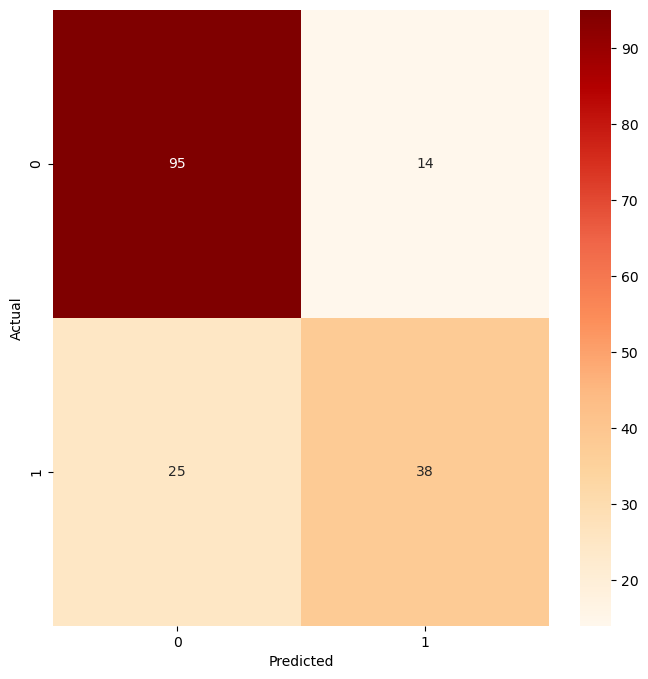

In [70]:
#Visualize confusion matrix
log_cm = confusion_matrix(y_dev, log_best_clf.predict(X_dev))
ConfusionMatrixVisualizer(log_cm)

In [71]:
#The confusion matrix indicates that there is more errors in the actual zeros, but better performance in the
#individuals that survived
#What about the other metrics?
print(classification_report(y_dev, log_best_clf.predict(X_dev)))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       109
           1       0.73      0.60      0.66        63

    accuracy                           0.77       172
   macro avg       0.76      0.74      0.75       172
weighted avg       0.77      0.77      0.77       172



In [72]:
#Very similar indeed
#Train with the whole dataset
#Initialize grid
prod_param_log_grid = [
    {"C": np.linspace(2,3,100), "penalty":["l1","l2"]}
]
#Initialize solver
#Use random_state = 9 because it is my lucky number
logReg = LogisticRegression(solver="liblinear",random_state=9)
#Conduct grid search
prod_log_grid_search = GridSearchCV(logReg, prod_param_log_grid, cv=4, scoring="accuracy", return_train_score=True,verbose=10)
#Fit to data
prod_log_grid_search.fit(X_full_train,y_full_train)
#Retrieve best estimator
prod_log_best_clf = prod_log_grid_search.best_estimator_
#Check parameters
print(prod_log_best_clf)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START C=2.0, penalty=l1.........................................
[CV 1/4; 1/200] END C=2.0, penalty=l1;, score=(train=0.798, test=0.745) total time=   0.0s
[CV 2/4; 1/200] START C=2.0, penalty=l1.........................................
[CV 2/4; 1/200] END C=2.0, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 1/200] START C=2.0, penalty=l1.........................................
[CV 3/4; 1/200] END C=2.0, penalty=l1;, score=(train=0.819, test=0.782) total time=   0.0s
[CV 4/4; 1/200] START C=2.0, penalty=l1.........................................
[CV 4/4; 1/200] END C=2.0, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 2/200] START C=2.0, penalty=l2.........................................
[CV 1/4; 2/200] END C=2.0, penalty=l2;, score=(train=0.801, test=0.741) total time=   0.0s
[CV 2/4; 2/200] START C=2.0, penalty=l2......................................

[CV 3/4; 14/200] END C=2.0606060606060606, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 14/200] START C=2.0606060606060606, penalty=l2.........................
[CV 4/4; 14/200] END C=2.0606060606060606, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 15/200] START C=2.070707070707071, penalty=l1..........................
[CV 1/4; 15/200] END C=2.070707070707071, penalty=l1;, score=(train=0.798, test=0.745) total time=   0.0s
[CV 2/4; 15/200] START C=2.070707070707071, penalty=l1..........................
[CV 2/4; 15/200] END C=2.070707070707071, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 15/200] START C=2.070707070707071, penalty=l1..........................
[CV 3/4; 15/200] END C=2.070707070707071, penalty=l1;, score=(train=0.819, test=0.782) total time=   0.0s
[CV 4/4; 15/200] START C=2.070707070707071, penalty=l1..........................
[CV 4/4; 15/200] END C=2.070707070707071, penalty=l1;, score=(t

[CV 2/4; 29/200] END C=2.1414141414141414, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 29/200] START C=2.1414141414141414, penalty=l1.........................
[CV 3/4; 29/200] END C=2.1414141414141414, penalty=l1;, score=(train=0.819, test=0.782) total time=   0.0s
[CV 4/4; 29/200] START C=2.1414141414141414, penalty=l1.........................
[CV 4/4; 29/200] END C=2.1414141414141414, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 30/200] START C=2.1414141414141414, penalty=l2.........................
[CV 1/4; 30/200] END C=2.1414141414141414, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 30/200] START C=2.1414141414141414, penalty=l2.........................
[CV 2/4; 30/200] END C=2.1414141414141414, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 30/200] START C=2.1414141414141414, penalty=l2.........................
[CV 3/4; 30/200] END C=2.1414141414141414, penalty=l2;, scor

[CV 4/4; 43/200] END C=2.212121212121212, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 44/200] START C=2.212121212121212, penalty=l2..........................
[CV 1/4; 44/200] END C=2.212121212121212, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 44/200] START C=2.212121212121212, penalty=l2..........................
[CV 2/4; 44/200] END C=2.212121212121212, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 44/200] START C=2.212121212121212, penalty=l2..........................
[CV 3/4; 44/200] END C=2.212121212121212, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 44/200] START C=2.212121212121212, penalty=l2..........................
[CV 4/4; 44/200] END C=2.212121212121212, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 45/200] START C=2.2222222222222223, penalty=l1.........................
[CV 1/4; 45/200] END C=2.2222222222222223, penalty=l1;, score=(tr

[CV 4/4; 54/200] END C=2.2626262626262625, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 55/200] START C=2.272727272727273, penalty=l1..........................
[CV 1/4; 55/200] END C=2.272727272727273, penalty=l1;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 55/200] START C=2.272727272727273, penalty=l1..........................
[CV 2/4; 55/200] END C=2.272727272727273, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 55/200] START C=2.272727272727273, penalty=l1..........................
[CV 3/4; 55/200] END C=2.272727272727273, penalty=l1;, score=(train=0.819, test=0.782) total time=   0.0s
[CV 4/4; 55/200] START C=2.272727272727273, penalty=l1..........................
[CV 4/4; 55/200] END C=2.272727272727273, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 56/200] START C=2.272727272727273, penalty=l2..........................
[CV 1/4; 56/200] END C=2.272727272727273, penalty=l2;, score=(tr

[CV 2/4; 67/200] END C=2.3333333333333335, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 67/200] START C=2.3333333333333335, penalty=l1.........................
[CV 3/4; 67/200] END C=2.3333333333333335, penalty=l1;, score=(train=0.819, test=0.782) total time=   0.0s
[CV 4/4; 67/200] START C=2.3333333333333335, penalty=l1.........................
[CV 4/4; 67/200] END C=2.3333333333333335, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 68/200] START C=2.3333333333333335, penalty=l2.........................
[CV 1/4; 68/200] END C=2.3333333333333335, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 68/200] START C=2.3333333333333335, penalty=l2.........................
[CV 2/4; 68/200] END C=2.3333333333333335, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 68/200] START C=2.3333333333333335, penalty=l2.........................
[CV 3/4; 68/200] END C=2.3333333333333335, penalty=l2;, scor

[CV 1/4; 81/200] END C=2.404040404040404, penalty=l1;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 81/200] START C=2.404040404040404, penalty=l1..........................
[CV 2/4; 81/200] END C=2.404040404040404, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 81/200] START C=2.404040404040404, penalty=l1..........................
[CV 3/4; 81/200] END C=2.404040404040404, penalty=l1;, score=(train=0.819, test=0.782) total time=   0.0s
[CV 4/4; 81/200] START C=2.404040404040404, penalty=l1..........................
[CV 4/4; 81/200] END C=2.404040404040404, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 82/200] START C=2.404040404040404, penalty=l2..........................
[CV 1/4; 82/200] END C=2.404040404040404, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 82/200] START C=2.404040404040404, penalty=l2..........................
[CV 2/4; 82/200] END C=2.404040404040404, penalty=l2;, score=(tra

[CV 4/4; 95/200] END C=2.474747474747475, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 96/200] START C=2.474747474747475, penalty=l2..........................
[CV 1/4; 96/200] END C=2.474747474747475, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 96/200] START C=2.474747474747475, penalty=l2..........................
[CV 2/4; 96/200] END C=2.474747474747475, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 96/200] START C=2.474747474747475, penalty=l2..........................
[CV 3/4; 96/200] END C=2.474747474747475, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 96/200] START C=2.474747474747475, penalty=l2..........................
[CV 4/4; 96/200] END C=2.474747474747475, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 97/200] START C=2.484848484848485, penalty=l1..........................
[CV 1/4; 97/200] END C=2.484848484848485, penalty=l1;, score=(tra

[CV 3/4; 110/200] END C=2.5454545454545454, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 110/200] START C=2.5454545454545454, penalty=l2........................
[CV 4/4; 110/200] END C=2.5454545454545454, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 111/200] START C=2.5555555555555554, penalty=l1........................
[CV 1/4; 111/200] END C=2.5555555555555554, penalty=l1;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 111/200] START C=2.5555555555555554, penalty=l1........................
[CV 2/4; 111/200] END C=2.5555555555555554, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 111/200] START C=2.5555555555555554, penalty=l1........................
[CV 3/4; 111/200] END C=2.5555555555555554, penalty=l1;, score=(train=0.819, test=0.782) total time=   0.0s
[CV 4/4; 111/200] START C=2.5555555555555554, penalty=l1........................
[CV 4/4; 111/200] END C=2.5555555555555554, penalty=l1;

[CV 1/4; 122/200] END C=2.606060606060606, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 122/200] START C=2.606060606060606, penalty=l2.........................
[CV 2/4; 122/200] END C=2.606060606060606, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 122/200] START C=2.606060606060606, penalty=l2.........................
[CV 3/4; 122/200] END C=2.606060606060606, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 122/200] START C=2.606060606060606, penalty=l2.........................
[CV 4/4; 122/200] END C=2.606060606060606, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 123/200] START C=2.6161616161616164, penalty=l1........................
[CV 1/4; 123/200] END C=2.6161616161616164, penalty=l1;, score=(train=0.801, test=0.745) total time=   0.0s
[CV 2/4; 123/200] START C=2.6161616161616164, penalty=l1........................
[CV 2/4; 123/200] END C=2.6161616161616164, penalty=l1;, sc

[CV 3/4; 133/200] END C=2.666666666666667, penalty=l1;, score=(train=0.819, test=0.782) total time=   0.0s
[CV 4/4; 133/200] START C=2.666666666666667, penalty=l1.........................
[CV 4/4; 133/200] END C=2.666666666666667, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 134/200] START C=2.666666666666667, penalty=l2.........................
[CV 1/4; 134/200] END C=2.666666666666667, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 134/200] START C=2.666666666666667, penalty=l2.........................
[CV 2/4; 134/200] END C=2.666666666666667, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 134/200] START C=2.666666666666667, penalty=l2.........................
[CV 3/4; 134/200] END C=2.666666666666667, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 134/200] START C=2.666666666666667, penalty=l2.........................
[CV 4/4; 134/200] END C=2.666666666666667, penalty=l2;, scor

[CV 4/4; 145/200] END C=2.7272727272727275, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 146/200] START C=2.7272727272727275, penalty=l2........................
[CV 1/4; 146/200] END C=2.7272727272727275, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 146/200] START C=2.7272727272727275, penalty=l2........................
[CV 2/4; 146/200] END C=2.7272727272727275, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 146/200] START C=2.7272727272727275, penalty=l2........................
[CV 3/4; 146/200] END C=2.7272727272727275, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 146/200] START C=2.7272727272727275, penalty=l2........................
[CV 4/4; 146/200] END C=2.7272727272727275, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 147/200] START C=2.7373737373737375, penalty=l1........................
[CV 1/4; 147/200] END C=2.7373737373737375, penalty=l1;

[CV 1/4; 159/200] END C=2.797979797979798, penalty=l1;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 159/200] START C=2.797979797979798, penalty=l1.........................
[CV 2/4; 159/200] END C=2.797979797979798, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 159/200] START C=2.797979797979798, penalty=l1.........................
[CV 3/4; 159/200] END C=2.797979797979798, penalty=l1;, score=(train=0.821, test=0.782) total time=   0.0s
[CV 4/4; 159/200] START C=2.797979797979798, penalty=l1.........................
[CV 4/4; 159/200] END C=2.797979797979798, penalty=l1;, score=(train=0.813, test=0.792) total time=   0.0s
[CV 1/4; 160/200] START C=2.797979797979798, penalty=l2.........................
[CV 1/4; 160/200] END C=2.797979797979798, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 160/200] START C=2.797979797979798, penalty=l2.........................
[CV 2/4; 160/200] END C=2.797979797979798, penalty=l2;, scor

[CV 2/4; 172/200] END C=2.8585858585858586, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 172/200] START C=2.8585858585858586, penalty=l2........................
[CV 3/4; 172/200] END C=2.8585858585858586, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 172/200] START C=2.8585858585858586, penalty=l2........................
[CV 4/4; 172/200] END C=2.8585858585858586, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 173/200] START C=2.8686868686868685, penalty=l1........................
[CV 1/4; 173/200] END C=2.8686868686868685, penalty=l1;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 173/200] START C=2.8686868686868685, penalty=l1........................
[CV 2/4; 173/200] END C=2.8686868686868685, penalty=l1;, score=(train=0.806, test=0.801) total time=   0.0s
[CV 3/4; 173/200] START C=2.8686868686868685, penalty=l1........................
[CV 3/4; 173/200] END C=2.8686868686868685, penalty=l1;

[CV 3/4; 185/200] END C=2.9292929292929295, penalty=l1;, score=(train=0.821, test=0.773) total time=   0.0s
[CV 4/4; 185/200] START C=2.9292929292929295, penalty=l1........................
[CV 4/4; 185/200] END C=2.9292929292929295, penalty=l1;, score=(train=0.813, test=0.796) total time=   0.0s
[CV 1/4; 186/200] START C=2.9292929292929295, penalty=l2........................
[CV 1/4; 186/200] END C=2.9292929292929295, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 186/200] START C=2.9292929292929295, penalty=l2........................
[CV 2/4; 186/200] END C=2.9292929292929295, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 186/200] START C=2.9292929292929295, penalty=l2........................
[CV 3/4; 186/200] END C=2.9292929292929295, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 186/200] START C=2.9292929292929295, penalty=l2........................
[CV 4/4; 186/200] END C=2.9292929292929295, penalty=l2;

[CV 4/4; 197/200] END C=2.98989898989899, penalty=l1;, score=(train=0.813, test=0.796) total time=   0.0s
[CV 1/4; 198/200] START C=2.98989898989899, penalty=l2..........................
[CV 1/4; 198/200] END C=2.98989898989899, penalty=l2;, score=(train=0.799, test=0.745) total time=   0.0s
[CV 2/4; 198/200] START C=2.98989898989899, penalty=l2..........................
[CV 2/4; 198/200] END C=2.98989898989899, penalty=l2;, score=(train=0.802, test=0.801) total time=   0.0s
[CV 3/4; 198/200] START C=2.98989898989899, penalty=l2..........................
[CV 3/4; 198/200] END C=2.98989898989899, penalty=l2;, score=(train=0.823, test=0.773) total time=   0.0s
[CV 4/4; 198/200] START C=2.98989898989899, penalty=l2..........................
[CV 4/4; 198/200] END C=2.98989898989899, penalty=l2;, score=(train=0.813, test=0.806) total time=   0.0s
[CV 1/4; 199/200] START C=3.0, penalty=l1.......................................
[CV 1/4; 199/200] END C=3.0, penalty=l1;, score=(train=0.799, tes

In [73]:
#Predict for the test data set
predictions = prod_log_best_clf.predict(X_test)
#Format data for submission
final_df = pd.DataFrame(test_df['PassengerId']).astype(int)
final_df['Survived'] = predictions
final_df['Survived'] = final_df['Survived'].astype(int)
final_df.to_csv("titanic/LogisticRegressionPredictions.csv",index=False)

In [74]:
###### KNN #######
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV
#Import estimator
knn_model = KNeighborsClassifier() 

#So far cv 4, weights distance 
#got the better acc 0.8314606741573034

knn_param_grid = [
    {"n_neighbors": list(range(2,11)),
    "weights": ["uniform","distance"],
    "leaf_size": list(range(20,50))}
]

knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=4, scoring="accuracy", return_train_score=True,verbose=10)
knn_grid_search.fit(X_strat_train,y_strat_train)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits
[CV 1/4; 1/540] START leaf_size=20, n_neighbors=2, weights=uniform..............
[CV 1/4; 1/540] END leaf_size=20, n_neighbors=2, weights=uniform;, score=(train=0.896, test=0.740) total time=   0.0s
[CV 2/4; 1/540] START leaf_size=20, n_neighbors=2, weights=uniform..............
[CV 2/4; 1/540] END leaf_size=20, n_neighbors=2, weights=uniform;, score=(train=0.867, test=0.763) total time=   0.0s
[CV 3/4; 1/540] START leaf_size=20, n_neighbors=2, weights=uniform..............
[CV 3/4; 1/540] END leaf_size=20, n_neighbors=2, weights=uniform;, score=(train=0.848, test=0.838) total time=   0.0s
[CV 4/4; 1/540] START leaf_size=20, n_neighbors=2, weights=uniform..............
[CV 4/4; 1/540] END leaf_size=20, n_neighbors=2, weights=uniform;, score=(train=0.871, test=0.821) total time=   0.0s
[CV 1/4; 2/540] START leaf_size=20, n_neighbors=2, weights=distance.............
[CV 1/4; 2/540] END leaf_size=20, n_neighbors=2, weights=di

[CV 4/4; 13/540] END leaf_size=20, n_neighbors=8, weights=uniform;, score=(train=0.825, test=0.798) total time=   0.0s
[CV 1/4; 14/540] START leaf_size=20, n_neighbors=8, weights=distance............
[CV 1/4; 14/540] END leaf_size=20, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 2/4; 14/540] START leaf_size=20, n_neighbors=8, weights=distance............
[CV 2/4; 14/540] END leaf_size=20, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 3/4; 14/540] START leaf_size=20, n_neighbors=8, weights=distance............
[CV 3/4; 14/540] END leaf_size=20, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.827) total time=   0.0s
[CV 4/4; 14/540] START leaf_size=20, n_neighbors=8, weights=distance............
[CV 4/4; 14/540] END leaf_size=20, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 15/540] START leaf_size=20, n_neighbors=9, weights=uniform..........

[CV 2/4; 26/540] END leaf_size=21, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.803) total time=   0.0s
[CV 3/4; 26/540] START leaf_size=21, n_neighbors=5, weights=distance............
[CV 3/4; 26/540] END leaf_size=21, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 26/540] START leaf_size=21, n_neighbors=5, weights=distance............
[CV 4/4; 26/540] END leaf_size=21, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 27/540] START leaf_size=21, n_neighbors=6, weights=uniform.............
[CV 1/4; 27/540] END leaf_size=21, n_neighbors=6, weights=uniform;, score=(train=0.842, test=0.711) total time=   0.0s
[CV 2/4; 27/540] START leaf_size=21, n_neighbors=6, weights=uniform.............
[CV 2/4; 27/540] END leaf_size=21, n_neighbors=6, weights=uniform;, score=(train=0.821, test=0.798) total time=   0.0s
[CV 3/4; 27/540] START leaf_size=21, n_neighbors=6, weights=uniform...........

[CV 1/4; 39/540] END leaf_size=22, n_neighbors=3, weights=uniform;, score=(train=0.894, test=0.740) total time=   0.0s
[CV 2/4; 39/540] START leaf_size=22, n_neighbors=3, weights=uniform.............
[CV 2/4; 39/540] END leaf_size=22, n_neighbors=3, weights=uniform;, score=(train=0.877, test=0.769) total time=   0.0s
[CV 3/4; 39/540] START leaf_size=22, n_neighbors=3, weights=uniform.............
[CV 3/4; 39/540] END leaf_size=22, n_neighbors=3, weights=uniform;, score=(train=0.875, test=0.838) total time=   0.0s
[CV 4/4; 39/540] START leaf_size=22, n_neighbors=3, weights=uniform.............
[CV 4/4; 39/540] END leaf_size=22, n_neighbors=3, weights=uniform;, score=(train=0.879, test=0.792) total time=   0.0s
[CV 1/4; 40/540] START leaf_size=22, n_neighbors=3, weights=distance............
[CV 1/4; 40/540] END leaf_size=22, n_neighbors=3, weights=distance;, score=(train=1.000, test=0.746) total time=   0.0s
[CV 2/4; 40/540] START leaf_size=22, n_neighbors=3, weights=distance............

[CV 4/4; 49/540] END leaf_size=22, n_neighbors=8, weights=uniform;, score=(train=0.825, test=0.798) total time=   0.0s
[CV 1/4; 50/540] START leaf_size=22, n_neighbors=8, weights=distance............
[CV 1/4; 50/540] END leaf_size=22, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 2/4; 50/540] START leaf_size=22, n_neighbors=8, weights=distance............
[CV 2/4; 50/540] END leaf_size=22, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 3/4; 50/540] START leaf_size=22, n_neighbors=8, weights=distance............
[CV 3/4; 50/540] END leaf_size=22, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.827) total time=   0.0s
[CV 4/4; 50/540] START leaf_size=22, n_neighbors=8, weights=distance............
[CV 4/4; 50/540] END leaf_size=22, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 51/540] START leaf_size=22, n_neighbors=9, weights=uniform..........

[CV 1/4; 65/540] END leaf_size=23, n_neighbors=7, weights=uniform;, score=(train=0.857, test=0.734) total time=   0.0s
[CV 2/4; 65/540] START leaf_size=23, n_neighbors=7, weights=uniform.............
[CV 2/4; 65/540] END leaf_size=23, n_neighbors=7, weights=uniform;, score=(train=0.829, test=0.809) total time=   0.0s
[CV 3/4; 65/540] START leaf_size=23, n_neighbors=7, weights=uniform.............
[CV 3/4; 65/540] END leaf_size=23, n_neighbors=7, weights=uniform;, score=(train=0.836, test=0.798) total time=   0.0s
[CV 4/4; 65/540] START leaf_size=23, n_neighbors=7, weights=uniform.............
[CV 4/4; 65/540] END leaf_size=23, n_neighbors=7, weights=uniform;, score=(train=0.834, test=0.803) total time=   0.0s
[CV 1/4; 66/540] START leaf_size=23, n_neighbors=7, weights=distance............
[CV 1/4; 66/540] END leaf_size=23, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.746) total time=   0.0s
[CV 2/4; 66/540] START leaf_size=23, n_neighbors=7, weights=distance............

[CV 1/4; 78/540] END leaf_size=24, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.740) total time=   0.0s
[CV 2/4; 78/540] START leaf_size=24, n_neighbors=4, weights=distance............
[CV 2/4; 78/540] END leaf_size=24, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 3/4; 78/540] START leaf_size=24, n_neighbors=4, weights=distance............
[CV 3/4; 78/540] END leaf_size=24, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.850) total time=   0.0s
[CV 4/4; 78/540] START leaf_size=24, n_neighbors=4, weights=distance............
[CV 4/4; 78/540] END leaf_size=24, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.815) total time=   0.0s
[CV 1/4; 79/540] START leaf_size=24, n_neighbors=5, weights=uniform.............
[CV 1/4; 79/540] END leaf_size=24, n_neighbors=5, weights=uniform;, score=(train=0.871, test=0.723) total time=   0.0s
[CV 2/4; 79/540] START leaf_size=24, n_neighbors=5, weights=uniform..........

[CV 2/4; 88/540] END leaf_size=24, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.798) total time=   0.0s
[CV 3/4; 88/540] START leaf_size=24, n_neighbors=9, weights=distance............
[CV 3/4; 88/540] END leaf_size=24, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.832) total time=   0.0s
[CV 4/4; 88/540] START leaf_size=24, n_neighbors=9, weights=distance............
[CV 4/4; 88/540] END leaf_size=24, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 89/540] START leaf_size=24, n_neighbors=10, weights=uniform............
[CV 1/4; 89/540] END leaf_size=24, n_neighbors=10, weights=uniform;, score=(train=0.848, test=0.734) total time=   0.0s
[CV 2/4; 89/540] START leaf_size=24, n_neighbors=10, weights=uniform............
[CV 2/4; 89/540] END leaf_size=24, n_neighbors=10, weights=uniform;, score=(train=0.807, test=0.792) total time=   0.0s
[CV 3/4; 89/540] START leaf_size=24, n_neighbors=10, weights=uniform........

[CV 3/4; 103/540] END leaf_size=25, n_neighbors=8, weights=uniform;, score=(train=0.827, test=0.775) total time=   0.0s
[CV 4/4; 103/540] START leaf_size=25, n_neighbors=8, weights=uniform............
[CV 4/4; 103/540] END leaf_size=25, n_neighbors=8, weights=uniform;, score=(train=0.825, test=0.798) total time=   0.0s
[CV 1/4; 104/540] START leaf_size=25, n_neighbors=8, weights=distance...........
[CV 1/4; 104/540] END leaf_size=25, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 2/4; 104/540] START leaf_size=25, n_neighbors=8, weights=distance...........
[CV 2/4; 104/540] END leaf_size=25, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 3/4; 104/540] START leaf_size=25, n_neighbors=8, weights=distance...........
[CV 3/4; 104/540] END leaf_size=25, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.827) total time=   0.0s
[CV 4/4; 104/540] START leaf_size=25, n_neighbors=8, weights=distance....

[CV 4/4; 116/540] END leaf_size=26, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 117/540] START leaf_size=26, n_neighbors=6, weights=uniform............
[CV 1/4; 117/540] END leaf_size=26, n_neighbors=6, weights=uniform;, score=(train=0.842, test=0.711) total time=   0.0s
[CV 2/4; 117/540] START leaf_size=26, n_neighbors=6, weights=uniform............
[CV 2/4; 117/540] END leaf_size=26, n_neighbors=6, weights=uniform;, score=(train=0.821, test=0.798) total time=   0.0s
[CV 3/4; 117/540] START leaf_size=26, n_neighbors=6, weights=uniform............
[CV 3/4; 117/540] END leaf_size=26, n_neighbors=6, weights=uniform;, score=(train=0.829, test=0.798) total time=   0.0s
[CV 4/4; 117/540] START leaf_size=26, n_neighbors=6, weights=uniform............
[CV 4/4; 117/540] END leaf_size=26, n_neighbors=6, weights=uniform;, score=(train=0.844, test=0.798) total time=   0.0s
[CV 1/4; 118/540] START leaf_size=26, n_neighbors=6, weights=distance......

[CV 1/4; 132/540] END leaf_size=27, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.740) total time=   0.0s
[CV 2/4; 132/540] START leaf_size=27, n_neighbors=4, weights=distance...........
[CV 2/4; 132/540] END leaf_size=27, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 3/4; 132/540] START leaf_size=27, n_neighbors=4, weights=distance...........
[CV 3/4; 132/540] END leaf_size=27, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.850) total time=   0.0s
[CV 4/4; 132/540] START leaf_size=27, n_neighbors=4, weights=distance...........
[CV 4/4; 132/540] END leaf_size=27, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.815) total time=   0.0s
[CV 1/4; 133/540] START leaf_size=27, n_neighbors=5, weights=uniform............
[CV 1/4; 133/540] END leaf_size=27, n_neighbors=5, weights=uniform;, score=(train=0.871, test=0.723) total time=   0.0s
[CV 2/4; 133/540] START leaf_size=27, n_neighbors=5, weights=uniform....

[CV 3/4; 144/540] END leaf_size=27, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 144/540] START leaf_size=27, n_neighbors=10, weights=distance..........
[CV 4/4; 144/540] END leaf_size=27, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 145/540] START leaf_size=28, n_neighbors=2, weights=uniform............
[CV 1/4; 145/540] END leaf_size=28, n_neighbors=2, weights=uniform;, score=(train=0.896, test=0.740) total time=   0.0s
[CV 2/4; 145/540] START leaf_size=28, n_neighbors=2, weights=uniform............
[CV 2/4; 145/540] END leaf_size=28, n_neighbors=2, weights=uniform;, score=(train=0.867, test=0.763) total time=   0.0s
[CV 3/4; 145/540] START leaf_size=28, n_neighbors=2, weights=uniform............
[CV 3/4; 145/540] END leaf_size=28, n_neighbors=2, weights=uniform;, score=(train=0.848, test=0.838) total time=   0.0s
[CV 4/4; 145/540] START leaf_size=28, n_neighbors=2, weights=uniform....

[CV 1/4; 155/540] END leaf_size=28, n_neighbors=7, weights=uniform;, score=(train=0.857, test=0.734) total time=   0.0s
[CV 2/4; 155/540] START leaf_size=28, n_neighbors=7, weights=uniform............
[CV 2/4; 155/540] END leaf_size=28, n_neighbors=7, weights=uniform;, score=(train=0.829, test=0.809) total time=   0.0s
[CV 3/4; 155/540] START leaf_size=28, n_neighbors=7, weights=uniform............
[CV 3/4; 155/540] END leaf_size=28, n_neighbors=7, weights=uniform;, score=(train=0.836, test=0.798) total time=   0.0s
[CV 4/4; 155/540] START leaf_size=28, n_neighbors=7, weights=uniform............
[CV 4/4; 155/540] END leaf_size=28, n_neighbors=7, weights=uniform;, score=(train=0.834, test=0.803) total time=   0.0s
[CV 1/4; 156/540] START leaf_size=28, n_neighbors=7, weights=distance...........
[CV 1/4; 156/540] END leaf_size=28, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.746) total time=   0.0s
[CV 2/4; 156/540] START leaf_size=28, n_neighbors=7, weights=distance......

[CV 1/4; 169/540] END leaf_size=29, n_neighbors=5, weights=uniform;, score=(train=0.871, test=0.723) total time=   0.0s
[CV 2/4; 169/540] START leaf_size=29, n_neighbors=5, weights=uniform............
[CV 2/4; 169/540] END leaf_size=29, n_neighbors=5, weights=uniform;, score=(train=0.861, test=0.792) total time=   0.0s
[CV 3/4; 169/540] START leaf_size=29, n_neighbors=5, weights=uniform............
[CV 3/4; 169/540] END leaf_size=29, n_neighbors=5, weights=uniform;, score=(train=0.840, test=0.792) total time=   0.0s
[CV 4/4; 169/540] START leaf_size=29, n_neighbors=5, weights=uniform............
[CV 4/4; 169/540] END leaf_size=29, n_neighbors=5, weights=uniform;, score=(train=0.840, test=0.809) total time=   0.0s
[CV 1/4; 170/540] START leaf_size=29, n_neighbors=5, weights=distance...........
[CV 1/4; 170/540] END leaf_size=29, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.734) total time=   0.0s
[CV 2/4; 170/540] START leaf_size=29, n_neighbors=5, weights=distance......

[CV 3/4; 182/540] END leaf_size=30, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.850) total time=   0.0s
[CV 4/4; 182/540] START leaf_size=30, n_neighbors=2, weights=distance...........
[CV 4/4; 182/540] END leaf_size=30, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 1/4; 183/540] START leaf_size=30, n_neighbors=3, weights=uniform............
[CV 1/4; 183/540] END leaf_size=30, n_neighbors=3, weights=uniform;, score=(train=0.894, test=0.740) total time=   0.0s
[CV 2/4; 183/540] START leaf_size=30, n_neighbors=3, weights=uniform............
[CV 2/4; 183/540] END leaf_size=30, n_neighbors=3, weights=uniform;, score=(train=0.877, test=0.769) total time=   0.0s
[CV 3/4; 183/540] START leaf_size=30, n_neighbors=3, weights=uniform............
[CV 3/4; 183/540] END leaf_size=30, n_neighbors=3, weights=uniform;, score=(train=0.875, test=0.838) total time=   0.0s
[CV 4/4; 183/540] START leaf_size=30, n_neighbors=3, weights=uniform......

[CV 2/4; 197/540] END leaf_size=30, n_neighbors=10, weights=uniform;, score=(train=0.807, test=0.792) total time=   0.0s
[CV 3/4; 197/540] START leaf_size=30, n_neighbors=10, weights=uniform...........
[CV 3/4; 197/540] END leaf_size=30, n_neighbors=10, weights=uniform;, score=(train=0.815, test=0.780) total time=   0.0s
[CV 4/4; 197/540] START leaf_size=30, n_neighbors=10, weights=uniform...........
[CV 4/4; 197/540] END leaf_size=30, n_neighbors=10, weights=uniform;, score=(train=0.817, test=0.827) total time=   0.0s
[CV 1/4; 198/540] START leaf_size=30, n_neighbors=10, weights=distance..........
[CV 1/4; 198/540] END leaf_size=30, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 2/4; 198/540] START leaf_size=30, n_neighbors=10, weights=distance..........
[CV 2/4; 198/540] END leaf_size=30, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.815) total time=   0.0s
[CV 3/4; 198/540] START leaf_size=30, n_neighbors=10, weights=distanc

[CV 1/4; 211/540] END leaf_size=31, n_neighbors=8, weights=uniform;, score=(train=0.846, test=0.723) total time=   0.0s
[CV 2/4; 211/540] START leaf_size=31, n_neighbors=8, weights=uniform............
[CV 2/4; 211/540] END leaf_size=31, n_neighbors=8, weights=uniform;, score=(train=0.805, test=0.809) total time=   0.0s
[CV 3/4; 211/540] START leaf_size=31, n_neighbors=8, weights=uniform............
[CV 3/4; 211/540] END leaf_size=31, n_neighbors=8, weights=uniform;, score=(train=0.827, test=0.775) total time=   0.0s
[CV 4/4; 211/540] START leaf_size=31, n_neighbors=8, weights=uniform............
[CV 4/4; 211/540] END leaf_size=31, n_neighbors=8, weights=uniform;, score=(train=0.825, test=0.798) total time=   0.0s
[CV 1/4; 212/540] START leaf_size=31, n_neighbors=8, weights=distance...........
[CV 1/4; 212/540] END leaf_size=31, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 2/4; 212/540] START leaf_size=31, n_neighbors=8, weights=distance......

[CV 4/4; 221/540] END leaf_size=32, n_neighbors=4, weights=uniform;, score=(train=0.842, test=0.809) total time=   0.0s
[CV 1/4; 222/540] START leaf_size=32, n_neighbors=4, weights=distance...........
[CV 1/4; 222/540] END leaf_size=32, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.740) total time=   0.0s
[CV 2/4; 222/540] START leaf_size=32, n_neighbors=4, weights=distance...........
[CV 2/4; 222/540] END leaf_size=32, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 3/4; 222/540] START leaf_size=32, n_neighbors=4, weights=distance...........
[CV 3/4; 222/540] END leaf_size=32, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.850) total time=   0.0s
[CV 4/4; 222/540] START leaf_size=32, n_neighbors=4, weights=distance...........
[CV 4/4; 222/540] END leaf_size=32, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.815) total time=   0.0s
[CV 1/4; 223/540] START leaf_size=32, n_neighbors=5, weights=uniform....

[CV 2/4; 232/540] END leaf_size=32, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.798) total time=   0.0s
[CV 3/4; 232/540] START leaf_size=32, n_neighbors=9, weights=distance...........
[CV 3/4; 232/540] END leaf_size=32, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.832) total time=   0.0s
[CV 4/4; 232/540] START leaf_size=32, n_neighbors=9, weights=distance...........
[CV 4/4; 232/540] END leaf_size=32, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 233/540] START leaf_size=32, n_neighbors=10, weights=uniform...........
[CV 1/4; 233/540] END leaf_size=32, n_neighbors=10, weights=uniform;, score=(train=0.848, test=0.734) total time=   0.0s
[CV 2/4; 233/540] START leaf_size=32, n_neighbors=10, weights=uniform...........
[CV 2/4; 233/540] END leaf_size=32, n_neighbors=10, weights=uniform;, score=(train=0.807, test=0.792) total time=   0.0s
[CV 3/4; 233/540] START leaf_size=32, n_neighbors=10, weights=uniform..

[CV 3/4; 242/540] END leaf_size=33, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 242/540] START leaf_size=33, n_neighbors=5, weights=distance...........
[CV 4/4; 242/540] END leaf_size=33, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 243/540] START leaf_size=33, n_neighbors=6, weights=uniform............
[CV 1/4; 243/540] END leaf_size=33, n_neighbors=6, weights=uniform;, score=(train=0.842, test=0.711) total time=   0.0s
[CV 2/4; 243/540] START leaf_size=33, n_neighbors=6, weights=uniform............
[CV 2/4; 243/540] END leaf_size=33, n_neighbors=6, weights=uniform;, score=(train=0.821, test=0.798) total time=   0.0s
[CV 3/4; 243/540] START leaf_size=33, n_neighbors=6, weights=uniform............
[CV 3/4; 243/540] END leaf_size=33, n_neighbors=6, weights=uniform;, score=(train=0.829, test=0.798) total time=   0.0s
[CV 4/4; 243/540] START leaf_size=33, n_neighbors=6, weights=uniform......

[CV 4/4; 256/540] END leaf_size=34, n_neighbors=3, weights=distance;, score=(train=1.000, test=0.798) total time=   0.0s
[CV 1/4; 257/540] START leaf_size=34, n_neighbors=4, weights=uniform............
[CV 1/4; 257/540] END leaf_size=34, n_neighbors=4, weights=uniform;, score=(train=0.873, test=0.728) total time=   0.0s
[CV 2/4; 257/540] START leaf_size=34, n_neighbors=4, weights=uniform............
[CV 2/4; 257/540] END leaf_size=34, n_neighbors=4, weights=uniform;, score=(train=0.852, test=0.786) total time=   0.0s
[CV 3/4; 257/540] START leaf_size=34, n_neighbors=4, weights=uniform............
[CV 3/4; 257/540] END leaf_size=34, n_neighbors=4, weights=uniform;, score=(train=0.838, test=0.803) total time=   0.0s
[CV 4/4; 257/540] START leaf_size=34, n_neighbors=4, weights=uniform............
[CV 4/4; 257/540] END leaf_size=34, n_neighbors=4, weights=uniform;, score=(train=0.842, test=0.809) total time=   0.0s
[CV 1/4; 258/540] START leaf_size=34, n_neighbors=4, weights=distance......

[CV 3/4; 269/540] END leaf_size=34, n_neighbors=10, weights=uniform;, score=(train=0.815, test=0.780) total time=   0.0s
[CV 4/4; 269/540] START leaf_size=34, n_neighbors=10, weights=uniform...........
[CV 4/4; 269/540] END leaf_size=34, n_neighbors=10, weights=uniform;, score=(train=0.817, test=0.827) total time=   0.0s
[CV 1/4; 270/540] START leaf_size=34, n_neighbors=10, weights=distance..........
[CV 1/4; 270/540] END leaf_size=34, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 2/4; 270/540] START leaf_size=34, n_neighbors=10, weights=distance..........
[CV 2/4; 270/540] END leaf_size=34, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.815) total time=   0.0s
[CV 3/4; 270/540] START leaf_size=34, n_neighbors=10, weights=distance..........
[CV 3/4; 270/540] END leaf_size=34, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 270/540] START leaf_size=34, n_neighbors=10, weights=distan

[CV 4/4; 280/540] END leaf_size=35, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 281/540] START leaf_size=35, n_neighbors=7, weights=uniform............
[CV 1/4; 281/540] END leaf_size=35, n_neighbors=7, weights=uniform;, score=(train=0.857, test=0.734) total time=   0.0s
[CV 2/4; 281/540] START leaf_size=35, n_neighbors=7, weights=uniform............
[CV 2/4; 281/540] END leaf_size=35, n_neighbors=7, weights=uniform;, score=(train=0.829, test=0.809) total time=   0.0s
[CV 3/4; 281/540] START leaf_size=35, n_neighbors=7, weights=uniform............
[CV 3/4; 281/540] END leaf_size=35, n_neighbors=7, weights=uniform;, score=(train=0.836, test=0.798) total time=   0.0s
[CV 4/4; 281/540] START leaf_size=35, n_neighbors=7, weights=uniform............
[CV 4/4; 281/540] END leaf_size=35, n_neighbors=7, weights=uniform;, score=(train=0.834, test=0.803) total time=   0.0s
[CV 1/4; 282/540] START leaf_size=35, n_neighbors=7, weights=distance......

[CV 2/4; 294/540] END leaf_size=36, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 3/4; 294/540] START leaf_size=36, n_neighbors=4, weights=distance...........
[CV 3/4; 294/540] END leaf_size=36, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.850) total time=   0.0s
[CV 4/4; 294/540] START leaf_size=36, n_neighbors=4, weights=distance...........
[CV 4/4; 294/540] END leaf_size=36, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.815) total time=   0.0s
[CV 1/4; 295/540] START leaf_size=36, n_neighbors=5, weights=uniform............
[CV 1/4; 295/540] END leaf_size=36, n_neighbors=5, weights=uniform;, score=(train=0.871, test=0.723) total time=   0.0s
[CV 2/4; 295/540] START leaf_size=36, n_neighbors=5, weights=uniform............
[CV 2/4; 295/540] END leaf_size=36, n_neighbors=5, weights=uniform;, score=(train=0.861, test=0.792) total time=   0.0s
[CV 3/4; 295/540] START leaf_size=36, n_neighbors=5, weights=uniform.....

[CV 3/4; 307/540] END leaf_size=37, n_neighbors=2, weights=uniform;, score=(train=0.848, test=0.838) total time=   0.0s
[CV 4/4; 307/540] START leaf_size=37, n_neighbors=2, weights=uniform............
[CV 4/4; 307/540] END leaf_size=37, n_neighbors=2, weights=uniform;, score=(train=0.871, test=0.821) total time=   0.0s
[CV 1/4; 308/540] START leaf_size=37, n_neighbors=2, weights=distance...........
[CV 1/4; 308/540] END leaf_size=37, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.705) total time=   0.0s
[CV 2/4; 308/540] START leaf_size=37, n_neighbors=2, weights=distance...........
[CV 2/4; 308/540] END leaf_size=37, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.746) total time=   0.0s
[CV 3/4; 308/540] START leaf_size=37, n_neighbors=2, weights=distance...........
[CV 3/4; 308/540] END leaf_size=37, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.850) total time=   0.0s
[CV 4/4; 308/540] START leaf_size=37, n_neighbors=2, weights=distance....

[CV 1/4; 318/540] END leaf_size=37, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.746) total time=   0.0s
[CV 2/4; 318/540] START leaf_size=37, n_neighbors=7, weights=distance...........
[CV 2/4; 318/540] END leaf_size=37, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 3/4; 318/540] START leaf_size=37, n_neighbors=7, weights=distance...........
[CV 3/4; 318/540] END leaf_size=37, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 318/540] START leaf_size=37, n_neighbors=7, weights=distance...........
[CV 4/4; 318/540] END leaf_size=37, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.844) total time=   0.0s
[CV 1/4; 319/540] START leaf_size=37, n_neighbors=8, weights=uniform............
[CV 1/4; 319/540] END leaf_size=37, n_neighbors=8, weights=uniform;, score=(train=0.846, test=0.723) total time=   0.0s
[CV 2/4; 319/540] START leaf_size=37, n_neighbors=8, weights=uniform....

[CV 2/4; 329/540] END leaf_size=38, n_neighbors=4, weights=uniform;, score=(train=0.852, test=0.786) total time=   0.0s
[CV 3/4; 329/540] START leaf_size=38, n_neighbors=4, weights=uniform............
[CV 3/4; 329/540] END leaf_size=38, n_neighbors=4, weights=uniform;, score=(train=0.838, test=0.803) total time=   0.0s
[CV 4/4; 329/540] START leaf_size=38, n_neighbors=4, weights=uniform............
[CV 4/4; 329/540] END leaf_size=38, n_neighbors=4, weights=uniform;, score=(train=0.842, test=0.809) total time=   0.0s
[CV 1/4; 330/540] START leaf_size=38, n_neighbors=4, weights=distance...........
[CV 1/4; 330/540] END leaf_size=38, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.740) total time=   0.0s
[CV 2/4; 330/540] START leaf_size=38, n_neighbors=4, weights=distance...........
[CV 2/4; 330/540] END leaf_size=38, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 3/4; 330/540] START leaf_size=38, n_neighbors=4, weights=distance.....

[CV 3/4; 339/540] END leaf_size=38, n_neighbors=9, weights=uniform;, score=(train=0.823, test=0.792) total time=   0.0s
[CV 4/4; 339/540] START leaf_size=38, n_neighbors=9, weights=uniform............
[CV 4/4; 339/540] END leaf_size=38, n_neighbors=9, weights=uniform;, score=(train=0.813, test=0.798) total time=   0.0s
[CV 1/4; 340/540] START leaf_size=38, n_neighbors=9, weights=distance...........
[CV 1/4; 340/540] END leaf_size=38, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 2/4; 340/540] START leaf_size=38, n_neighbors=9, weights=distance...........
[CV 2/4; 340/540] END leaf_size=38, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.798) total time=   0.0s
[CV 3/4; 340/540] START leaf_size=38, n_neighbors=9, weights=distance...........
[CV 3/4; 340/540] END leaf_size=38, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.832) total time=   0.0s
[CV 4/4; 340/540] START leaf_size=38, n_neighbors=9, weights=distance....

[CV 4/4; 353/540] END leaf_size=39, n_neighbors=7, weights=uniform;, score=(train=0.834, test=0.803) total time=   0.0s
[CV 1/4; 354/540] START leaf_size=39, n_neighbors=7, weights=distance...........
[CV 1/4; 354/540] END leaf_size=39, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.746) total time=   0.0s
[CV 2/4; 354/540] START leaf_size=39, n_neighbors=7, weights=distance...........
[CV 2/4; 354/540] END leaf_size=39, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 3/4; 354/540] START leaf_size=39, n_neighbors=7, weights=distance...........
[CV 3/4; 354/540] END leaf_size=39, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 354/540] START leaf_size=39, n_neighbors=7, weights=distance...........
[CV 4/4; 354/540] END leaf_size=39, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.844) total time=   0.0s
[CV 1/4; 355/540] START leaf_size=39, n_neighbors=8, weights=uniform....

[CV 3/4; 367/540] END leaf_size=40, n_neighbors=5, weights=uniform;, score=(train=0.840, test=0.792) total time=   0.0s
[CV 4/4; 367/540] START leaf_size=40, n_neighbors=5, weights=uniform............
[CV 4/4; 367/540] END leaf_size=40, n_neighbors=5, weights=uniform;, score=(train=0.840, test=0.809) total time=   0.0s
[CV 1/4; 368/540] START leaf_size=40, n_neighbors=5, weights=distance...........
[CV 1/4; 368/540] END leaf_size=40, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.734) total time=   0.0s
[CV 2/4; 368/540] START leaf_size=40, n_neighbors=5, weights=distance...........
[CV 2/4; 368/540] END leaf_size=40, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.803) total time=   0.0s
[CV 3/4; 368/540] START leaf_size=40, n_neighbors=5, weights=distance...........
[CV 3/4; 368/540] END leaf_size=40, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 368/540] START leaf_size=40, n_neighbors=5, weights=distance....

[CV 3/4; 378/540] END leaf_size=40, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 378/540] START leaf_size=40, n_neighbors=10, weights=distance..........
[CV 4/4; 378/540] END leaf_size=40, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 379/540] START leaf_size=41, n_neighbors=2, weights=uniform............
[CV 1/4; 379/540] END leaf_size=41, n_neighbors=2, weights=uniform;, score=(train=0.896, test=0.740) total time=   0.0s
[CV 2/4; 379/540] START leaf_size=41, n_neighbors=2, weights=uniform............
[CV 2/4; 379/540] END leaf_size=41, n_neighbors=2, weights=uniform;, score=(train=0.867, test=0.763) total time=   0.0s
[CV 3/4; 379/540] START leaf_size=41, n_neighbors=2, weights=uniform............
[CV 3/4; 379/540] END leaf_size=41, n_neighbors=2, weights=uniform;, score=(train=0.848, test=0.838) total time=   0.0s
[CV 4/4; 379/540] START leaf_size=41, n_neighbors=2, weights=uniform....

[CV 3/4; 392/540] END leaf_size=41, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.827) total time=   0.0s
[CV 4/4; 392/540] START leaf_size=41, n_neighbors=8, weights=distance...........
[CV 4/4; 392/540] END leaf_size=41, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 393/540] START leaf_size=41, n_neighbors=9, weights=uniform............
[CV 1/4; 393/540] END leaf_size=41, n_neighbors=9, weights=uniform;, score=(train=0.850, test=0.740) total time=   0.0s
[CV 2/4; 393/540] START leaf_size=41, n_neighbors=9, weights=uniform............
[CV 2/4; 393/540] END leaf_size=41, n_neighbors=9, weights=uniform;, score=(train=0.807, test=0.798) total time=   0.0s
[CV 3/4; 393/540] START leaf_size=41, n_neighbors=9, weights=uniform............
[CV 3/4; 393/540] END leaf_size=41, n_neighbors=9, weights=uniform;, score=(train=0.823, test=0.792) total time=   0.0s
[CV 4/4; 393/540] START leaf_size=41, n_neighbors=9, weights=uniform......

[CV 3/4; 405/540] END leaf_size=42, n_neighbors=6, weights=uniform;, score=(train=0.829, test=0.798) total time=   0.0s
[CV 4/4; 405/540] START leaf_size=42, n_neighbors=6, weights=uniform............
[CV 4/4; 405/540] END leaf_size=42, n_neighbors=6, weights=uniform;, score=(train=0.844, test=0.798) total time=   0.0s
[CV 1/4; 406/540] START leaf_size=42, n_neighbors=6, weights=distance...........
[CV 1/4; 406/540] END leaf_size=42, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 2/4; 406/540] START leaf_size=42, n_neighbors=6, weights=distance...........
[CV 2/4; 406/540] END leaf_size=42, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.786) total time=   0.0s
[CV 3/4; 406/540] START leaf_size=42, n_neighbors=6, weights=distance...........
[CV 3/4; 406/540] END leaf_size=42, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 406/540] START leaf_size=42, n_neighbors=6, weights=distance....

[CV 4/4; 416/540] END leaf_size=43, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 1/4; 417/540] START leaf_size=43, n_neighbors=3, weights=uniform............
[CV 1/4; 417/540] END leaf_size=43, n_neighbors=3, weights=uniform;, score=(train=0.894, test=0.740) total time=   0.0s
[CV 2/4; 417/540] START leaf_size=43, n_neighbors=3, weights=uniform............
[CV 2/4; 417/540] END leaf_size=43, n_neighbors=3, weights=uniform;, score=(train=0.877, test=0.769) total time=   0.0s
[CV 3/4; 417/540] START leaf_size=43, n_neighbors=3, weights=uniform............
[CV 3/4; 417/540] END leaf_size=43, n_neighbors=3, weights=uniform;, score=(train=0.875, test=0.838) total time=   0.0s
[CV 4/4; 417/540] START leaf_size=43, n_neighbors=3, weights=uniform............
[CV 4/4; 417/540] END leaf_size=43, n_neighbors=3, weights=uniform;, score=(train=0.879, test=0.792) total time=   0.0s
[CV 1/4; 418/540] START leaf_size=43, n_neighbors=3, weights=distance......

[CV 1/4; 427/540] END leaf_size=43, n_neighbors=8, weights=uniform;, score=(train=0.846, test=0.723) total time=   0.0s
[CV 2/4; 427/540] START leaf_size=43, n_neighbors=8, weights=uniform............
[CV 2/4; 427/540] END leaf_size=43, n_neighbors=8, weights=uniform;, score=(train=0.805, test=0.809) total time=   0.0s
[CV 3/4; 427/540] START leaf_size=43, n_neighbors=8, weights=uniform............
[CV 3/4; 427/540] END leaf_size=43, n_neighbors=8, weights=uniform;, score=(train=0.827, test=0.775) total time=   0.0s
[CV 4/4; 427/540] START leaf_size=43, n_neighbors=8, weights=uniform............
[CV 4/4; 427/540] END leaf_size=43, n_neighbors=8, weights=uniform;, score=(train=0.825, test=0.798) total time=   0.0s
[CV 1/4; 428/540] START leaf_size=43, n_neighbors=8, weights=distance...........
[CV 1/4; 428/540] END leaf_size=43, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.757) total time=   0.0s
[CV 2/4; 428/540] START leaf_size=43, n_neighbors=8, weights=distance......

[CV 1/4; 442/540] END leaf_size=44, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 2/4; 442/540] START leaf_size=44, n_neighbors=6, weights=distance...........
[CV 2/4; 442/540] END leaf_size=44, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.786) total time=   0.0s
[CV 3/4; 442/540] START leaf_size=44, n_neighbors=6, weights=distance...........
[CV 3/4; 442/540] END leaf_size=44, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 442/540] START leaf_size=44, n_neighbors=6, weights=distance...........
[CV 4/4; 442/540] END leaf_size=44, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 443/540] START leaf_size=44, n_neighbors=7, weights=uniform............
[CV 1/4; 443/540] END leaf_size=44, n_neighbors=7, weights=uniform;, score=(train=0.857, test=0.734) total time=   0.0s
[CV 2/4; 443/540] START leaf_size=44, n_neighbors=7, weights=uniform....

[CV 2/4; 452/540] END leaf_size=45, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.746) total time=   0.0s
[CV 3/4; 452/540] START leaf_size=45, n_neighbors=2, weights=distance...........
[CV 3/4; 452/540] END leaf_size=45, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.850) total time=   0.0s
[CV 4/4; 452/540] START leaf_size=45, n_neighbors=2, weights=distance...........
[CV 4/4; 452/540] END leaf_size=45, n_neighbors=2, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 1/4; 453/540] START leaf_size=45, n_neighbors=3, weights=uniform............
[CV 1/4; 453/540] END leaf_size=45, n_neighbors=3, weights=uniform;, score=(train=0.894, test=0.740) total time=   0.0s
[CV 2/4; 453/540] START leaf_size=45, n_neighbors=3, weights=uniform............
[CV 2/4; 453/540] END leaf_size=45, n_neighbors=3, weights=uniform;, score=(train=0.877, test=0.769) total time=   0.0s
[CV 3/4; 453/540] START leaf_size=45, n_neighbors=3, weights=uniform.....

[CV 2/4; 464/540] END leaf_size=45, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.809) total time=   0.0s
[CV 3/4; 464/540] START leaf_size=45, n_neighbors=8, weights=distance...........
[CV 3/4; 464/540] END leaf_size=45, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.827) total time=   0.0s
[CV 4/4; 464/540] START leaf_size=45, n_neighbors=8, weights=distance...........
[CV 4/4; 464/540] END leaf_size=45, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 465/540] START leaf_size=45, n_neighbors=9, weights=uniform............
[CV 1/4; 465/540] END leaf_size=45, n_neighbors=9, weights=uniform;, score=(train=0.850, test=0.740) total time=   0.0s
[CV 2/4; 465/540] START leaf_size=45, n_neighbors=9, weights=uniform............
[CV 2/4; 465/540] END leaf_size=45, n_neighbors=9, weights=uniform;, score=(train=0.807, test=0.798) total time=   0.0s
[CV 3/4; 465/540] START leaf_size=45, n_neighbors=9, weights=uniform.....

[CV 4/4; 475/540] END leaf_size=46, n_neighbors=5, weights=uniform;, score=(train=0.840, test=0.809) total time=   0.0s
[CV 1/4; 476/540] START leaf_size=46, n_neighbors=5, weights=distance...........
[CV 1/4; 476/540] END leaf_size=46, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.734) total time=   0.0s
[CV 2/4; 476/540] START leaf_size=46, n_neighbors=5, weights=distance...........
[CV 2/4; 476/540] END leaf_size=46, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.803) total time=   0.0s
[CV 3/4; 476/540] START leaf_size=46, n_neighbors=5, weights=distance...........
[CV 3/4; 476/540] END leaf_size=46, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 476/540] START leaf_size=46, n_neighbors=5, weights=distance...........
[CV 4/4; 476/540] END leaf_size=46, n_neighbors=5, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 477/540] START leaf_size=46, n_neighbors=6, weights=uniform....

[CV 2/4; 490/540] END leaf_size=47, n_neighbors=3, weights=distance;, score=(train=1.000, test=0.769) total time=   0.0s
[CV 3/4; 490/540] START leaf_size=47, n_neighbors=3, weights=distance...........
[CV 3/4; 490/540] END leaf_size=47, n_neighbors=3, weights=distance;, score=(train=1.000, test=0.855) total time=   0.0s
[CV 4/4; 490/540] START leaf_size=47, n_neighbors=3, weights=distance...........
[CV 4/4; 490/540] END leaf_size=47, n_neighbors=3, weights=distance;, score=(train=1.000, test=0.798) total time=   0.0s
[CV 1/4; 491/540] START leaf_size=47, n_neighbors=4, weights=uniform............
[CV 1/4; 491/540] END leaf_size=47, n_neighbors=4, weights=uniform;, score=(train=0.873, test=0.728) total time=   0.0s
[CV 2/4; 491/540] START leaf_size=47, n_neighbors=4, weights=uniform............
[CV 2/4; 491/540] END leaf_size=47, n_neighbors=4, weights=uniform;, score=(train=0.852, test=0.786) total time=   0.0s
[CV 3/4; 491/540] START leaf_size=47, n_neighbors=4, weights=uniform.....

[CV 1/4; 502/540] END leaf_size=47, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 2/4; 502/540] START leaf_size=47, n_neighbors=9, weights=distance...........
[CV 2/4; 502/540] END leaf_size=47, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.798) total time=   0.0s
[CV 3/4; 502/540] START leaf_size=47, n_neighbors=9, weights=distance...........
[CV 3/4; 502/540] END leaf_size=47, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.832) total time=   0.0s
[CV 4/4; 502/540] START leaf_size=47, n_neighbors=9, weights=distance...........
[CV 4/4; 502/540] END leaf_size=47, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 503/540] START leaf_size=47, n_neighbors=10, weights=uniform...........
[CV 1/4; 503/540] END leaf_size=47, n_neighbors=10, weights=uniform;, score=(train=0.848, test=0.734) total time=   0.0s
[CV 2/4; 503/540] START leaf_size=47, n_neighbors=10, weights=uniform..

[CV 4/4; 513/540] END leaf_size=48, n_neighbors=6, weights=uniform;, score=(train=0.844, test=0.798) total time=   0.0s
[CV 1/4; 514/540] START leaf_size=48, n_neighbors=6, weights=distance...........
[CV 1/4; 514/540] END leaf_size=48, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 2/4; 514/540] START leaf_size=48, n_neighbors=6, weights=distance...........
[CV 2/4; 514/540] END leaf_size=48, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.786) total time=   0.0s
[CV 3/4; 514/540] START leaf_size=48, n_neighbors=6, weights=distance...........
[CV 3/4; 514/540] END leaf_size=48, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 4/4; 514/540] START leaf_size=48, n_neighbors=6, weights=distance...........
[CV 4/4; 514/540] END leaf_size=48, n_neighbors=6, weights=distance;, score=(train=1.000, test=0.838) total time=   0.0s
[CV 1/4; 515/540] START leaf_size=48, n_neighbors=7, weights=uniform....

[CV 1/4; 527/540] END leaf_size=49, n_neighbors=4, weights=uniform;, score=(train=0.873, test=0.728) total time=   0.0s
[CV 2/4; 527/540] START leaf_size=49, n_neighbors=4, weights=uniform............
[CV 2/4; 527/540] END leaf_size=49, n_neighbors=4, weights=uniform;, score=(train=0.852, test=0.786) total time=   0.0s
[CV 3/4; 527/540] START leaf_size=49, n_neighbors=4, weights=uniform............
[CV 3/4; 527/540] END leaf_size=49, n_neighbors=4, weights=uniform;, score=(train=0.838, test=0.803) total time=   0.0s
[CV 4/4; 527/540] START leaf_size=49, n_neighbors=4, weights=uniform............
[CV 4/4; 527/540] END leaf_size=49, n_neighbors=4, weights=uniform;, score=(train=0.842, test=0.809) total time=   0.0s
[CV 1/4; 528/540] START leaf_size=49, n_neighbors=4, weights=distance...........
[CV 1/4; 528/540] END leaf_size=49, n_neighbors=4, weights=distance;, score=(train=1.000, test=0.740) total time=   0.0s
[CV 2/4; 528/540] START leaf_size=49, n_neighbors=4, weights=distance......

[CV 2/4; 539/540] END leaf_size=49, n_neighbors=10, weights=uniform;, score=(train=0.807, test=0.792) total time=   0.0s
[CV 3/4; 539/540] START leaf_size=49, n_neighbors=10, weights=uniform...........
[CV 3/4; 539/540] END leaf_size=49, n_neighbors=10, weights=uniform;, score=(train=0.815, test=0.780) total time=   0.0s
[CV 4/4; 539/540] START leaf_size=49, n_neighbors=10, weights=uniform...........
[CV 4/4; 539/540] END leaf_size=49, n_neighbors=10, weights=uniform;, score=(train=0.817, test=0.827) total time=   0.0s
[CV 1/4; 540/540] START leaf_size=49, n_neighbors=10, weights=distance..........
[CV 1/4; 540/540] END leaf_size=49, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.751) total time=   0.0s
[CV 2/4; 540/540] START leaf_size=49, n_neighbors=10, weights=distance..........
[CV 2/4; 540/540] END leaf_size=49, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.815) total time=   0.0s
[CV 3/4; 540/540] START leaf_size=49, n_neighbors=10, weights=distanc

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid=[{'leaf_size': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                        30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                                        40, 41, 42, 43, 44, 45, 46, 47, 48,
                                        49],
                          'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy', verbose=10)

In [75]:
#Retrieve the best estimator
knn_best_clf = knn_grid_search.best_estimator_
#Check parameters
print(knn_best_clf)
#Check score
knn_best_clf.score(X_dev,y_dev)

KNeighborsClassifier(leaf_size=20, n_neighbors=10, weights='distance')


0.7790697674418605

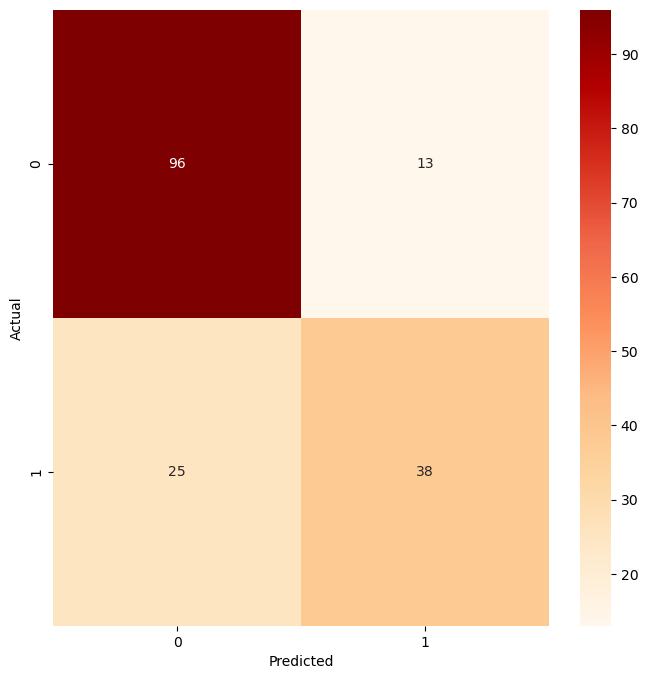

In [76]:
#Visualize confusion matrix
knn_cm = confusion_matrix(y_dev, knn_best_clf.predict(X_dev))
ConfusionMatrixVisualizer(knn_cm)

In [77]:
#Great performance for those that did not survive, but not that well for those who did
#Train with the whole dataset
knn_model = KNeighborsClassifier() 

prod_knn_param_grid = [
    {"n_neighbors": list(range(7,13)),
    "weights": ["distance"],
    "leaf_size": list(range(10,30))}
]

prod_knn_grid_search = GridSearchCV(knn_model, prod_knn_param_grid, cv=4, scoring="accuracy", return_train_score=True,verbose=10)
prod_knn_grid_search.fit(X_full_train,y_full_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
[CV 1/4; 1/120] START leaf_size=10, n_neighbors=7, weights=distance.............
[CV 1/4; 1/120] END leaf_size=10, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 1/120] START leaf_size=10, n_neighbors=7, weights=distance.............
[CV 2/4; 1/120] END leaf_size=10, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.792) total time=   0.0s
[CV 3/4; 1/120] START leaf_size=10, n_neighbors=7, weights=distance.............
[CV 3/4; 1/120] END leaf_size=10, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 4/4; 1/120] START leaf_size=10, n_neighbors=7, weights=distance.............
[CV 4/4; 1/120] END leaf_size=10, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 1/4; 2/120] START leaf_size=10, n_neighbors=8, weights=distance.............
[CV 1/4; 2/120] END leaf_size=10, n_neighbors=8, weights

[CV 2/4; 11/120] END leaf_size=11, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.801) total time=   0.0s
[CV 3/4; 11/120] START leaf_size=11, n_neighbors=11, weights=distance...........
[CV 3/4; 11/120] END leaf_size=11, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.787) total time=   0.0s
[CV 4/4; 11/120] START leaf_size=11, n_neighbors=11, weights=distance...........
[CV 4/4; 11/120] END leaf_size=11, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 1/4; 12/120] START leaf_size=11, n_neighbors=12, weights=distance...........
[CV 1/4; 12/120] END leaf_size=11, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 12/120] START leaf_size=11, n_neighbors=12, weights=distance...........
[CV 2/4; 12/120] END leaf_size=11, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 3/4; 12/120] START leaf_size=11, n_neighbors=12, weights=distance..

[CV 4/4; 23/120] END leaf_size=13, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 1/4; 24/120] START leaf_size=13, n_neighbors=12, weights=distance...........
[CV 1/4; 24/120] END leaf_size=13, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 24/120] START leaf_size=13, n_neighbors=12, weights=distance...........
[CV 2/4; 24/120] END leaf_size=13, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 3/4; 24/120] START leaf_size=13, n_neighbors=12, weights=distance...........
[CV 3/4; 24/120] END leaf_size=13, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 4/4; 24/120] START leaf_size=13, n_neighbors=12, weights=distance...........
[CV 4/4; 24/120] END leaf_size=13, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.810) total time=   0.0s
[CV 1/4; 25/120] START leaf_size=14, n_neighbors=7, weights=distance...

[CV 2/4; 36/120] END leaf_size=15, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 3/4; 36/120] START leaf_size=15, n_neighbors=12, weights=distance...........
[CV 3/4; 36/120] END leaf_size=15, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 4/4; 36/120] START leaf_size=15, n_neighbors=12, weights=distance...........
[CV 4/4; 36/120] END leaf_size=15, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.810) total time=   0.0s
[CV 1/4; 37/120] START leaf_size=16, n_neighbors=7, weights=distance............
[CV 1/4; 37/120] END leaf_size=16, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 37/120] START leaf_size=16, n_neighbors=7, weights=distance............
[CV 2/4; 37/120] END leaf_size=16, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.792) total time=   0.0s
[CV 3/4; 37/120] START leaf_size=16, n_neighbors=7, weights=distance.....

[CV 4/4; 46/120] END leaf_size=17, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 1/4; 47/120] START leaf_size=17, n_neighbors=11, weights=distance...........
[CV 1/4; 47/120] END leaf_size=17, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 47/120] START leaf_size=17, n_neighbors=11, weights=distance...........
[CV 2/4; 47/120] END leaf_size=17, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.801) total time=   0.0s
[CV 3/4; 47/120] START leaf_size=17, n_neighbors=11, weights=distance...........
[CV 3/4; 47/120] END leaf_size=17, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.787) total time=   0.0s
[CV 4/4; 47/120] START leaf_size=17, n_neighbors=11, weights=distance...........
[CV 4/4; 47/120] END leaf_size=17, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 1/4; 48/120] START leaf_size=17, n_neighbors=12, weights=distance..

[CV 2/4; 58/120] END leaf_size=19, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.819) total time=   0.0s
[CV 3/4; 58/120] START leaf_size=19, n_neighbors=10, weights=distance...........
[CV 3/4; 58/120] END leaf_size=19, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.787) total time=   0.0s
[CV 4/4; 58/120] START leaf_size=19, n_neighbors=10, weights=distance...........
[CV 4/4; 58/120] END leaf_size=19, n_neighbors=10, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 1/4; 59/120] START leaf_size=19, n_neighbors=11, weights=distance...........
[CV 1/4; 59/120] END leaf_size=19, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 59/120] START leaf_size=19, n_neighbors=11, weights=distance...........
[CV 2/4; 59/120] END leaf_size=19, n_neighbors=11, weights=distance;, score=(train=1.000, test=0.801) total time=   0.0s
[CV 3/4; 59/120] START leaf_size=19, n_neighbors=11, weights=distance..

[CV 3/4; 68/120] END leaf_size=21, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.815) total time=   0.0s
[CV 4/4; 68/120] START leaf_size=21, n_neighbors=8, weights=distance............
[CV 4/4; 68/120] END leaf_size=21, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 1/4; 69/120] START leaf_size=21, n_neighbors=9, weights=distance............
[CV 1/4; 69/120] END leaf_size=21, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.787) total time=   0.0s
[CV 2/4; 69/120] START leaf_size=21, n_neighbors=9, weights=distance............
[CV 2/4; 69/120] END leaf_size=21, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 3/4; 69/120] START leaf_size=21, n_neighbors=9, weights=distance............
[CV 3/4; 69/120] END leaf_size=21, n_neighbors=9, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 4/4; 69/120] START leaf_size=21, n_neighbors=9, weights=distance........

[CV 1/4; 79/120] END leaf_size=23, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 79/120] START leaf_size=23, n_neighbors=7, weights=distance............
[CV 2/4; 79/120] END leaf_size=23, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.792) total time=   0.0s
[CV 3/4; 79/120] START leaf_size=23, n_neighbors=7, weights=distance............
[CV 3/4; 79/120] END leaf_size=23, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 4/4; 79/120] START leaf_size=23, n_neighbors=7, weights=distance............
[CV 4/4; 79/120] END leaf_size=23, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 1/4; 80/120] START leaf_size=23, n_neighbors=8, weights=distance............
[CV 1/4; 80/120] END leaf_size=23, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.787) total time=   0.0s
[CV 2/4; 80/120] START leaf_size=23, n_neighbors=8, weights=distance........

[CV 1/4; 91/120] END leaf_size=25, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 91/120] START leaf_size=25, n_neighbors=7, weights=distance............
[CV 2/4; 91/120] END leaf_size=25, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.792) total time=   0.0s
[CV 3/4; 91/120] START leaf_size=25, n_neighbors=7, weights=distance............
[CV 3/4; 91/120] END leaf_size=25, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 4/4; 91/120] START leaf_size=25, n_neighbors=7, weights=distance............
[CV 4/4; 91/120] END leaf_size=25, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 1/4; 92/120] START leaf_size=25, n_neighbors=8, weights=distance............
[CV 1/4; 92/120] END leaf_size=25, n_neighbors=8, weights=distance;, score=(train=1.000, test=0.787) total time=   0.0s
[CV 2/4; 92/120] START leaf_size=25, n_neighbors=8, weights=distance........

[CV 1/4; 102/120] END leaf_size=26, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 102/120] START leaf_size=26, n_neighbors=12, weights=distance..........
[CV 2/4; 102/120] END leaf_size=26, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 3/4; 102/120] START leaf_size=26, n_neighbors=12, weights=distance..........
[CV 3/4; 102/120] END leaf_size=26, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 4/4; 102/120] START leaf_size=26, n_neighbors=12, weights=distance..........
[CV 4/4; 102/120] END leaf_size=26, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.810) total time=   0.0s
[CV 1/4; 103/120] START leaf_size=27, n_neighbors=7, weights=distance...........
[CV 1/4; 103/120] END leaf_size=27, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 103/120] START leaf_size=27, n_neighbors=7, weights=distan

[CV 1/4; 114/120] END leaf_size=28, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 114/120] START leaf_size=28, n_neighbors=12, weights=distance..........
[CV 2/4; 114/120] END leaf_size=28, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 3/4; 114/120] START leaf_size=28, n_neighbors=12, weights=distance..........
[CV 3/4; 114/120] END leaf_size=28, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.796) total time=   0.0s
[CV 4/4; 114/120] START leaf_size=28, n_neighbors=12, weights=distance..........
[CV 4/4; 114/120] END leaf_size=28, n_neighbors=12, weights=distance;, score=(train=1.000, test=0.810) total time=   0.0s
[CV 1/4; 115/120] START leaf_size=29, n_neighbors=7, weights=distance...........
[CV 1/4; 115/120] END leaf_size=29, n_neighbors=7, weights=distance;, score=(train=1.000, test=0.782) total time=   0.0s
[CV 2/4; 115/120] START leaf_size=29, n_neighbors=7, weights=distan

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid=[{'leaf_size': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                        20, 21, 22, 23, 24, 25, 26, 27, 28,
                                        29],
                          'n_neighbors': [7, 8, 9, 10, 11, 12],
                          'weights': ['distance']}],
             return_train_score=True, scoring='accuracy', verbose=10)

In [78]:
#Retrieve best estimator
prod_knn_best_clf = prod_knn_grid_search.best_estimator_
#Check parameters
print(prod_knn_best_clf)

KNeighborsClassifier(leaf_size=10, n_neighbors=12, weights='distance')


In [79]:
#Predict for the test data set
predictions = prod_knn_best_clf.predict(X_test)
#Format data for submission
final_df = pd.DataFrame(test_df['PassengerId']).astype(int)
final_df['Survived'] = predictions
final_df['Survived'] = final_df['Survived'].astype(int)
final_df.to_csv("titanic/KNNPredictions.csv",index=False)

In [80]:
###### Support Vector Machine ######
#Import
from sklearn.svm import SVC
#Set up classifier
svc_clf = SVC(random_state=9)

#Grid search
svc_param_grid = [
    {"C": np.linspace(1,5,50),"kernel":['linear', 'poly', 'rbf', 'sigmoid']}
]
#Do a grid search
svc_grid_search = GridSearchCV(svc_clf, svc_param_grid, cv=4, scoring="accuracy", return_train_score=True,verbose=10)
svc_grid_search.fit(X_strat_train,y_strat_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
[CV 1/4; 1/200] START C=1.0, kernel=linear......................................
[CV 1/4; 1/200] END C=1.0, kernel=linear;, score=(train=0.802, test=0.763) total time=   0.0s
[CV 2/4; 1/200] START C=1.0, kernel=linear......................................
[CV 2/4; 1/200] END C=1.0, kernel=linear;, score=(train=0.788, test=0.798) total time=   0.0s
[CV 3/4; 1/200] START C=1.0, kernel=linear......................................
[CV 3/4; 1/200] END C=1.0, kernel=linear;, score=(train=0.798, test=0.775) total time=   0.0s
[CV 4/4; 1/200] START C=1.0, kernel=linear......................................
[CV 4/4; 1/200] END C=1.0, kernel=linear;, score=(train=0.782, test=0.798) total time=   0.0s
[CV 1/4; 2/200] START C=1.0, kernel=poly........................................
[CV 1/4; 2/200] END C=1.0, kernel=poly;, score=(train=0.850, test=0.740) total time=   0.0s
[CV 2/4; 2/200] START C=1.0, kernel=poly........................

[CV 1/4; 12/200] END C=1.163265306122449, kernel=sigmoid;, score=(train=0.786, test=0.711) total time=   0.0s
[CV 2/4; 12/200] START C=1.163265306122449, kernel=sigmoid......................
[CV 2/4; 12/200] END C=1.163265306122449, kernel=sigmoid;, score=(train=0.738, test=0.734) total time=   0.0s
[CV 3/4; 12/200] START C=1.163265306122449, kernel=sigmoid......................
[CV 3/4; 12/200] END C=1.163265306122449, kernel=sigmoid;, score=(train=0.723, test=0.751) total time=   0.0s
[CV 4/4; 12/200] START C=1.163265306122449, kernel=sigmoid......................
[CV 4/4; 12/200] END C=1.163265306122449, kernel=sigmoid;, score=(train=0.711, test=0.780) total time=   0.0s
[CV 1/4; 13/200] START C=1.2448979591836735, kernel=linear......................
[CV 1/4; 13/200] END C=1.2448979591836735, kernel=linear;, score=(train=0.802, test=0.763) total time=   0.0s
[CV 2/4; 13/200] START C=1.2448979591836735, kernel=linear......................
[CV 2/4; 13/200] END C=1.2448979591836735, ke

[CV 1/4; 23/200] END C=1.4081632653061225, kernel=rbf;, score=(train=0.865, test=0.740) total time=   0.0s
[CV 2/4; 23/200] START C=1.4081632653061225, kernel=rbf.........................
[CV 2/4; 23/200] END C=1.4081632653061225, kernel=rbf;, score=(train=0.846, test=0.815) total time=   0.0s
[CV 3/4; 23/200] START C=1.4081632653061225, kernel=rbf.........................
[CV 3/4; 23/200] END C=1.4081632653061225, kernel=rbf;, score=(train=0.850, test=0.821) total time=   0.0s
[CV 4/4; 23/200] START C=1.4081632653061225, kernel=rbf.........................
[CV 4/4; 23/200] END C=1.4081632653061225, kernel=rbf;, score=(train=0.838, test=0.815) total time=   0.0s
[CV 1/4; 24/200] START C=1.4081632653061225, kernel=sigmoid.....................
[CV 1/4; 24/200] END C=1.4081632653061225, kernel=sigmoid;, score=(train=0.755, test=0.653) total time=   0.0s
[CV 2/4; 24/200] START C=1.4081632653061225, kernel=sigmoid.....................
[CV 2/4; 24/200] END C=1.4081632653061225, kernel=sigmoi

[CV 4/4; 34/200] END C=1.6530612244897958, kernel=poly;, score=(train=0.846, test=0.815) total time=   0.0s
[CV 1/4; 35/200] START C=1.6530612244897958, kernel=rbf.........................
[CV 1/4; 35/200] END C=1.6530612244897958, kernel=rbf;, score=(train=0.871, test=0.746) total time=   0.0s
[CV 2/4; 35/200] START C=1.6530612244897958, kernel=rbf.........................
[CV 2/4; 35/200] END C=1.6530612244897958, kernel=rbf;, score=(train=0.846, test=0.815) total time=   0.0s
[CV 3/4; 35/200] START C=1.6530612244897958, kernel=rbf.........................
[CV 3/4; 35/200] END C=1.6530612244897958, kernel=rbf;, score=(train=0.848, test=0.803) total time=   0.0s
[CV 4/4; 35/200] START C=1.6530612244897958, kernel=rbf.........................
[CV 4/4; 35/200] END C=1.6530612244897958, kernel=rbf;, score=(train=0.840, test=0.815) total time=   0.0s
[CV 1/4; 36/200] START C=1.6530612244897958, kernel=sigmoid.....................
[CV 1/4; 36/200] END C=1.6530612244897958, kernel=sigmoid;,

[CV 2/4; 46/200] END C=1.8979591836734693, kernel=poly;, score=(train=0.854, test=0.827) total time=   0.0s
[CV 3/4; 46/200] START C=1.8979591836734693, kernel=poly........................
[CV 3/4; 46/200] END C=1.8979591836734693, kernel=poly;, score=(train=0.846, test=0.786) total time=   0.0s
[CV 4/4; 46/200] START C=1.8979591836734693, kernel=poly........................
[CV 4/4; 46/200] END C=1.8979591836734693, kernel=poly;, score=(train=0.846, test=0.815) total time=   0.0s
[CV 1/4; 47/200] START C=1.8979591836734693, kernel=rbf.........................
[CV 1/4; 47/200] END C=1.8979591836734693, kernel=rbf;, score=(train=0.875, test=0.751) total time=   0.0s
[CV 2/4; 47/200] START C=1.8979591836734693, kernel=rbf.........................
[CV 2/4; 47/200] END C=1.8979591836734693, kernel=rbf;, score=(train=0.852, test=0.821) total time=   0.0s
[CV 3/4; 47/200] START C=1.8979591836734693, kernel=rbf.........................
[CV 3/4; 47/200] END C=1.8979591836734693, kernel=rbf;, s

[CV 3/4; 57/200] END C=2.142857142857143, kernel=linear;, score=(train=0.798, test=0.775) total time=   0.0s
[CV 4/4; 57/200] START C=2.142857142857143, kernel=linear.......................
[CV 4/4; 57/200] END C=2.142857142857143, kernel=linear;, score=(train=0.782, test=0.798) total time=   0.0s
[CV 1/4; 58/200] START C=2.142857142857143, kernel=poly.........................
[CV 1/4; 58/200] END C=2.142857142857143, kernel=poly;, score=(train=0.884, test=0.746) total time=   0.0s
[CV 2/4; 58/200] START C=2.142857142857143, kernel=poly.........................
[CV 2/4; 58/200] END C=2.142857142857143, kernel=poly;, score=(train=0.852, test=0.827) total time=   0.0s
[CV 3/4; 58/200] START C=2.142857142857143, kernel=poly.........................
[CV 3/4; 58/200] END C=2.142857142857143, kernel=poly;, score=(train=0.848, test=0.792) total time=   0.0s
[CV 4/4; 58/200] START C=2.142857142857143, kernel=poly.........................
[CV 4/4; 58/200] END C=2.142857142857143, kernel=poly;, 

[CV 2/4; 69/200] END C=2.387755102040816, kernel=linear;, score=(train=0.788, test=0.798) total time=   0.0s
[CV 3/4; 69/200] START C=2.387755102040816, kernel=linear.......................
[CV 3/4; 69/200] END C=2.387755102040816, kernel=linear;, score=(train=0.798, test=0.775) total time=   0.0s
[CV 4/4; 69/200] START C=2.387755102040816, kernel=linear.......................
[CV 4/4; 69/200] END C=2.387755102040816, kernel=linear;, score=(train=0.782, test=0.798) total time=   0.0s
[CV 1/4; 70/200] START C=2.387755102040816, kernel=poly.........................
[CV 1/4; 70/200] END C=2.387755102040816, kernel=poly;, score=(train=0.884, test=0.746) total time=   0.0s
[CV 2/4; 70/200] START C=2.387755102040816, kernel=poly.........................
[CV 2/4; 70/200] END C=2.387755102040816, kernel=poly;, score=(train=0.855, test=0.827) total time=   0.0s
[CV 3/4; 70/200] START C=2.387755102040816, kernel=poly.........................
[CV 3/4; 70/200] END C=2.387755102040816, kernel=poly;

[CV 4/4; 80/200] END C=2.5510204081632653, kernel=sigmoid;, score=(train=0.699, test=0.751) total time=   0.0s
[CV 1/4; 81/200] START C=2.63265306122449, kernel=linear........................
[CV 1/4; 81/200] END C=2.63265306122449, kernel=linear;, score=(train=0.802, test=0.763) total time=   0.0s
[CV 2/4; 81/200] START C=2.63265306122449, kernel=linear........................
[CV 2/4; 81/200] END C=2.63265306122449, kernel=linear;, score=(train=0.788, test=0.798) total time=   0.0s
[CV 3/4; 81/200] START C=2.63265306122449, kernel=linear........................
[CV 3/4; 81/200] END C=2.63265306122449, kernel=linear;, score=(train=0.798, test=0.775) total time=   0.0s
[CV 4/4; 81/200] START C=2.63265306122449, kernel=linear........................
[CV 4/4; 81/200] END C=2.63265306122449, kernel=linear;, score=(train=0.782, test=0.798) total time=   0.0s
[CV 1/4; 82/200] START C=2.63265306122449, kernel=poly..........................
[CV 1/4; 82/200] END C=2.63265306122449, kernel=poly

[CV 4/4; 91/200] END C=2.7959183673469385, kernel=rbf;, score=(train=0.846, test=0.821) total time=   0.0s
[CV 1/4; 92/200] START C=2.7959183673469385, kernel=sigmoid.....................
[CV 1/4; 92/200] END C=2.7959183673469385, kernel=sigmoid;, score=(train=0.742, test=0.630) total time=   0.0s
[CV 2/4; 92/200] START C=2.7959183673469385, kernel=sigmoid.....................
[CV 2/4; 92/200] END C=2.7959183673469385, kernel=sigmoid;, score=(train=0.703, test=0.734) total time=   0.0s
[CV 3/4; 92/200] START C=2.7959183673469385, kernel=sigmoid.....................
[CV 3/4; 92/200] END C=2.7959183673469385, kernel=sigmoid;, score=(train=0.694, test=0.734) total time=   0.0s
[CV 4/4; 92/200] START C=2.7959183673469385, kernel=sigmoid.....................
[CV 4/4; 92/200] END C=2.7959183673469385, kernel=sigmoid;, score=(train=0.669, test=0.740) total time=   0.0s
[CV 1/4; 93/200] START C=2.877551020408163, kernel=linear.......................
[CV 1/4; 93/200] END C=2.877551020408163, ke

[CV 3/4; 103/200] END C=3.0408163265306123, kernel=rbf;, score=(train=0.873, test=0.827) total time=   0.0s
[CV 4/4; 103/200] START C=3.0408163265306123, kernel=rbf........................
[CV 4/4; 103/200] END C=3.0408163265306123, kernel=rbf;, score=(train=0.846, test=0.827) total time=   0.0s
[CV 1/4; 104/200] START C=3.0408163265306123, kernel=sigmoid....................
[CV 1/4; 104/200] END C=3.0408163265306123, kernel=sigmoid;, score=(train=0.740, test=0.630) total time=   0.0s
[CV 2/4; 104/200] START C=3.0408163265306123, kernel=sigmoid....................
[CV 2/4; 104/200] END C=3.0408163265306123, kernel=sigmoid;, score=(train=0.703, test=0.728) total time=   0.0s
[CV 3/4; 104/200] START C=3.0408163265306123, kernel=sigmoid....................
[CV 3/4; 104/200] END C=3.0408163265306123, kernel=sigmoid;, score=(train=0.688, test=0.751) total time=   0.0s
[CV 4/4; 104/200] START C=3.0408163265306123, kernel=sigmoid....................
[CV 4/4; 104/200] END C=3.0408163265306123,

[CV 2/4; 115/200] END C=3.2857142857142856, kernel=rbf;, score=(train=0.867, test=0.827) total time=   0.0s
[CV 3/4; 115/200] START C=3.2857142857142856, kernel=rbf........................
[CV 3/4; 115/200] END C=3.2857142857142856, kernel=rbf;, score=(train=0.871, test=0.827) total time=   0.0s
[CV 4/4; 115/200] START C=3.2857142857142856, kernel=rbf........................
[CV 4/4; 115/200] END C=3.2857142857142856, kernel=rbf;, score=(train=0.846, test=0.827) total time=   0.0s
[CV 1/4; 116/200] START C=3.2857142857142856, kernel=sigmoid....................
[CV 1/4; 116/200] END C=3.2857142857142856, kernel=sigmoid;, score=(train=0.738, test=0.636) total time=   0.0s
[CV 2/4; 116/200] START C=3.2857142857142856, kernel=sigmoid....................
[CV 2/4; 116/200] END C=3.2857142857142856, kernel=sigmoid;, score=(train=0.707, test=0.723) total time=   0.0s
[CV 3/4; 116/200] START C=3.2857142857142856, kernel=sigmoid....................
[CV 3/4; 116/200] END C=3.2857142857142856, ker

[CV 1/4; 127/200] END C=3.530612244897959, kernel=rbf;, score=(train=0.882, test=0.751) total time=   0.0s
[CV 2/4; 127/200] START C=3.530612244897959, kernel=rbf.........................
[CV 2/4; 127/200] END C=3.530612244897959, kernel=rbf;, score=(train=0.869, test=0.827) total time=   0.0s
[CV 3/4; 127/200] START C=3.530612244897959, kernel=rbf.........................
[CV 3/4; 127/200] END C=3.530612244897959, kernel=rbf;, score=(train=0.869, test=0.827) total time=   0.0s
[CV 4/4; 127/200] START C=3.530612244897959, kernel=rbf.........................
[CV 4/4; 127/200] END C=3.530612244897959, kernel=rbf;, score=(train=0.846, test=0.832) total time=   0.0s
[CV 1/4; 128/200] START C=3.530612244897959, kernel=sigmoid.....................
[CV 1/4; 128/200] END C=3.530612244897959, kernel=sigmoid;, score=(train=0.740, test=0.630) total time=   0.0s
[CV 2/4; 128/200] START C=3.530612244897959, kernel=sigmoid.....................
[CV 2/4; 128/200] END C=3.530612244897959, kernel=sigmoi

[CV 3/4; 138/200] END C=3.7755102040816326, kernel=poly;, score=(train=0.867, test=0.815) total time=   0.0s
[CV 4/4; 138/200] START C=3.7755102040816326, kernel=poly.......................
[CV 4/4; 138/200] END C=3.7755102040816326, kernel=poly;, score=(train=0.859, test=0.821) total time=   0.0s
[CV 1/4; 139/200] START C=3.7755102040816326, kernel=rbf........................
[CV 1/4; 139/200] END C=3.7755102040816326, kernel=rbf;, score=(train=0.882, test=0.751) total time=   0.0s
[CV 2/4; 139/200] START C=3.7755102040816326, kernel=rbf........................
[CV 2/4; 139/200] END C=3.7755102040816326, kernel=rbf;, score=(train=0.867, test=0.827) total time=   0.0s
[CV 3/4; 139/200] START C=3.7755102040816326, kernel=rbf........................
[CV 3/4; 139/200] END C=3.7755102040816326, kernel=rbf;, score=(train=0.871, test=0.821) total time=   0.0s
[CV 4/4; 139/200] START C=3.7755102040816326, kernel=rbf........................
[CV 4/4; 139/200] END C=3.7755102040816326, kernel=rb

[CV 4/4; 149/200] END C=4.020408163265306, kernel=linear;, score=(train=0.782, test=0.798) total time=   0.0s
[CV 1/4; 150/200] START C=4.020408163265306, kernel=poly........................
[CV 1/4; 150/200] END C=4.020408163265306, kernel=poly;, score=(train=0.888, test=0.734) total time=   0.0s
[CV 2/4; 150/200] START C=4.020408163265306, kernel=poly........................
[CV 2/4; 150/200] END C=4.020408163265306, kernel=poly;, score=(train=0.871, test=0.838) total time=   0.0s
[CV 3/4; 150/200] START C=4.020408163265306, kernel=poly........................
[CV 3/4; 150/200] END C=4.020408163265306, kernel=poly;, score=(train=0.869, test=0.815) total time=   0.0s
[CV 4/4; 150/200] START C=4.020408163265306, kernel=poly........................
[CV 4/4; 150/200] END C=4.020408163265306, kernel=poly;, score=(train=0.859, test=0.827) total time=   0.0s
[CV 1/4; 151/200] START C=4.020408163265306, kernel=rbf.........................
[CV 1/4; 151/200] END C=4.020408163265306, kernel=rbf

[CV 2/4; 161/200] END C=4.26530612244898, kernel=linear;, score=(train=0.788, test=0.798) total time=   0.0s
[CV 3/4; 161/200] START C=4.26530612244898, kernel=linear.......................
[CV 3/4; 161/200] END C=4.26530612244898, kernel=linear;, score=(train=0.798, test=0.775) total time=   0.0s
[CV 4/4; 161/200] START C=4.26530612244898, kernel=linear.......................
[CV 4/4; 161/200] END C=4.26530612244898, kernel=linear;, score=(train=0.782, test=0.798) total time=   0.0s
[CV 1/4; 162/200] START C=4.26530612244898, kernel=poly.........................
[CV 1/4; 162/200] END C=4.26530612244898, kernel=poly;, score=(train=0.892, test=0.734) total time=   0.0s
[CV 2/4; 162/200] START C=4.26530612244898, kernel=poly.........................
[CV 2/4; 162/200] END C=4.26530612244898, kernel=poly;, score=(train=0.869, test=0.832) total time=   0.0s
[CV 3/4; 162/200] START C=4.26530612244898, kernel=poly.........................
[CV 3/4; 162/200] END C=4.26530612244898, kernel=poly;

[CV 4/4; 172/200] END C=4.428571428571429, kernel=sigmoid;, score=(train=0.665, test=0.728) total time=   0.0s
[CV 1/4; 173/200] START C=4.5102040816326525, kernel=linear.....................
[CV 1/4; 173/200] END C=4.5102040816326525, kernel=linear;, score=(train=0.802, test=0.763) total time=   0.0s
[CV 2/4; 173/200] START C=4.5102040816326525, kernel=linear.....................
[CV 2/4; 173/200] END C=4.5102040816326525, kernel=linear;, score=(train=0.788, test=0.798) total time=   0.0s
[CV 3/4; 173/200] START C=4.5102040816326525, kernel=linear.....................
[CV 3/4; 173/200] END C=4.5102040816326525, kernel=linear;, score=(train=0.798, test=0.775) total time=   0.0s
[CV 4/4; 173/200] START C=4.5102040816326525, kernel=linear.....................
[CV 4/4; 173/200] END C=4.5102040816326525, kernel=linear;, score=(train=0.782, test=0.798) total time=   0.0s
[CV 1/4; 174/200] START C=4.5102040816326525, kernel=poly.......................
[CV 1/4; 174/200] END C=4.51020408163265

[CV 2/4; 184/200] END C=4.673469387755102, kernel=sigmoid;, score=(train=0.699, test=0.734) total time=   0.0s
[CV 3/4; 184/200] START C=4.673469387755102, kernel=sigmoid.....................
[CV 3/4; 184/200] END C=4.673469387755102, kernel=sigmoid;, score=(train=0.676, test=0.740) total time=   0.0s
[CV 4/4; 184/200] START C=4.673469387755102, kernel=sigmoid.....................
[CV 4/4; 184/200] END C=4.673469387755102, kernel=sigmoid;, score=(train=0.657, test=0.734) total time=   0.0s
[CV 1/4; 185/200] START C=4.755102040816326, kernel=linear......................
[CV 1/4; 185/200] END C=4.755102040816326, kernel=linear;, score=(train=0.802, test=0.763) total time=   0.0s
[CV 2/4; 185/200] START C=4.755102040816326, kernel=linear......................
[CV 2/4; 185/200] END C=4.755102040816326, kernel=linear;, score=(train=0.788, test=0.798) total time=   0.0s
[CV 3/4; 185/200] START C=4.755102040816326, kernel=linear......................
[CV 3/4; 185/200] END C=4.755102040816326,

[CV 4/4; 195/200] END C=4.918367346938775, kernel=rbf;, score=(train=0.854, test=0.832) total time=   0.0s
[CV 1/4; 196/200] START C=4.918367346938775, kernel=sigmoid.....................
[CV 1/4; 196/200] END C=4.918367346938775, kernel=sigmoid;, score=(train=0.753, test=0.688) total time=   0.0s
[CV 2/4; 196/200] START C=4.918367346938775, kernel=sigmoid.....................
[CV 2/4; 196/200] END C=4.918367346938775, kernel=sigmoid;, score=(train=0.699, test=0.728) total time=   0.0s
[CV 3/4; 196/200] START C=4.918367346938775, kernel=sigmoid.....................
[CV 3/4; 196/200] END C=4.918367346938775, kernel=sigmoid;, score=(train=0.671, test=0.723) total time=   0.0s
[CV 4/4; 196/200] START C=4.918367346938775, kernel=sigmoid.....................
[CV 4/4; 196/200] END C=4.918367346938775, kernel=sigmoid;, score=(train=0.674, test=0.723) total time=   0.0s
[CV 1/4; 197/200] START C=5.0, kernel=linear....................................
[CV 1/4; 197/200] END C=5.0, kernel=linear;,

GridSearchCV(cv=4, estimator=SVC(random_state=9),
             param_grid=[{'C': array([1.        , 1.08163265, 1.16326531, 1.24489796, 1.32653061,
       1.40816327, 1.48979592, 1.57142857, 1.65306122, 1.73469388,
       1.81632653, 1.89795918, 1.97959184, 2.06122449, 2.14285714,
       2.2244898 , 2.30612245, 2.3877551 , 2.46938776, 2.55102041,
       2.63265306, 2.71428571, 2.79591837, 2.87755102, 2.95918367,
       3.04081633, 3.12244898, 3.20408163, 3.28571429, 3.36734694,
       3.44897959, 3.53061224, 3.6122449 , 3.69387755, 3.7755102 ,
       3.85714286, 3.93877551, 4.02040816, 4.10204082, 4.18367347,
       4.26530612, 4.34693878, 4.42857143, 4.51020408, 4.59183673,
       4.67346939, 4.75510204, 4.83673469, 4.91836735, 5.        ]),
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='accuracy', verbose=10)

In [81]:
#Retrieve the best estimator
svc_best_clf = svc_grid_search.best_estimator_
#Check parameters
print(svc_best_clf)
#Check score
svc_best_clf.score(X_dev,y_dev)

SVC(C=3.0408163265306123, random_state=9)


0.8023255813953488

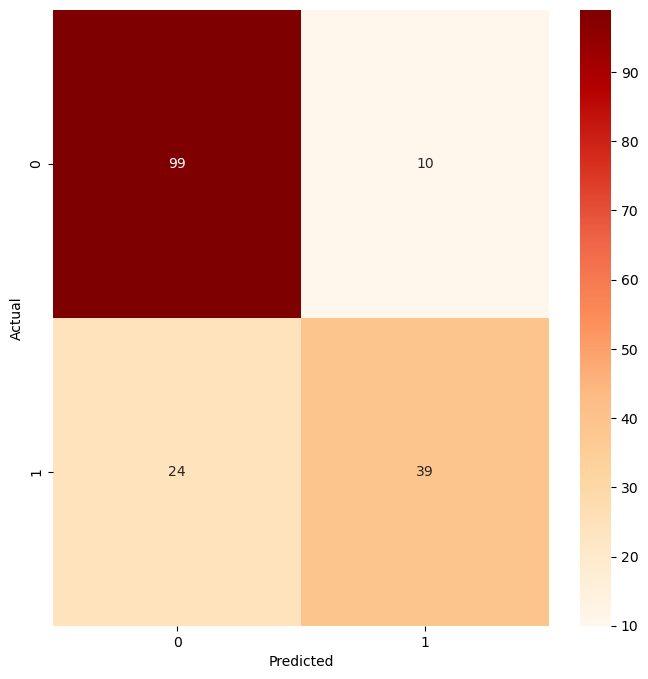

In [82]:
#Visualize confusion matrix
svc_cm = confusion_matrix(y_dev, svc_best_clf.predict(X_dev))
ConfusionMatrixVisualizer(svc_cm)

In [83]:
#Similar performance to random forest on the dev set
#Great performance for those that did not survive, but not that well for those who did
#Train with the whole dataset
svc_clf = SVC(random_state=9)

prod_svc_param_grid = [
    {"C": np.linspace(1,3,50),"kernel":['poly']}
]

prod_svc_grid_search = GridSearchCV(svc_clf, prod_svc_param_grid, cv=4, scoring="accuracy", return_train_score=True,verbose=10)
prod_svc_grid_search.fit(X_full_train,y_full_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START C=1.0, kernel=poly.........................................
[CV 1/4; 1/50] END C=1.0, kernel=poly;, score=(train=0.830, test=0.759) total time=   0.0s
[CV 2/4; 1/50] START C=1.0, kernel=poly.........................................
[CV 2/4; 1/50] END C=1.0, kernel=poly;, score=(train=0.827, test=0.819) total time=   0.0s
[CV 3/4; 1/50] START C=1.0, kernel=poly.........................................
[CV 3/4; 1/50] END C=1.0, kernel=poly;, score=(train=0.824, test=0.769) total time=   0.0s
[CV 4/4; 1/50] START C=1.0, kernel=poly.........................................
[CV 4/4; 1/50] END C=1.0, kernel=poly;, score=(train=0.838, test=0.787) total time=   0.0s
[CV 1/4; 2/50] START C=1.0408163265306123, kernel=poly..........................
[CV 1/4; 2/50] END C=1.0408163265306123, kernel=poly;, score=(train=0.836, test=0.759) total time=   0.0s
[CV 2/4; 2/50] START C=1.0408163265306123, kernel=poly.........

[CV 4/4; 12/50] END C=1.4489795918367347, kernel=poly;, score=(train=0.844, test=0.796) total time=   0.0s
[CV 1/4; 13/50] START C=1.489795918367347, kernel=poly..........................
[CV 1/4; 13/50] END C=1.489795918367347, kernel=poly;, score=(train=0.852, test=0.769) total time=   0.0s
[CV 2/4; 13/50] START C=1.489795918367347, kernel=poly..........................
[CV 2/4; 13/50] END C=1.489795918367347, kernel=poly;, score=(train=0.840, test=0.833) total time=   0.0s
[CV 3/4; 13/50] START C=1.489795918367347, kernel=poly..........................
[CV 3/4; 13/50] END C=1.489795918367347, kernel=poly;, score=(train=0.840, test=0.773) total time=   0.0s
[CV 4/4; 13/50] START C=1.489795918367347, kernel=poly..........................
[CV 4/4; 13/50] END C=1.489795918367347, kernel=poly;, score=(train=0.844, test=0.796) total time=   0.0s
[CV 1/4; 14/50] START C=1.530612244897959, kernel=poly..........................
[CV 1/4; 14/50] END C=1.530612244897959, kernel=poly;, score=(tr

[CV 2/4; 24/50] END C=1.9387755102040816, kernel=poly;, score=(train=0.850, test=0.829) total time=   0.0s
[CV 3/4; 24/50] START C=1.9387755102040816, kernel=poly.........................
[CV 3/4; 24/50] END C=1.9387755102040816, kernel=poly;, score=(train=0.849, test=0.782) total time=   0.0s
[CV 4/4; 24/50] START C=1.9387755102040816, kernel=poly.........................
[CV 4/4; 24/50] END C=1.9387755102040816, kernel=poly;, score=(train=0.852, test=0.792) total time=   0.0s
[CV 1/4; 25/50] START C=1.9795918367346939, kernel=poly.........................
[CV 1/4; 25/50] END C=1.9795918367346939, kernel=poly;, score=(train=0.858, test=0.769) total time=   0.0s
[CV 2/4; 25/50] START C=1.9795918367346939, kernel=poly.........................
[CV 2/4; 25/50] END C=1.9795918367346939, kernel=poly;, score=(train=0.850, test=0.829) total time=   0.0s
[CV 3/4; 25/50] START C=1.9795918367346939, kernel=poly.........................
[CV 3/4; 25/50] END C=1.9795918367346939, kernel=poly;, scor

[CV 3/4; 35/50] END C=2.387755102040816, kernel=poly;, score=(train=0.863, test=0.801) total time=   0.0s
[CV 4/4; 35/50] START C=2.387755102040816, kernel=poly..........................
[CV 4/4; 35/50] END C=2.387755102040816, kernel=poly;, score=(train=0.855, test=0.796) total time=   0.0s
[CV 1/4; 36/50] START C=2.4285714285714284, kernel=poly.........................
[CV 1/4; 36/50] END C=2.4285714285714284, kernel=poly;, score=(train=0.860, test=0.769) total time=   0.0s
[CV 2/4; 36/50] START C=2.4285714285714284, kernel=poly.........................
[CV 2/4; 36/50] END C=2.4285714285714284, kernel=poly;, score=(train=0.855, test=0.824) total time=   0.0s
[CV 3/4; 36/50] START C=2.4285714285714284, kernel=poly.........................
[CV 3/4; 36/50] END C=2.4285714285714284, kernel=poly;, score=(train=0.863, test=0.801) total time=   0.0s
[CV 4/4; 36/50] START C=2.4285714285714284, kernel=poly.........................
[CV 4/4; 36/50] END C=2.4285714285714284, kernel=poly;, score=

[CV 1/4; 48/50] END C=2.9183673469387754, kernel=poly;, score=(train=0.869, test=0.773) total time=   0.0s
[CV 2/4; 48/50] START C=2.9183673469387754, kernel=poly.........................
[CV 2/4; 48/50] END C=2.9183673469387754, kernel=poly;, score=(train=0.858, test=0.819) total time=   0.0s
[CV 3/4; 48/50] START C=2.9183673469387754, kernel=poly.........................
[CV 3/4; 48/50] END C=2.9183673469387754, kernel=poly;, score=(train=0.863, test=0.806) total time=   0.0s
[CV 4/4; 48/50] START C=2.9183673469387754, kernel=poly.........................
[CV 4/4; 48/50] END C=2.9183673469387754, kernel=poly;, score=(train=0.858, test=0.792) total time=   0.0s
[CV 1/4; 49/50] START C=2.9591836734693877, kernel=poly.........................
[CV 1/4; 49/50] END C=2.9591836734693877, kernel=poly;, score=(train=0.869, test=0.773) total time=   0.0s
[CV 2/4; 49/50] START C=2.9591836734693877, kernel=poly.........................
[CV 2/4; 49/50] END C=2.9591836734693877, kernel=poly;, scor

GridSearchCV(cv=4, estimator=SVC(random_state=9),
             param_grid=[{'C': array([1.        , 1.04081633, 1.08163265, 1.12244898, 1.16326531,
       1.20408163, 1.24489796, 1.28571429, 1.32653061, 1.36734694,
       1.40816327, 1.44897959, 1.48979592, 1.53061224, 1.57142857,
       1.6122449 , 1.65306122, 1.69387755, 1.73469388, 1.7755102 ,
       1.81632653, 1.85714286, 1.89795918, 1.93877551, 1.97959184,
       2.02040816, 2.06122449, 2.10204082, 2.14285714, 2.18367347,
       2.2244898 , 2.26530612, 2.30612245, 2.34693878, 2.3877551 ,
       2.42857143, 2.46938776, 2.51020408, 2.55102041, 2.59183673,
       2.63265306, 2.67346939, 2.71428571, 2.75510204, 2.79591837,
       2.83673469, 2.87755102, 2.91836735, 2.95918367, 3.        ]),
                          'kernel': ['poly']}],
             return_train_score=True, scoring='accuracy', verbose=10)

In [84]:
#Retrieve the best estimator
prod_svc_best_clf = prod_svc_grid_search.best_estimator_
#Check parameters
print(prod_svc_best_clf)

SVC(C=2.3469387755102042, kernel='poly', random_state=9)


In [85]:
#Predict for the test data set
predictions = prod_svc_best_clf.predict(X_test)
#Format data for submission
final_df = pd.DataFrame(test_df['PassengerId']).astype(int)
final_df['Survived'] = predictions
final_df['Survived'] = final_df['Survived'].astype(int)
final_df.to_csv("titanic/SVCPredictions.csv",index=False)

[CV] END criterion=gini, max_depth=69, max_features=None, max_leaf_nodes=38, min_samples_split=4, n_estimators=11; total time=   0.0s
[CV] END criterion=gini, max_depth=27, max_features=sqrt, max_leaf_nodes=8, min_samples_split=2, n_estimators=349; total time=   0.5s
[CV] END criterion=entropy, max_depth=54, max_features=sqrt, max_leaf_nodes=35, min_samples_split=6, n_estimators=73; total time=   0.1s
[CV] END criterion=entropy, max_depth=19, max_features=None, max_leaf_nodes=38, min_samples_split=5, n_estimators=302; total time=   0.5s
[CV] END criterion=gini, max_depth=21, max_features=None, max_leaf_nodes=27, min_samples_split=3, n_estimators=52; total time=   0.1s
[CV] END criterion=entropy, max_depth=79, max_features=None, max_leaf_nodes=39, min_samples_split=4, n_estimators=140; total time=   0.2s
[CV] END criterion=entropy, max_depth=65, max_features=None, max_leaf_nodes=11, min_samples_split=6, n_estimators=286; total time=   0.4s
[CV] END criterion=gini, max_depth=81, max_feat

[CV] END criterion=gini, max_depth=69, max_features=None, max_leaf_nodes=38, min_samples_split=4, n_estimators=11; total time=   0.0s
[CV] END criterion=gini, max_depth=27, max_features=sqrt, max_leaf_nodes=8, min_samples_split=2, n_estimators=349; total time=   0.5s
[CV] END criterion=entropy, max_depth=54, max_features=sqrt, max_leaf_nodes=35, min_samples_split=6, n_estimators=73; total time=   0.1s
[CV] END criterion=entropy, max_depth=19, max_features=None, max_leaf_nodes=38, min_samples_split=5, n_estimators=302; total time=   0.5s
[CV] END criterion=gini, max_depth=21, max_features=None, max_leaf_nodes=27, min_samples_split=3, n_estimators=52; total time=   0.0s
[CV] END criterion=entropy, max_depth=79, max_features=None, max_leaf_nodes=39, min_samples_split=4, n_estimators=140; total time=   0.2s
[CV] END criterion=entropy, max_depth=65, max_features=None, max_leaf_nodes=11, min_samples_split=6, n_estimators=286; total time=   0.4s
[CV] END criterion=entropy, max_depth=83, max_f

[CV] END criterion=entropy, max_depth=40, max_features=log2, max_leaf_nodes=33, min_samples_split=8, n_estimators=145; total time=   0.3s
[CV] END criterion=entropy, max_depth=99, max_features=sqrt, max_leaf_nodes=14, min_samples_split=5, n_estimators=232; total time=   0.3s
[CV] END criterion=entropy, max_depth=2, max_features=None, max_leaf_nodes=14, min_samples_split=4, n_estimators=311; total time=   0.3s
[CV] END criterion=gini, max_depth=51, max_features=None, max_leaf_nodes=13, min_samples_split=4, n_estimators=329; total time=   0.4s
[CV] END criterion=gini, max_depth=31, max_features=None, max_leaf_nodes=3, min_samples_split=3, n_estimators=299; total time=   0.3s
[CV] END criterion=entropy, max_depth=69, max_features=sqrt, max_leaf_nodes=45, min_samples_split=4, n_estimators=91; total time=   0.1s
[CV] END criterion=entropy, max_depth=85, max_features=log2, max_leaf_nodes=3, min_samples_split=8, n_estimators=181; total time=   0.1s
[CV] END criterion=entropy, max_depth=83, ma